# Key Project Strategy Simulator - Gaia

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate
import h5py

## Gaia Event Sky Locations

To start off with, let's start by simulating the set of Gaia events that we are likely to detect. 

The code skymap_events.py was previously used to map the events detected in Gaia Data Release 3 by Katarzyna, and convert this into a very rough map of event rate per year per HEALpixel (see code skymap_events.py).  This takes into account Gaia's time sampling, the distributions of stars, events and extinction, and Gaia's restricted limiting magnitude in crowded fields. 

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'gaia/gaia_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

gaia_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
gaia_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

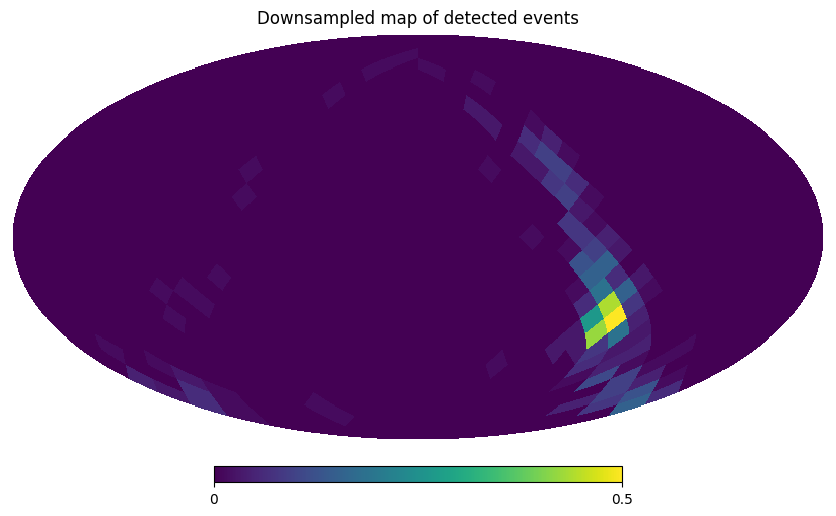

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(gaia_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

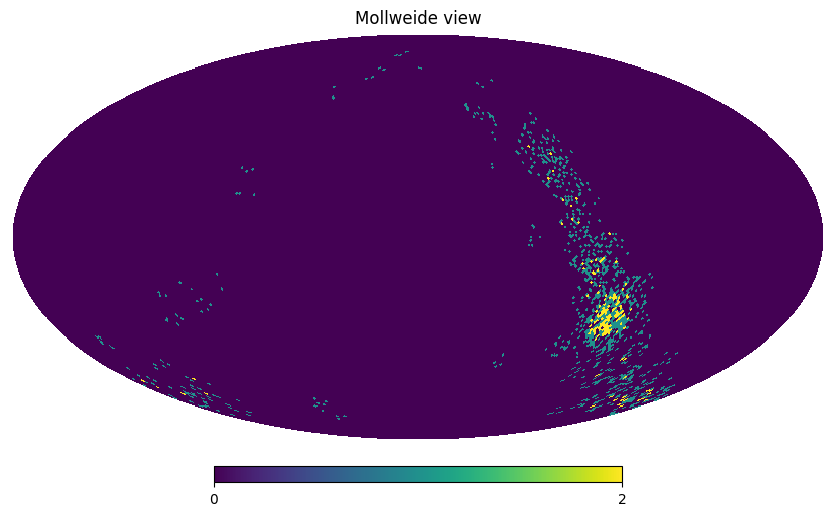

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = gaia_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -32.79716667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -11.41515556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -17.582775)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -5.37937778)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -37.92165)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -34.95386389)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (281.953125, -35.68533333)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -37.92165)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (266.484375, -31.38816389)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (262.96875, -22.66960833)>"


## Gaia Event Baseline Magnitudes

Next we need to simulate the lightcurve data that Gaia would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  We derive this by looking at the distribution of historic data from the Gaia Alerts system.  

In [8]:
def str2float(str):
    if len(str) > 0:
        return float(str)
    else:
        return -99.999

In [9]:
file_path = 'gaia/gaia_alerts_data.csv'
file_lines = open(file_path, 'r').readlines()
event_ids = []
data = []
for i,line in enumerate(file_lines):
    if i > 0:
        row = line.replace('\n','').split(',')
        event_ids.append(row[0])
        data.append([str2float(row[2]), str2float(row[3]), str2float(row[5]), str2float(row[6])])
data = np.array(data)

gaia_alert_table = Table([
                            Column(name="Event", data=event_ids, dtype='str'),
                            Column(name="RA", data=data[:,0], dtype='str'),
                            Column(name="Dec", data=data[:,1], dtype='str'),
                            Column(name="mag", data=data[:,2], dtype='float'),
                            Column(name="mag_error", data=data[:,3], dtype='float'),
                            ])
gaia_alert_table

Event,RA,Dec,mag,mag_error
str9,str32,str32,float64,float64
Gaia22epg,19.96019,-53.955,19.83,0.4
Gaia22epf,274.77416,-28.17701,19.55,0.05
Gaia22epe,273.40098,-29.60688,19.3,0.04
Gaia22epd,271.10083,-24.27362,18.34,0.36
Gaia22epc,14.69411,-56.98653,16.86,0.18
Gaia22epb,272.94736,-27.39745,18.11,0.06
...,...,...,...,...
Gaia14aag,219.14335,44.65261,18.42,0.02
Gaia14aaf,244.25381,62.00685,18.06,0.19


Text(0.5, 1.0, 'Distribution of baseline magnitudes of Gaia Alerts')

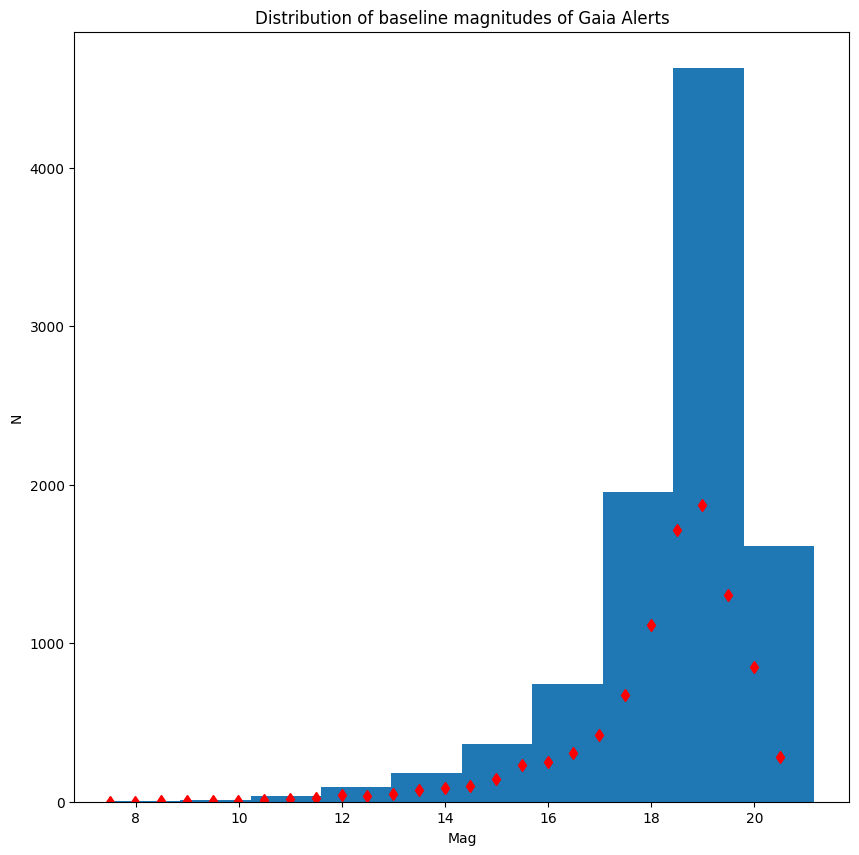

In [10]:
idx = np.where(gaia_alert_table['mag'] > 0.0)
mag_min = gaia_alert_table['mag'][idx].min()
mag_max = gaia_alert_table['mag'][idx].max()
(mag_dist, mag_bins) = np.histogram(gaia_alert_table['mag'][idx], bins=np.arange(mag_min, mag_max, 0.5))


fig = plt.figure(1,(10,10))
plt.hist(gaia_alert_table['mag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of baseline magnitudes of Gaia Alerts')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for Gaia detections

Text(0.5, 1.0, 'Distribution of simulated Gaia detections')

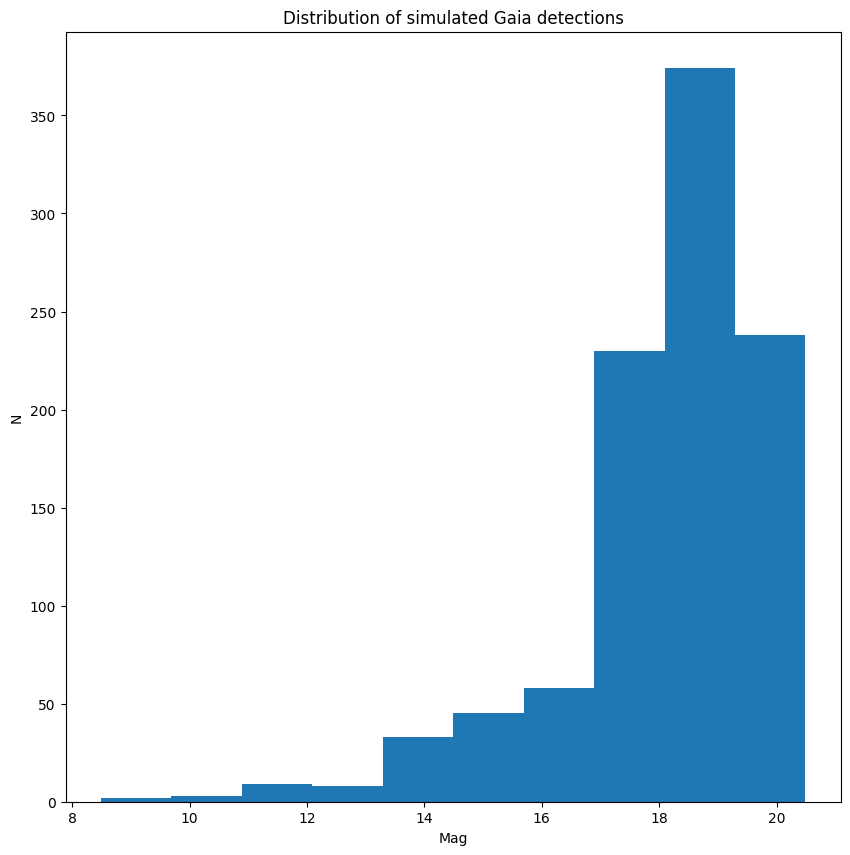

In [11]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated Gaia detections')

## Gaia Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the overlap between the Key Project (2023-2026) and Gaia's expected dates of operation (2023-2025):

In [12]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2460887.5000

In [13]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [14]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

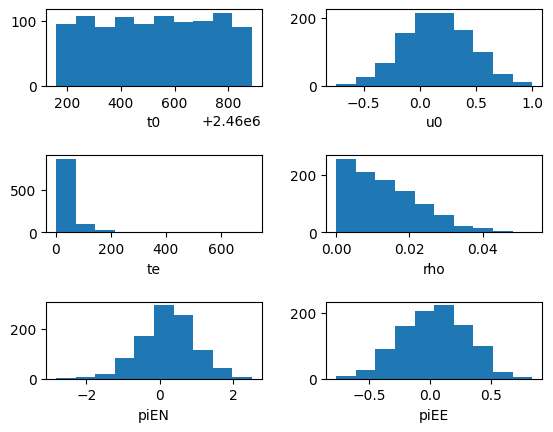

In [15]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

For ease of handling, let's combine these data into a single events table

In [16]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('GaiaSim'+roundID(x))

In [17]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,37953,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -32.79716667)>",19.990000000000002,2460712.499849947,0.6400673917586376,12.268323874505624,0.020228023587556224,0.3496019068355115,-0.3939170508394604,0.0
GaiaSim00002,29516,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -11.41515556)>",15.99,2460254.8075024607,0.24901520429909874,18.67553217077708,0.012484655286869947,0.6293397692883446,0.18130525322289273,0.0
GaiaSim00003,32070,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -17.582775)>",18.990000000000002,2460803.229195148,-0.21485779306280658,98.50266609271823,0.014597254095848831,0.16204148801250326,-0.03856918210976346,0.0
GaiaSim00004,26950,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -5.37937778)>",19.490000000000002,2460585.0121493316,-0.1245471904853854,24.25802278756786,0.02987161322083834,0.5753779909199362,0.21519321021228777,0.0
GaiaSim00005,39745,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -37.92165)>",18.990000000000002,2460305.7681900933,0.09025144977122407,38.25380449399144,0.00720238349282996,0.39286846657381747,0.004634455922137036,0.0
GaiaSim00006,38723,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -34.95386389)>",19.490000000000002,2460579.0123759117,0.6640160665414205,66.9619075954547,0.007701354174728398,0.2437326439555234,0.1844496188728329,0.0
...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,46423,"<SkyCoord (ICRS): (ra, dec) in deg\n (203.10810417, -62.69665833)>",15.99,2460567.742995921,-0.23424356930753334,61.61432191975597,0.023012559201018606,0.05420692614774397,-0.22226782053567548,0.0
GaiaSim00995,43565,"<SkyCoord (ICRS): (ra, dec) in deg\n (233.4905625, -50.48004167)>",18.990000000000002,2460653.1388043906,-0.12829416953386732,18.693851491115733,0.006076564829765312,0.1214570018669636,-0.42723378370142095,0.0


### Blending

Note that we implicitly assume zero blending from background stars in the photometry for Gaia events.  Analysis offline has shown that this is a reasonable approximation for events outside the galactic centre, which are the majority of Gaia events. 



## Gaia Event Lightcurve sampling

In order to generate realistic Gaia lightcurves, we take into account the non-uniform map of visits that results from Gaia's scanning law. We read in this data, which was resampled using the gaia/gaia_scanning_law notebook, and output to file gaia/gaia_dr3_nvisits_34months.fits.  Since Gaia is expected to continue operating for 24months during the Key  Project, we scale the expected number of visits per HEALpixel accordingly.  

In [18]:
gaia_duration = 34*30.0
gaia_kp_overlap = 365.24*2.0
scale_factor = gaia_kp_overlap / gaia_duration
scale_factor

0.716156862745098

In [19]:
map_file_path = 'gaia/gaia_dr3_nvisits_34months.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

gaia_nvisits = Table([
                        Column(name="HP", data=data_table['hp_index'], dtype='int'),
                        Column(name="nvisits", data=data_table['nvisits']*scale_factor, dtype='int'),
                        ])
gaia_nvisits

HP,nvisits
int64,int64
1,221
2,226
3,219
4,219
5,232
6,222
...,...
49146,224
49147,230


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [20]:
events_table['nvisits'] = gaia_nvisits['nvisits'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,int64
GaiaSim00001,37953,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -32.79716667)>",19.990000000000002,2460712.499849947,0.6400673917586376,12.268323874505624,0.020228023587556224,0.3496019068355115,-0.3939170508394604,160
GaiaSim00002,29516,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -11.41515556)>",15.99,2460254.8075024607,0.24901520429909874,18.67553217077708,0.012484655286869947,0.6293397692883446,0.18130525322289273,107
GaiaSim00003,32070,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -17.582775)>",18.990000000000002,2460803.229195148,-0.21485779306280658,98.50266609271823,0.014597254095848831,0.16204148801250326,-0.03856918210976346,97
GaiaSim00004,26950,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -5.37937778)>",19.490000000000002,2460585.0121493316,-0.1245471904853854,24.25802278756786,0.02987161322083834,0.5753779909199362,0.21519321021228777,106
GaiaSim00005,39745,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -37.92165)>",18.990000000000002,2460305.7681900933,0.09025144977122407,38.25380449399144,0.00720238349282996,0.39286846657381747,0.004634455922137036,145
GaiaSim00006,38723,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -34.95386389)>",19.490000000000002,2460579.0123759117,0.6640160665414205,66.9619075954547,0.007701354174728398,0.2437326439555234,0.1844496188728329,125
...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,46423,"<SkyCoord (ICRS): (ra, dec) in deg\n (203.10810417, -62.69665833)>",15.99,2460567.742995921,-0.23424356930753334,61.61432191975597,0.023012559201018606,0.05420692614774397,-0.22226782053567548,269
GaiaSim00995,43565,"<SkyCoord (ICRS): (ra, dec) in deg\n (233.4905625, -50.48004167)>",18.990000000000002,2460653.1388043906,-0.12829416953386732,18.693851491115733,0.006076564829765312,0.1214570018669636,-0.42723378370142095,205


Store the table of simulated event parameters

In [21]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_events_table.fits', overwrite=True)


## Gaia Event Lightcurves

Now we can simulate the lightcurves that Gaia would produce for these simulated events.  Although the scanning law data does not tell us the distribution of visits over the 34 months included in Gaia DR3, it is a regularly repeating function with a non-varying scan from a space-based facility.  The sampling isn't uniform, but we approximate it here as uniform, since experiments with the Gaia scanninglaw package failed due to out of date documentation.  

In [22]:
def add_gaia_g_noise(mag):
    """Code by Markus Hundertmark
    """
    a1 = 0.2
    b1 = -5.3 #-5.2
    a2=0.2625
    b2= -6.3625 #-6.2625

    mag_obs_list = []
    magerr_list = []

    for value in mag:
        log_err1 = a1*value + b1
        log_err2 = a2*value + b2
        if (value < 13.5):
            magerr = 10**(a1*13.5+b1)
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if value>=13.5 and value<17:
            magerr = 10**log_err1
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if (value>=17):
            magerr = 10**log_err2
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        #this works until 21 mag.
    return np.array(mag_obs_list), np.array(magerr_list)

In [23]:
def simulate_event_gaia(event_params, start_date, end_date, horizons_table, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Simulate timestamps
    cadence = (end_date - start_date) / event_params['nvisits']
    timestamps = np.arange(start_date, end_date, cadence)
    
    # Create a PyLIMA event object
    sim_event = event.Event()
    sim_event.name = event_params['EventID']
    sim_event.ra = float(event_params['location'].ra.deg)
    sim_event.dec = float(event_params['location'].dec.deg)

    # Generate a constant lightcurve at the event's baseline magnitude, with fixed photometric uncertainties, 
    # since these will be replaced later
    lc = np.zeros((len(timestamps),3))
    lc[:,0] = timestamps
    lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
    lc[:,2] = [0.01] * len(timestamps)
    print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
    # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
    tel = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel.spacecraft_positions = spacecraft_positions
    
    sim_event.telescopes.append(tel)
    sim_event.find_survey('Gaia')
    
    # Add a PyLIMA model to the event, using the simulated parameters
    if parallax:
        sim_model = microlmodels.create_model('FSPL', sim_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    else:
        sim_model = microlmodels.create_model('FSPL', sim_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]
        
    sim_model.define_model_parameters()
    
    if parallax:
        sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
    tel = sim_model.event.telescopes[0]
    
    pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
    #print(event_params)
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    magnification = sim_model.model_magnification(tel, pylima_parameters)
    A = sim_model.model_magnification(tel,pylima_parameters)
    
    lightcurve = sim_event.telescopes[0].lightcurve_magnitude
    lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
    (lightcurve[:,1],lightcurve[:,2]) = add_gaia_g_noise(lightcurve[:,1])
    sim_event.telescopes[0].lightcurve_magnitude = lightcurve
    print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
    
    return sim_event, sim_model, lensing_parameters

In order to implement parallax for Gaia events, we use the projected vector locations of the spacecraft, as generated by JPL Horizons, and output to an ASCII table which can be read from file.  
The JPL Horizons configuration used to generate this table is:
* Ephemeris type: Vector table
* Target body: Gaia (spacecraft)
* Coordinate center: Solar System Barycenter SSB [500@0]
* Time: 2023-01-01 to 2026-08-30, increments of 1 day (duration of Key Project)
* Table settings: default

However, this appears not to be the format required to calculate the observed location of the spacecraft.  Instead it needs the RA, Dec position, meaning that the observer table format is required, with the following options:
* Astrometric RA & Dec
* Rates RA & Dec
* Airmass and extinction (required)
* Visual mag & surface brightness
* Heliocentric range and range rate
* Observer range and range rate
* Sun-Observer-Target ELONG angle
* Sun-Target-Observer PHASE angle
* Local apparent hour angle
* Sky motion
* Lunar sky brightness

In [24]:
gaia_vector_table_file = './gaia/jplhorizons_observer_table.txt'

horizons_table = jplhorizons_utils.parse_JPL_Horizons_table(horizons_file_path=gaia_vector_table_file, 
                                                                   table_type='OBSERVER')
horizons_table

Date,RA,Dec,Delta,JD
bytes16,float64,float64,float64,float64
2023-Jan-01T00:0,101.31470833333333,22.988694444444445,0.99424530711027,2459945.5
2023-Jan-02T00:0,102.41991666666667,22.90411111111111,0.99437003596059,2459946.5
2023-Jan-03T00:0,103.52370833333335,22.811972222222224,0.99450009481111,2459947.5
2023-Jan-04T00:0,104.625875,22.712305555555556,0.9946354327103,2459948.5
2023-Jan-05T00:0,105.72629166666665,22.605194444444447,0.99477599538272,2459949.5
2023-Jan-06T00:0,106.82491666666667,22.49063888888889,0.99492172842485,2459950.5
...,...,...,...,...
2026-Aug-22T00:0,330.5357916666667,-12.060194444444445,1.02354688405442,2461274.5
2026-Aug-23T00:0,331.45425,-11.725111111111111,1.02327762396697,2461275.5


In [25]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

gaia_lens, gaia_lens_model, lens_model_pars = simulate_event_gaia(events_table[event_number], start_date, end_date, horizons_table, parallax=True)

Picked bright event:  1  baseline_mag= 15.99 mag
15.99 15.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.987462254339299


Simulate all events

In [26]:
sim_gaia_lenses = []
sim_gaia_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (gaia_lens, gaia_lens_model, lens_model_pars) = simulate_event_gaia(events_table[ievent], start_date, end_date, horizons_table, parallax=True)
    sim_gaia_lenses.append(gaia_lens)
    sim_gaia_lens_models.append(gaia_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.983162624302715
0 [2460712.499849947, 0.6400673917586376, 12.268323874505624, 0.020228023587556224, 0.3496019068355115, -0.3939170508394604]
15.99 15.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.986499720230503
1 [2460254.8075024607, 0.24901520429909874, 18.67553217077708, 0.012484655286869947, 0.6293397692883446, 0.18130525322289273]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.9540302444966
2 [2460803.229195148, -0.21485779306280658, 98.50266609271823, 0.014597254095848831, 0.16204148801250326, -0.03856918210976346]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.4861248372874
3 [2460585.0121493316, -0.1245471904853854, 24.25802278756786, 0.02987161322083834, 0.5753779909199362, 0.21519321021228777]
18.9900

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.972947696215684
37 [2460564.230332443, -0.2765310941065042, 25.021458179462957, 0.01249670494107593, 0.7116353123831602, 0.4541586229462509]
14.99 14.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.98961118160094
38 [2460424.509006427, -0.20076722937721167, 10.523438375921922, 0.0068138576597688025, 0.14103675359651105, 0.20273015424314308]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.480050463437852
39 [2460834.0951987547, 0.05019467501959482, 45.11085737900606, 0.02036397240695343, 1.7560942994395947, 0.015655381413285374]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.992375660577434
40 [2460384.0212169285, -0.09377762524344851, 2.7902544923007726, 0.01725437630644987, -0.36003691334990856, -0.406286614461607]
17.490000000000002 17.4900000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.892922363065907
77 [2460407.1360371783, 0.18274898540645074, 712.1928122456409, 0.026886312861470363, 0.952786295131383, -0.058644919307667916]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.453092033738095
78 [2460356.812202025, 0.13160677882153587, 58.14619823641266, 0.009101476321515421, 0.006991225873287654, 0.3142897681711222]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.488018619789713
79 [2460858.3816914395, 0.16987861215089992, 4.501258372647342, 0.0008135045600251682, 0.9050993749213343, -0.18636519705410903]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.980758099523566
80 [2460515.9022218063, -0.007316338482302148, 25.547497529887973, 0.006415108501513474, -0.9246898983231449, 0.2259365190

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48708391642257
113 [2460555.8196934815, -0.24640648226839582, 13.194674284806556, 0.014220334628862723, 0.4844883767016915, 0.03137147896977829]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.964402126907256
114 [2460734.76613435, -0.39791403806789394, 42.03856115523359, 0.023720047599449956, 0.4680655971783007, 0.3526395630009614]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.9661613196351
115 [2460683.3699310613, 0.31088907408370003, 22.327944027516196, 0.012510212743103082, 0.4434775611520192, -0.12136850895602949]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.471509613435856
116 [2460413.2619931423, 0.5605539944904816, 34.400880369971844, 0.026955911543601073, 0.10162458943522881, 0.0313429552362

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.46810405093011
151 [2460242.432661719, 0.32001831221890853, 54.07688616153503, 0.0038801863955490665, 0.07371161390018782, 0.12510855427236578]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.978511870914026
152 [2460497.3528980403, -0.05852866852105054, 34.19565537980856, 0.006305053378606441, 0.5137050267303822, 0.0557693713331732]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47553217452632
153 [2460579.0229923762, 0.4993461823218759, 31.50092808335798, 0.009571705040244785, 0.42586702988461356, 0.02553267294324133]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.922516474516655
154 [2460485.5862726117, 0.2503939340030469, 111.84470183267385, 0.003856423376374603, 0.4981845294489947, 0.14118655718837

Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.49 13.489455293048094
188 [2460873.9280207697, -0.16853840740525552, 19.48416156872856, 0.012949778883434687, 0.21263725312401682, 0.12508470596229299]
15.99 15.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.988444866584109
189 [2460307.1039567934, -0.0750130985506936, 8.836391491279606, 0.01652459524606093, -1.526845613291329, 0.02645624655547503]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.41644897268792
190 [2460681.008266116, 0.10696440685743527, 80.00977126633074, 0.008865526202438955, -0.2990226498966127, 0.341153345930088]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.979042715230563
191 [2460826.9164993037, 0.2656094870834315, 38.041303605477054, 0.00266262105480004, 1.3550396825706164, -0.5198938097938912]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: S

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.989121673942265
223 [2460817.314174623, 0.25659723573631393, 9.46226052274059, 0.005118036519024387, 0.7638933983201133, -0.22812154689050193]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.9870536130261
224 [2460465.8814120395, -0.03199153249924189, 20.01638081783286, 0.0002997071513918051, 1.8084426972246084, 0.15112968520403122]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.982218113165544
225 [2460794.1677098237, -0.06776761055663783, 30.55120748204352, 0.014787882163756611, 1.5449396961696789, 0.2927406908613264]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.4725861315848
226 [2460675.066019662, 0.20289472394267807, 36.15547442952214, 0.01046722060463663, 0.03302419014066482, 0.03962767653852644

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.987462571184437
258 [2460538.691770386, 0.41325816184929265, 5.268411116824695, 0.003787908154822382, 0.4490816043670619, 0.4316151891881007]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.986024205274987
259 [2460762.9184078025, -0.2412303667819192, 10.493674867354049, 0.01848335816234104, -0.06066248410229089, 0.3697475649923657]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.472420675597068
260 [2460242.35033446, 0.4034299790269408, 25.86869737738024, 0.005870942968501388, 1.343539669958003, -0.4221050360861813]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.98239989317527
261 [2460578.05658096, 0.10611795241430591, 19.685697437133744, 0.03262268963768812, 0.5935956453044509, -0.2328852661898191]
19

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98025708509598
295 [2460253.595188213, 0.5770363917648904, 18.997399710187388, 0.013538005089824562, 1.1524716222512301, 0.493155480820522]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.468831610072158
296 [2460326.919049583, -0.017625643155160936, 30.219554471378004, 0.01567106016357402, -0.39407054654341583, 0.8422512752525133]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.933313192350013
297 [2460580.7485204595, -0.19891896530189265, 99.56199546552467, 0.001435041026808288, 1.4194267977275685, 0.00686239266654614]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.390456347683056
298 [2460694.153658107, 0.7263966824017307, 99.1514313441442, 0.012278063321895157, 0.3100580509835401, 0.2139578310797365]

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.98786424985672
333 [2460876.874067217, 0.5189077488424131, 29.076028623827884, 7.096636704568941e-05, 0.9057766816771617, -0.0481523092868554]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.982539193392913
334 [2460800.9741713284, -0.3369403775830656, 20.968349570741104, 0.01877880573671192, 1.3758127863883993, 0.30875235696072]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.97541226892206
335 [2460482.663733979, -0.084978528341661, 23.315301278947782, 0.01731367292032311, 1.4044241360659775, -0.06411446831544274]
14.99 14.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.98478123521577
336 [2460178.4991700943, 0.18160913780755653, 60.37525734333665, 0.012035807165942358, -0.7577225526609914, 0.017551233776353228]
18.990000000000002 18.990000000000002


Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.45620987243141
369 [2460765.886599468, 0.15175736633193473, 46.07287447461925, 0.004300557089684099, -1.2983866801823227, -0.3452399602647394]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.977799748037288
370 [2460300.643927456, 0.3208403542245434, 35.05604998688289, 0.008080912355601969, -0.6560000246957487, -0.20134250707986148]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.96374540628972
371 [2460165.777326601, 0.4700292011638969, 78.73085653088, 0.025639709057767454, -0.6830080266220251, -0.03741576383403406]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.482438716362473
372 [2460583.787817509, 0.08384384969801578, 13.17865134656723, 0.025720868049416853, 0.24646540190792365, 0.4265344377650334]


Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.4586925110449
416 [2460480.550679334, -0.09200948916773705, 53.14699337933804, 0.024612501847727113, -0.19570171597033176, 0.11600721538989811]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.946200758531
417 [2460349.468683926, 0.07485344527475395, 51.83046789344845, 0.004004306414906692, 0.6082796639994814, 0.09460194704966762]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.989947749127186
418 [2460363.733427542, 0.23635413646146367, 7.478846875868919, 0.006226576757704943, -1.3191246144066413, 0.20443875380570836]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.978715709924558
419 [2460563.11802337, -0.33742863921766153, 24.19265181142095, 0.0007098020325477725, -0.35749085379977025, -0.42278107282351

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.936625888850724
461 [2460411.425545377, 0.2752022834045914, 46.8532951251722, 0.0005259237268504012, 0.6273513433610483, 0.004049351879741626]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.48844519245166
462 [2460419.7826831, 0.24296930338954098, 12.780895044542811, 0.0026430537428784907, 0.7344760606475393, -0.09060151620238832]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.97430969046234
463 [2460273.4510772815, 0.5732847515506349, 48.370877191292145, 0.004921318542596295, -1.6234894186091757, -0.37048935590428245]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.979498510418267
464 [2460331.433785424, 0.3341167997785547, 22.875510957302964, 0.03640935722141948, -0.5828444357578118, 0.122813909299108

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.986641765060355
499 [2460162.997782432, 0.515528544523563, 26.268503058379608, 0.005586039967253033, 0.14444772514988927, 0.1208286629219339]
16.490000000000002 16.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.48556799404063
500 [2460808.529062143, 0.26110090604800135, 28.17510013691292, 0.00269775010156379, -0.5346675277314947, -0.21569132086048456]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98216918866899
501 [2460616.9175428892, 0.1805410034212912, 15.442349749218607, 0.025380641097625133, -0.3806291773097456, 0.07190314273884689]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.478149600196932
502 [2460306.026192276, 0.46002708595442265, 14.456184919249747, 0.02388984522145595, -1.4008731760021005, 0.2801242163222722

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.48878419028893
539 [2460410.7419253713, -0.2425736753551704, 22.4311999317849, 0.007040816101550446, -0.7603050317253424, 0.3170393306134804]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.975627423232226
540 [2460217.050373482, -0.15905959337569273, 54.532837930739746, 0.012625973282153187, 0.43407142841593876, 0.4205129251469664]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.44437810539901
541 [2460688.0705788224, -0.49047314208274395, 74.5366106385024, 0.0034767642571038593, 0.48735054741359174, -0.22974292261153859]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.477751056939496
542 [2460597.1267207107, 0.4029924987859953, 37.50516034410609, 0.009455055540910725, 0.2774707302853274, -0.30637991139243403]
18.990

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.48585357537032
577 [2460308.0620850045, -0.3969138007484736, 20.141287069888644, 0.014253206122410305, 0.2737503823318799, -0.2442003831592858]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.4882402545392
578 [2460358.912159114, -0.07679422232073141, 21.155990262094562, 0.0031292781618296626, 0.4991386776022422, 0.10062899663485446]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.92104426237876
579 [2460658.185210543, 0.3707952279201113, 92.07528882586755, 0.01615833323339296, 0.5115195561306745, 0.01967263123785334]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.48705512314431
580 [2460677.3406949854, 0.3338291379314646, 32.37165262804109, 0.021045614578487054, 1.1448356576404226, -0.04738959075138444]
18.490000000000002 18.490000000000002


Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.479864960140286
613 [2460665.6330809547, 0.6259133714313033, 16.555745790288512, 0.0012323569942131827, -0.2476153864573134, -0.13187878549977924]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.954616801203173
614 [2460818.9046104336, -0.23787849210916853, 72.17597068519959, 0.00029077024572871264, 0.47411745345013123, -0.29482954027790836]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47134698518997
615 [2460391.6943181017, 0.30797320010870133, 33.86463787942163, 0.0052545204471254985, -1.0889722869383982, 0.12121505543140657]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.97549729872905
616 [2460722.052157264, 0.41090738204289046, 38.3489750284776, 0.0024803496117440788, 0.17872312281945005, -0.0131

Parallax(Full) estimated for the telescope Gaia: SUCCESS
11.99 11.989874471820524
650 [2460162.448653008, 0.43221633157050643, 5.6819780557253745, 0.00294718034046477, 0.9813483694199459, -0.2829151427648606]
15.99 15.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.98453339670586
651 [2460391.2982173082, -0.20269244089681668, 22.786599978491928, 0.0032217456650810057, -1.0361535396295418, 0.04029851395762778]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.467478579707457
652 [2460783.6079487572, -0.1724671581613554, 48.900109847822385, 0.02860330171177762, 0.05010909541668354, -0.25558588371863566]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.982845373915122
653 [2460391.9516471117, 0.4234119868168922, 19.140857641375064, 0.016824823955318525, -0.49808069787974746, -0.19141471655470482]
17.990000000000002 17.990000000000002
P

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.979618153402438
699 [2460301.6645272537, 0.4546232766939373, 14.390076382932014, 0.04000635520944766, 0.5411567885188877, 0.07688005619805209]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.96883700263333
700 [2460419.2583695212, 0.30057681916442713, 40.589594617848256, 0.007977196293945105, 0.15717587668366625, -0.35297860989903307]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.48014006903759
701 [2460376.4942725655, -0.5575679982856248, 20.7523889985763, 0.008329957014610647, 0.9036174948456992, -0.06146006585023247]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.4720406910122
702 [2460771.585601193, 0.2824469473532102, 49.66394718528611, 0.000573370029612945, -0.8282843145677281, -0.230187506399990

18.490000000000002 18.48626808625835
742 [2460466.9042784995, 0.6404207046600182, 13.254239994560228, 0.01710753591700001, 0.5026500578206361, 0.23050208092585955]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.993314782494487
743 [2460630.256744404, 0.0009204013492517538, 2.595076242089486, 0.03813467147583095, -0.8699489386941541, 0.1713981273080197]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.483034681355466
744 [2460868.358948184, -0.4088557915292532, 42.13327100062505, 0.02346000403924671, 0.34480636186734825, 0.42406081465374995]
16.490000000000002 16.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.484971378207035
745 [2460217.080630449, 0.3795255874661638, 36.93971883821154, 0.0031865775266196944, 0.3719209905966288, 0.144740929851562]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97332636564177
780 [2460224.836182829, -0.026328273707918848, 25.704292920879833, 0.006929883049613957, -0.9766877020789202, -0.35072105664312325]
15.99 15.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.980102472411348
781 [2460541.598202757, -0.5412673508364992, 34.56072466234271, 0.01722450469121623, 0.6711410203341008, 0.28601367533161576]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.985157447790577
782 [2460498.935453132, -0.27153502385480677, 12.373645228826012, 0.0001791273440985841, 0.6880342717342214, 0.0997757471710306]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.976102059231657
783 [2460394.740611576, -0.19670094962996285, 19.24197253291157, 0.012138433867399443, -0.9808642585384917, 0.21895759241412077]
18.990000000000002 18.99000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.916431520002146
819 [2460792.3630714803, -0.0727784462446765, 176.3007735434961, 0.002876058381360848, -0.15371973946699075, 0.13121528948256944]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.49088297853829
820 [2460866.0678800363, -0.03315314016170118, 7.418433164692871, 0.003008659114306667, 0.11955076870792578, 0.09556567070775385]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.959039244979074
821 [2460653.394414168, -0.19651204029200967, 72.13585388629404, 0.008496492865319389, 0.611808011593169, 0.04660965591586174]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48884868379722
822 [2460557.0478286636, 0.14622461761788597, 8.899385571976275, 0.012677930046312071, 1.2829956967358334, -0.10913403635

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.984979726663354
855 [2460855.740102255, 0.10762805810131676, 5.881219741383801, 0.0028819084308575873, -0.23406945568343263, 0.2007517032605254]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.478335252167778
856 [2460470.8463015193, 0.13066556812200908, 19.555930592072574, 0.014818556953405209, 0.5978512282832634, 0.10155974668234566]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.487824803008754
857 [2460190.967644323, 0.20449641667055396, 26.466746785370077, 0.010244667487768434, 0.010392481209356846, -0.003824319689173322]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.484942541370962
858 [2460849.8078374425, 0.17242033839099524, 21.446337451337516, 0.02070575739270593, 0.15161252096510855, 0.029173877432802354]
18.990000000000002 18.990

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.973308463088493
892 [2460682.535746595, -0.27271214365426766, 24.380850758206634, 0.007536032874311526, 0.17380267988366252, 0.2985764072148607]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.973364440568275
893 [2460504.1656346, -0.09952437257760477, 26.048182787208056, 0.0007707845119112166, 1.1877524027436797, 0.3890612200029499]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.972830596174603
894 [2460241.942380033, 0.3367794829786277, 84.7676543719587, 0.020488033059423913, 0.9094977566299376, -0.3033852250792437]
13.49 13.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.49 13.489976524713
895 [2460237.1388805974, 0.27550490937285604, 7.154136005697711, 0.008226591120979843, -0.19917049483395072, 0.03202700689452134]
19.490000000000002 19.490000000000002

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.483892604315862
925 [2460794.0593440933, 0.21064412154440004, 67.75216025971226, 0.03715500134817222, 1.2844861342065592, -0.42732735999274274]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.983653073778115
926 [2460654.907385848, -0.08260457125953355, 17.719509528450242, 0.024058540914347844, 0.9285473184955677, 0.009826074922095508]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.981397728702387
927 [2460435.6745191407, -0.13210979488184585, 20.548502190776436, 0.025639133777273726, 0.7599987460194637, -0.1311012850671497]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.784033701131005
928 [2460317.173317072, 0.4238733169765918, 167.7928724144679, 0.01913472513464428, 0.19155967135089721, 0.6039032387502117]
18.490

19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.98283459848254
961 [2460501.177435593, -0.31532898573909274, 5.658945350247851, 0.008209671459574177, -1.209808397115127, -0.5052121857702394]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47978498817713
962 [2460276.734370772, 0.07657018269214719, 25.817557690138994, 0.019727720680092577, 0.2695721665493117, -0.12549203696326475]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.48164261129277
963 [2460246.901571129, 0.07004806426946121, 11.730647240865466, 0.01220314404793185, -0.9311256852101109, -0.04226769814483563]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.97427804344082
964 [2460632.4211327145, 0.08350672059554355, 44.89285771609269, 0.015783341543196938,

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.489590118298644
998 [2460291.8276484897, 0.30877226879382613, 3.883754143515006, 0.00850705502686963, -0.09743545378503138, 0.06925309556919956]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.486241578080625
999 [2460278.047442896, -0.14083141616342962, 30.2308817716717, 0.003005532286693228, 0.09037045155233081, -0.45802509753280435]


Store the simulated Gaia lightcurves

In [27]:
file_path = 'simulated_gaia_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_gaia_lenses),1):
        lc = sim_gaia_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

Plot an example event

  EventID      HP                              location                             baseline_mag         t0                  u0                 te                rho                 piEN                piEE        nvisits
------------ ----- ---------------------------------------------------------------- ------------ ------------------ ------------------- ----------------- -------------------- ------------------ ------------------- -------
GaiaSim00002 29516 <SkyCoord (ICRS): (ra, dec) in deg\n    (286.875, -11.41515556)>        15.99 2460254.8075024607 0.24901520429909874 18.67553217077708 0.012484655286869947 0.6293397692883446 0.18130525322289273     107


Text(0.5, 1.0, 'Simulated event GaiaSim00002')

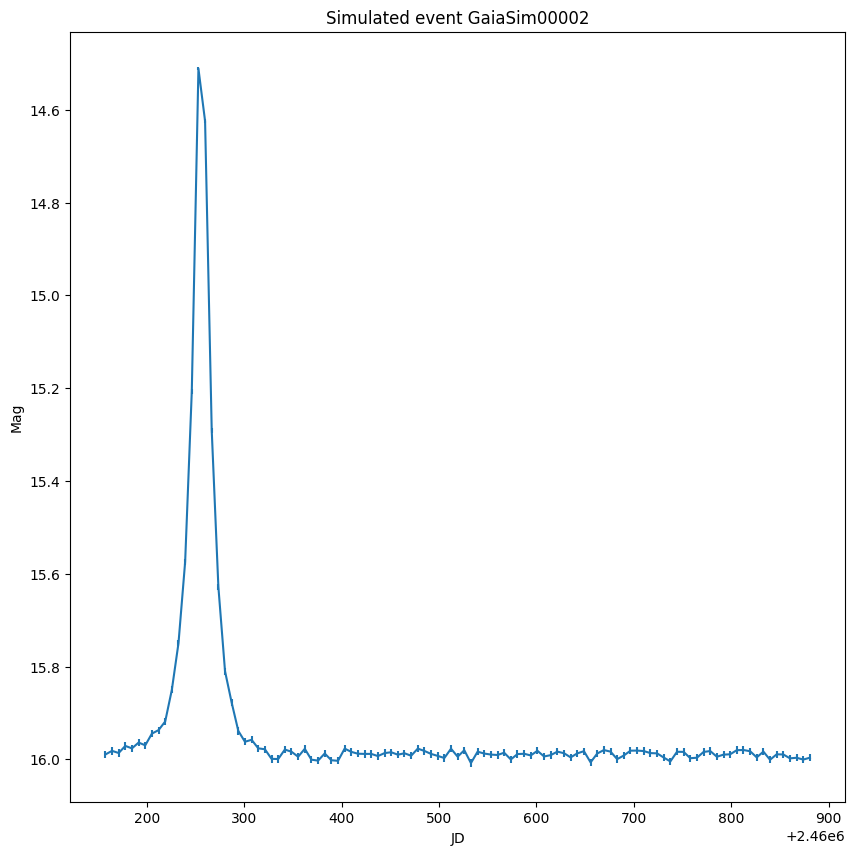

In [28]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = sim_gaia_lenses[event_number].telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
#xmin = float(events_table[event_number]['t0']) - 2*float(events_table[event_number]['te'])
#xmax = float(events_table[event_number]['t0']) + 2*float(events_table[event_number]['te'])
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [29]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

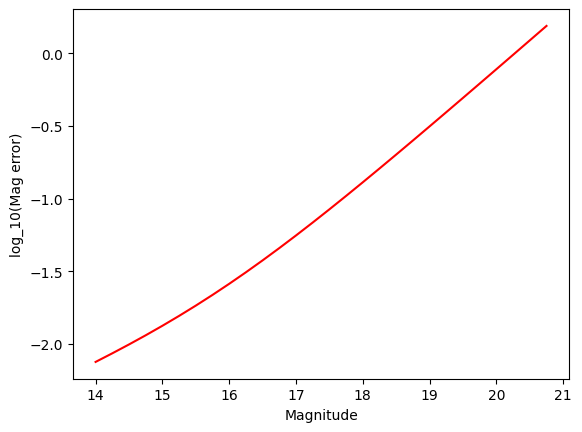

In [30]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [31]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [32]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [33]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated Gaia events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [34]:
def simulate_lco_observations(gaia_event, gaia_model, gaia_model_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    gaia_lc = gaia_lens.telescopes[0].lightcurve_magnitude
    if len(gaia_lc) == 0:
        return gaia_event
    
    mag_threshold = 17.5
    bright_data = np.where(gaia_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(gaia_lc[:,1].min())+' no LCO observations')
        return gaia_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = gaia_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = gaia_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(gaia_event.ra, gaia_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = gaia_lc[:,0].min()
    end_jd = gaia_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (gaia_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = gaia_lc[idx,0].min()
            pre_peak_end = gaia_lc[idx,0].max()
            cadence = 1.0 # days
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = gaia_lc[:,0].min()
            pre_peak_end = gaia_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = gaia_lc[idx,0].min()
            post_peak_end = gaia_lc[idx,0].max()
            cadence = 1.0 # days
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = gaia_lc[:,0].max()
            post_peak_end = gaia_lc[:,0].max()
            
        # Peak observations
        cadence = 1.0/24.0
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        ts = np.concatenate((ts1,ts2,ts3))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return gaia_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for Gaia
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(gaia_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    gaia_event.telescopes.append(tel)
    
    if parallax:
        gaia_model.event.compute_parallax_all_telescopes(gaia_model.parallax_model)
        
    tel = gaia_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = gaia_model.compute_pyLIMA_parameters(gaia_model_params)
    magnification = gaia_model.model_magnification(tel, pylima_parameters)
    A = gaia_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)
    lc = np.delete(lc, idx, axis=0)
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    gaia_event.telescopes[1] = tel
    
    return gaia_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [35]:
gaia_lens = sim_gaia_lenses[event_number]
gaia_lens_model = sim_gaia_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_gaia_event = simulate_lco_observations(gaia_lens, gaia_lens_model, lens_model_pars, visibility_data)

Event model parameters:  2460254.8075024607 0.24901520429909874 18.67553217077708 0.012484655286869947 0.6293397692883446 0.18130525322289273
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID      HP                              location                             baseline_mag         t0                  u0                 te                rho                 piEN                piEE        nvisits
------------ ----- ---------------------------------------------------------------- ------------ ------------------ ------------------- ----------------- -------------------- ------------------ ------------------- -------
GaiaSim00002 29516 <SkyCoord (ICRS): (ra, dec) in deg\n    (286.875, -11.41515556)>        15.99 2460254.8075024607 0.24901520429909874 18.67553217077708 0.012484655286869947 0.6293397692883446 0.18130525322289273     107


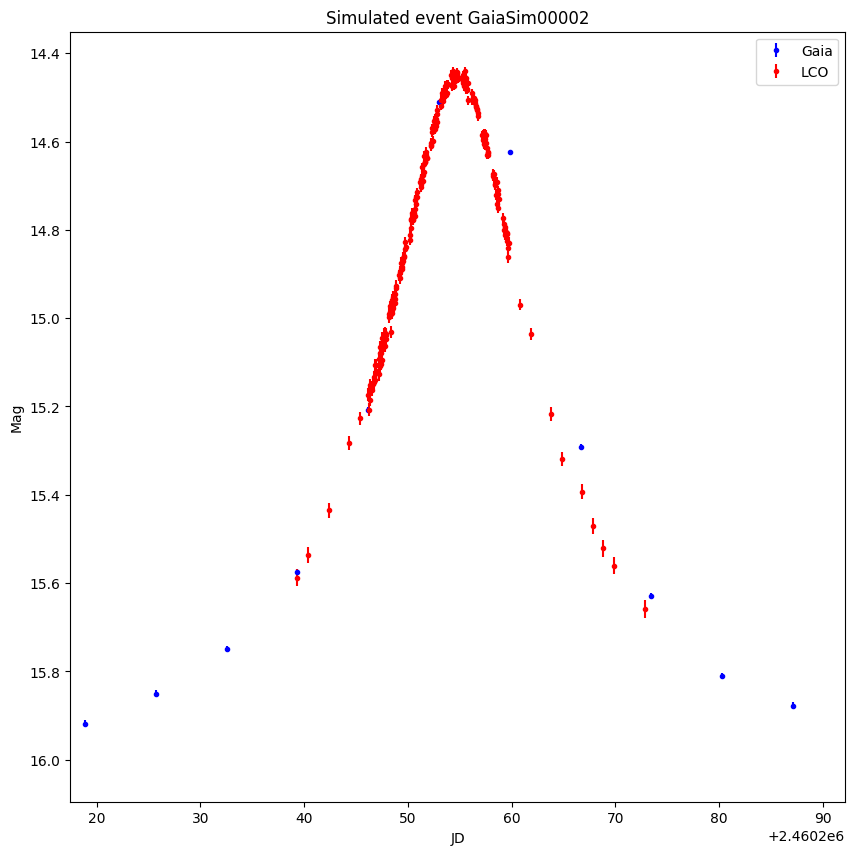

In [37]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_gaia_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='Gaia', fmt='b.')
lc2 = updated_gaia_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])
plt.savefig('GaiaSim00002_lc.png')

We can now simulate LCO observations for the full set of simulated Gaia events

In [38]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_gaia_event = simulate_lco_observations(sim_gaia_lenses[ievent], 
                                                   sim_gaia_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   visibility_data)
    simulated_events_list.append(updated_gaia_event)

Event model parameters:  2460712.499849947 0.6400673917586376 12.268323874505624 0.020228023587556224 0.3496019068355115 -0.3939170508394604
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460254.8075024607 0.24901520429909874 18.67553217077708 0.012484655286869947 0.6293397692883446 0.18130525322289273
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460803.229195148 -0.21485779306280658 98.50266609271823 0.014597254095848831 0.16204148801250326 -0.03856918210976346
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460585.0121493316 -0.1245471904853854 24.25802278756786 0.02987161322083834 0.5753779909199362 0.21519321021228777
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460305.7681900933 0.09025144977122407 38.25380449399144 0.00720238349282996 0.39286846657381747 0.004634455922137036
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event mod

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460223.854534576 0.07652231228273113 38.95518913603663 0.014958509517094827 1.569676955528475 0.2713446793973674
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460689.84596018 -0.16278042691040798 5.661519566877567 0.02589754585940235 -0.9328994318456336 -0.6019827234486053
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460749.5543046477 -0.19390010753428236 64.7438881250031 0.012272241570305284 -0.251439043530704 -0.5578955469658177
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460597.611157536 0.2763719784759515 25.978105000159506 0.01883419994939211 -0.6289059261421517 -0.18007280182332827
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460264.055197021 0.002561466533540585 38.47338288317531 0.008750521825715977 -0.2781337435419647 -0.07308327317615992
Parallax(Ful

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460884.2327286256 0.3297345836783982 114.63283379673882 0.016531816429444054 0.3862654801914067 -0.0935286226107126
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460382.2375525227 0.060262531252215826 32.82639966345851 0.006741881027895729 1.5262450414680018 0.4065370731661246
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460390.132399391 0.2022114809814832 12.162284624052694 0.01708349857198134 -0.5768850420835858 0.37468375355042116
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460390.9283435643 0.1228964611954764 7.683117619843311 0.03336520857369123 -0.15065847239114943 -0.0032137782404136547
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460547.2551300023 0.16655783046838876 17.664403656869478 0.0012441644657172051 0.01642127996307849 -0.026633576537015334
Par

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460789.6805343144 -0.5190833006071486 74.54594520481547 0.022906750904671407 1.3059062529419203 -0.28018564667541807
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460552.73383736 -0.19861964706859728 8.537279397556894 0.004067109813443017 -0.09331592524140986 0.375345565911988
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460883.473084205 0.45348355559327613 40.47426555889104 0.04755562194416276 0.02788558348557435 0.3341570952868215
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460199.7343904176 0.5627123304590267 44.43556391257389 0.0009272751710638861 0.005273843875630152 -0.008879422022738157
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460296.2548685702 0.05437801154468558 9.559873781104164 0.022999430539922955 -0.5911995547780218 0.2842743578344143
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460434.1209457153 -0.23216812490519503 13.217067894258893 0.01256502362437999 1.2964360167343782 0.3885094580760016
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460696.1767004076 -0.07249521457072297 29.231615350153973 0.016590676242775083 -2.1008909252297725 0.05329669403927701
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460328.61801858 -0.2296644060669876 57.3726292888166 0.0034967183129409884 1.5325145951209773 0.2009031893666244
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460786.316213669 -0.45180880559015923 85.99487332612978 0.026941435063800194 -0.4198825139865923 0.5011433710437321
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460270.3712502434 0.3375657787416335 57.02182311533532 0.00020797584522940296 -0.7288512341825071 0.17957470550987403
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460817.314174623 0.25659723573631393 9.46226052274059 0.005118036519024387 0.7638933983201133 -0.22812154689050193
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460465.8814120395 -0.03199153249924189 20.01638081783286 0.0002997071513918051 1.8084426972246084 0.15112968520403122
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460794.1677098237 -0.06776761055663783 30.55120748204352 0.014787882163756611 1.5449396961696789 0.2927406908613264
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460675.066019662 0.20289472394267807 36.15547442952214 0.01046722060463663 0.03302419014066482 0.03962767653852644
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460231.7014291515 0.024830851626420083 24.849894602658697 0.014845264794123658 0.11911123855331773 0.6086073559145015
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460859.4245194504 0.33765157387319006 5.614634725594742 0.007738910892292759 -2.8309652787758544 -0.46413226068230257
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460363.9988498404 0.6043691079064532 17.939221470573454 0.005899007533742711 2.247663546436753 -0.49147403796539385
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460493.0969577297 -0.1350374554592518 16.64054160167118 0.0007559515150361833 0.4874455364055954 0.3080623379687412
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460572.7329019965 0.09976855775767196 54.08439136910063 0.009508591937689615 -0.1490850392666545 0.1113087899482966
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460251.28548868 -0.22702464754548055 11.55355605100259 0.004592494376420061 1.1446170328059477 -0.2675442179618251
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460548.8744050264 -0.17847958115311505 185.53917532334376 0.016356530573893586 0.46185339304270784 0.13340728692280784
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460354.702533419 0.6708921273118318 3.1399191855919937 0.021166776695195066 -0.14472178204873337 0.35077501216579166
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460836.2244367287 0.5083165426085628 16.72575759218188 0.011510344317860481 0.03935416785593224 -0.13693460333585616
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460508.096543663 0.21220059415859555 33.25567004544853 0.009973137064264047 -0.1399205150233006 0.4683201498830185
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460566.258813632 0.07488868138788085 12.964616217863474 0.023753469492241927 0.07730911978016822 0.1350449421008474
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460411.8995702467 -0.09655326304152526 21.868079932559862 0.012214870821174036 -0.12190109527073956 0.07174444945223646
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460556.422441843 0.07715879537524671 15.740674642470447 0.01194413999118149 -0.03995676248528812 -0.005743548754961927
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460339.150149178 0.3301928424419307 49.85723778767825 0.015014085454102957 -0.7059730975567469 -0.16549388724687553
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460658.092784042 0.5066088660503022 78.92021211762804 0.03176688446780508 -0.16842826275319694 0.11517735450702696
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460692.3198755407 0.5852558210723726 74.4286878629672 0.0014523375000860123 0.692387700711594 0.21306849473707665
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460624.9322604383 0.5324752261951059 1.4109638471835648 0.014322690770101613 1.5954866202373794 -0.07112584041838388
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460773.34882115 0.14583474471198132 40.23536053556235 0.013585287831253472 -0.03571719061973072 0.03830945983309823
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460364.299197866 0.016603869730566517 70.30434318479017 0.0030423465438698064 -0.8487647631039308 0.18076254573103123
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460442.9127146066 0.5545622456916132 51.77509046793289 0.02346581587580946 1.615462822809958 -0.025126088123484568
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460547.145104314 0.09309187903341372 20.402475815851254 0.0009279992663286931 0.10999424601525182 0.4133809227695201
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460415.838515888 -0.020445000460888513 128.94942277578093 0.02517786850225299 -0.11807918976135706 0.1743749761201337
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460558.6614978737 0.043496666716493326 20.813041200776908 0.005883836873616077 0.2540630252285985 -0.06645773427283833
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460342.72341594 0.2441964290392219 33.49418443913902 0.0027762658797181646 -0.9689557818721626 -0.3038287740569819
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460190.986616101 -0.32249573991578906 19.903363419194037 0.014115099974303902 0.6869127637925085 0.20342226987985831
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460766.910508659 0.011720129527179574 65.96871988537374 0.021831151608058354 0.0343887109587131 0.43362451598559726
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460188.5087337876 -0.11090008273342258 51.59205205668506 0.0011353353566061573 0.7296337452452963 -0.05384911596716185
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460165.868693634 0.8355192657915431 24.096719251177145 0.017873043352653994 -0.2608282323390231 0.1775438545733173
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460542.1064126743 0.17867299578983303 6.765510314569992 0.007346559985717682 -0.8855984839323052 0.1687556035314114
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460853.711607573 0.5110819715263374 18.191672741990793 0.018446840967227533 0.24404435543424666 -0.011514145641955909
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460333.4737558435 -0.07834017054785566 30.892456131079157 0.02109847031488782 0.3328019323064021 -0.19783521330286524
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460680.654187284 0.039072743935835305 16.97787846947016 0.024417465312832738 -0.5335881715516753 0.32849645305887404
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460443.994886178 0.23803833899592558 71.83216865300913 0.013504671909327972 -1.47840125648505 -0.6907403605684223
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460165.6867271164 0.20641969823066075 40.36912955237024 0.006160837580695225 -0.4840953998228114 0.36327045714867257
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460410.7419253713 -0.2425736753551704 22.4311999317849 0.007040816101550446 -0.7603050317253424 0.3170393306134804
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460217.050373482 -0.15905959337569273 54.532837930739746 0.012625973282153187 0.43407142841593876 0.4205129251469664
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460677.3406949854 0.3338291379314646 32.37165262804109 0.021045614578487054 1.1448356576404226 -0.04738959075138444
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460272.9166778773 0.03890870683856723 6.60407081130423 0.021028955664627917 1.2086388394617469 -0.16615627035226427
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460292.372876651 0.23609751893182412 15.547828721456924 0.001565953636087621 0.9041991999406553 -0.39648762358728923
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460644.811240898 0.10841767586501246 167.0942448457323 0.026916346981922815 0.07551528025983917 0.278564244761388
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460350.9988890463 -0.008345349175048644 77.41191536044927 0.01705598931304074 0.25672694757343667 -0.03830304244289772
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460465.562583166 0.2915074228609157 188.24609523440546 0.008504285069333374 0.5086226165858385 0.2538614041906967
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460884.1562047075 0.20200519888429014 17.666431690621074 0.015048284108614467 0.46672724625687956 0.4040622152717832
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460672.2616067864 0.8217032553495079 12.08976800558221 0.006333543192734671 0.3289608714615353 0.16932551435536577
No viable times for LCO observations
Event model parameters:  2460633.3137807245 0.12212015592552836 12.490382752526125 0.0287401319000804 0.06869606328819518 0.412486204194985
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460659.5699772774 -0.29271131305794973 10.187275989833 0.016335703771749352 0.17329220046021146 0.41560977083448386
Parallax(Full) estimated for the 

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460597.772181928 0.1910327803696717 85.06706143252828 0.016376242389539344 0.38755835925066046 -0.2530480022269123
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460588.319795852 0.21452828362228735 82.71657073585214 0.010323579913792664 0.7013298846047584 -0.2145211533645904
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460786.7941564163 0.35716371467259944 12.22825941329045 0.01994776754581401 0.4345646532050985 0.17192727324524082
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460535.4606479662 -0.13498993451646865 23.15578888295877 0.014966513484397702 0.21348053458262717 -0.3358542796635307
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460686.4118364127 0.7893855507121708 22.888005528707826 0.002589283587251554 -0.08101882272331284 0.1495894283829898
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460504.2479504338 0.30661512385741313 8.550040274127404 0.013061805875488655 0.878380864324767 0.16981922504445207
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460594.634922069 0.21090501524967264 53.09718844195375 0.003689554822234241 -1.0943298306673288 0.02869679859192262
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460232.140818677 0.4946024050923542 14.521562198873783 0.0028593282894590084 -1.4543744532825247 0.21906674816494323
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460236.2309393897 0.6028001401075981 6.250767660723282 0.010794034137193842 1.21571702435268 0.4612081942461996
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460689.2061663195 -0.017489923733451013 7.211358080641875 0.029777221197813314 -0.8077940454312742 -0.09874236057716199
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460412.348043156 0.2217200192979287 18.11506602011405 0.022299419982363802 -0.2041537339229504 -0.21036870705701713
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460379.8367668586 -0.07689682205535137 26.372501377906403 0.014097350724353011 0.4256400961845156 0.1211261543343666
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460878.8008422744 0.7206144804425747 58.054828998041 0.010843901078618315 1.0365286207232436 0.4858197232309706
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460607.2376725455 0.6736204606320652 33.66818730061308 0.004009826911359361 0.2878909524310995 -0.2928994378185142
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460437.741774394 0.5087839335988942 12.682062094662111 0.006313496410404011 0.8896260002553837 -0.11468078882880242
Parallax(Full)

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460732.7976826597 0.07196505751120603 64.09436755795689 0.028531232858223322 0.7271281574464112 0.3853725275713158
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460450.0507512474 0.2735593042736151 12.091343674682365 0.03795189853850167 1.0065627828283974 0.15602565330546622
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460277.411776266 0.2562279573948601 67.2499387010107 0.0011316360260232028 0.28234492378725085 0.3615245177889428
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460847.625899037 0.42167097415489796 18.248302896386047 0.006232480243977859 -0.16134078663381218 -0.10526984552529992
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460515.7658947036 0.28631006478016496 87.93467625607452 0.005793481505550096 0.6187733530341007 -0.08955641467910624
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460369.041068248 0.2987131736062186 8.557501520764145 0.015478676347437926 0.5227080771314795 0.3063422165795059
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460181.8939117957 0.35227747227704376 32.56873933211263 0.021515120550521148 -0.6478159101600043 -0.16821360628690193
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460540.703896995 0.4445799902542771 18.46540678410188 0.006635871892078642 0.5556186737872959 -0.3148622012200496
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460814.1989241205 0.45342750022079437 16.65509555471598 0.022653897381751262 0.6918797508459666 -0.28743704588487196
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460261.2610704466 0.33146502492575813 51.68219869103682 0.013869515779325551 1.6051870357392664 0.07013616148964157
Parallax(Ful

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460510.8002980053 -0.1724966940164467 16.503044556467813 0.012522925783284098 -0.5954652647522469 -0.10007197879828805
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460712.3247185587 0.12342252965622177 204.65070445302135 0.01100536222861383 0.6861843742002771 0.07247140158426921
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460662.7410784876 0.4577035136573516 8.398154381807363 0.02426986800905675 1.0536097691663993 0.24990325135260352
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460682.535746595 -0.27271214365426766 24.380850758206634 0.007536032874311526 0.17380267988366252 0.2985764072148607
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460504.1656346 -0.09952437257760477 26.048182787208056 0.0007707845119112166 1.1877524027436797 0.3890612200029499
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460694.814057132 -0.05999506122136175 20.430482193294484 0.016198992801368422 0.4677675253808274 -0.2255961653469911
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460606.013873182 0.4013457191640848 9.438539045298649 0.01558977006855602 0.23658551057448915 0.4125649597264828
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460853.8638265813 -0.09458477207840277 37.2617225707994 0.012396670086256726 0.02066045902015548 0.11583023063644471
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460435.2747046063 -0.17282220789243422 114.56085357799944 0.02090420243639894 -0.5521590477539371 0.31113095435603433
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460334.692876617 0.9224011002117707 25.209646490533643 0.005337969628193237 0.15803020732166115 -0.21909784844249228
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460371.3013037634 -0.16067225206756294 17.24831889808457 0.03347416224950062 1.169871244028697 0.11188899613492864
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460689.3569651265 -0.13155571561535975 17.70653450492447 0.005719904167864257 0.31524132914272296 -0.5887766084900831
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460534.9636091837 -0.42264876438502985 57.74833070439497 0.0016897055758236948 -0.14464413707212448 -0.3517626470055185
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460562.059997595 -0.6424778266412906 44.89080154693726 0.003918458057067208 0.20208673095816684 -0.1626706784973329
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460505.04668594 0.43877210709877557 102.05944598238827 0.007990429789697526 -0.8365750155246969 -0.13658424626414242
Para

In [39]:
file_path = 'simulated_lco_lightcurves_gaia_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [40]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [41]:
def fit_event_model(event_params, model_type, horizons_table, gaia_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=gaia_lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel1.spacecraft_positions = spacecraft_positions
    
    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('Gaia')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['Gaia', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [42]:
gaia_lc = updated_gaia_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_gaia_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, horizons_table, gaia_lc, lco_lc)

  EventID      HP                              location                             baseline_mag         t0                  u0                 te                rho                 piEN                piEE        nvisits
------------ ----- ---------------------------------------------------------------- ------------ ------------------ ------------------- ----------------- -------------------- ------------------ ------------------- -------
GaiaSim00002 29516 <SkyCoord (ICRS): (ra, dec) in deg\n    (286.875, -11.41515556)>        15.99 2460254.8075024607 0.24901520429909874 18.67553217077708 0.012484655286869947 0.6293397692883446 0.18130525322289273     107
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00002, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [43]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        gaia_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, horizons_table, gaia_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 204.382
DE converge to objective function : f(x) =  204.3802492124741
DE converge to parameters : =  ['2460712.499549947' '0.6403673917586375' '12.268623874505623'
 '0.019928023587556222' '0.34990190683551153' '-0.39361705083946036']
trust_region_reflective  : TRF fit SUCCESS
[2460712.499549963, 0.6403673917586373, 12.268623874505533, 0.019928023587556243, 0.3499019068355069, -0.39361705083946474, 893.758498296169, 22.08009001521511, 35859.48939760529, 1403.785926105355, 204.38024952595325]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460712.499549963,

DE converge to objective function : f(x) =  777.4008168058834
DE converge to parameters : =  ['2460579.0126759117' '0.6642683268303013' '66.9622075954547'
 '0.007401354174728398' '0.2440326439555234' '0.1841496188728329']
trust_region_reflective  : TRF fit SUCCESS
[2460579.0126758707, 0.6642685436821785, 66.96220759545453, 0.0074013541747466735, 0.2440326439555057, 0.18414961887284964, 1405.2494558923395, 57.95171156274033, 37017.93697510554, -419.21713110086364, 777.4008175860388]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460579.0126758707, 0.6642685436821785, 66.96220759545453, 0.0074013541747466735, 0.2440326439555057, 0.18414961887284964, 1405.2494558923395, 57.95171156274033, 37017.93697510554, -419.21713110086364, 777.4008175860388]
t0: Fitted value=2460579.0126758707+/-0.21751163857476463 expected value=2460579.0123759117
t0: delta=0.0002999589778482914 prop_delta=1.2190585075284938e-08% within_range? True
te: 

differential_evolution step 1: f(x)= 119.426
DE converge to objective function : f(x) =  119.42487248984435
DE converge to parameters : =  ['2460665.031693757' '0.42012865155725904' '20.448925824398916'
 '0.012902060399681876' '0.029728807892934368' '0.23002601107475382']
trust_region_reflective  : TRF fit SUCCESS
[2460665.031674328, 0.42012865155725826, 20.44892582436897, 0.0129020604019487, 0.029728807892551203, 0.2300260110771064, 2353.1833487142576, -49.13538499327985, 38283.72202723146, -2302.285588802566, 119.42487713015375]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460665.031674328, 0.42012865155725826, 20.44892582436897, 0.0129020604019487, 0.029728807892551203, 0.2300260110771064, 2353.1833487142576, -49.13538499327985, 38283.72202723146, -2302.285588802566, 119.42487713015375]
t0: Fitted value=2460665.031674328+/-9.11429998742919 expected value=2460665.031393757
t0: delta=0.00028057070448994637 prop_delta=1.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00014, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 11088.5
DE converge to objective function : f(x) =  11088.459379794851
DE converge to parameters : =  ['2460341.0318574766' '-0.2773646464482646' '6.0775618473561295'
 '0.012900221840797877' '0.34636447343396176' '0.21927350136567558']
trust_region_reflective  : TRF fit SUCCESS
[2460341.031741542, -0.2773646464547625, 6.07756184733229, 0.012900221834136166, 0.3463644734334618, 0.21927350136344897, 14588.745748906651, -15.563399754028854, 36665.41787527982, 105.46664628473306, 11088.459853138633]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460341.031741542, -0.2773646464547625, 6.07756184733229, 0.012900221834136166, 0.3463644734334618, 0.21927350136344897, 14588.745748906651, -15.563399754028854, 36665.4178752

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00018, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 155.654
differential_evolution step 2: f(x)= 155.654
differential_evolution step 3: f(x)= 155.654
differential_evolution step 4: f(x)= 155.654
DE converge to objective function : f(x) =  155.48120066825004
DE converge to parameters : =  ['2460677.6823880454' '0.03176995355966517' '49.254436826854274'
 '0.00027131481135212425' '-1.5214557659290013' '0.3073818233242765']
trust_region_reflective  : TRF fit SUCCESS
[2460677.682252885, 0.031769953559665165, 49.25443682239163, 0.00027131481135212425, -1.5214557659286356, 0.3073818233364186, 5814.012500080132, 11.39349230730929, 36691.42168859079, 92.68483853200568, 155.50425648213164]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause 

differential_evolution step 1: f(x)= 422.09
DE converge to objective function : f(x) =  421.9756169946218
DE converge to parameters : =  ['2460430.6818704437' '-0.11912243932198124' '17.25679503250812'
 '0.01252743409288094' '0.45007150480446645' '-0.17320029925659575']
trust_region_reflective  : TRF fit SUCCESS
[2460430.6818704433, -0.11912243557537877, 17.256795032508123, 0.012527434092880941, 0.4500715048044665, -0.17320029925659577, 3663.041924649723, -6.4982193207821615, 36668.95067985438, 244.92797831970063, 421.97561729617297]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460430.6818704433, -0.11912243557537877, 17.256795032508123, 0.012527434092880941, 0.4500715048044665, -0.17320029925659577, 3663.041924649723, -6.4982193207821615, 36668.95067985438, 244.92797831970063, 421.97561729617297]
t0: Fitted value=2460430.6818704433+/-0.0029945081023268105 expected value=2460430.681570444
t0: delta=0.00029999949038028717

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00026, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 797.298
DE converge to objective function : f(x) =  797.1994616992681
DE converge to parameters : =  ['2460571.346339721' '0.1414679133086358' '46.53833195364308'
 '0.025382839149175836' '-0.08181154404897165' '0.40884436030380344']
trust_region_reflective  : TRF fit SUCCESS
[2460571.3463397217, 0.1414679307371619, 46.53833195364309, 0.02538283914917584, -0.08181154404897166, 0.4088446092967371, 3640.8351169648076, 17.63105058469602, 36810.20429815167, -149.80328877032832, 797.1994617946334]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460571.3463397217, 0.1414679307371619, 46.53833195364309, 0.02538283914917584, -0.08181154404897166, 0.4088446092967371, 3640.8351169648076, 17.63105058469602, 36810.20429815167,

differential_evolution step 2: f(x)= 756.824
differential_evolution step 3: f(x)= 756.824
differential_evolution step 4: f(x)= 756.773
differential_evolution step 5: f(x)= 756.773
DE converge to objective function : f(x) =  756.6135531359565
DE converge to parameters : =  ['2460390.473686589' '-0.08388103213480484' '55.799312093204044'
 '0.03350956822116156' '0.7270218488495718' '-0.001320697272350976']
trust_region_reflective  : TRF fit SUCCESS
[2460390.473686591, -0.08388094360358496, 55.79931209320404, 0.03350955378239123, 0.7270212361736789, -0.001320697272350968, 23072.117277302812, 36.29839239005226, 36786.6930648787, -0.46198203473561006, 756.613552390448]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460390.473686591, -0.08388094360358496, 55.79931209320404, 0.03350955378239123, 0.7270212361736789, -0.001320697272350968, 23072.117277302812, 36.29839239005226, 36786.6930648787, -0.46198203473561006, 756.61355239044

differential_evolution step 1: f(x)= 179.131
differential_evolution step 2: f(x)= 178.932
differential_evolution step 3: f(x)= 178.919
differential_evolution step 4: f(x)= 178.919
differential_evolution step 5: f(x)= 178.919
DE converge to objective function : f(x) =  178.88126067244517
DE converge to parameters : =  ['2460698.744472992' '0.03994055644018742' '16.051429559872727'
 '0.0005737217930427349' '0.11138531171463777' '0.047253517462589455']
trust_region_reflective  : TRF fit SUCCESS
[2460698.7444729926, 0.039940558864023305, 16.05142955987273, 0.000573721793042735, 0.11138488324139595, 0.04725351746258945, 1457.5358047860134, 2.658527761415277, 36920.793801766915, -618.9162472563874, 178.88126115700553]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460698.7444729926, 0.039940558864023305, 16.05142955987273, 0.000573721793042735, 0.11138488324139595, 0.04725351746258945, 1457.5358047860134, 2.658527761415277, 3692

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00039, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 555.954
DE converge to objective function : f(x) =  555.4887942405988
DE converge to parameters : =  ['2460424.509306427' '-0.20106722937721166' '10.523138375921922'
 '0.006513857659768803' '0.14073675359651105' '0.2024301542431431']
trust_region_reflective  : TRF fit SUCCESS
[2460424.5093064266, -0.20106722937721164, 10.523138375921924, 0.0065138576597688035, 0.14073675359651108, 0.20243015424314312, 91880.10937915811, 143.15406126441465, 36816.44053693918, -110.29336826477349, 555.4887942703879]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460424.5093064266, -0.20106722937721164, 10.523138375921924, 0.0065138576597688035, 0.14073675359651108, 0.20243015

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00043, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 524.904
DE converge to objective function : f(x) =  524.8971446342803
DE converge to parameters : =  ['2460223.2761038058' '0.5609230309139129' '46.779767482933'
 '0.01618469804453765' '1.5221786583786192' '0.39131235215486876']
trust_region_reflective  : TRF fit SUCCESS
[2460223.2761038044, 0.5609230309139128, 46.77976748293297, 0.016184698044537652, 1.5221786583786199, 0.39131235215486854, 8866.926196723232, 340.73293390259875, 36359.62295047856, 745.8984507195751, 524.8971446578806]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460223.2761038044, 0.5609230309139128, 46.77976748293297, 0.016184698044537652, 1.5221786583786199, 0.39131235215486854, 8866.926196723232, 340.73293390259875, 36359.62295047856, 745.8

differential_evolution step 1: f(x)= 433.95
differential_evolution step 2: f(x)= 433.95
differential_evolution step 3: f(x)= 433.95
differential_evolution step 4: f(x)= 433.936
differential_evolution step 5: f(x)= 433.936
differential_evolution step 6: f(x)= 433.936
differential_evolution step 7: f(x)= 433.936
differential_evolution step 8: f(x)= 433.936
differential_evolution step 9: f(x)= 433.936
differential_evolution step 10: f(x)= 433.936
differential_evolution step 11: f(x)= 433.925
differential_evolution step 12: f(x)= 433.925
differential_evolution step 13: f(x)= 433.925
differential_evolution step 14: f(x)= 433.925
DE converge to objective function : f(x) =  433.9113915060814
DE converge to parameters : =  ['2460562.129686892' '0.5747556241037203' '29.06742748690087'
 '0.0004175631150904099' '-0.10139078891442047' '0.1033059954450279']
trust_region_reflective  : TRF fit SUCCESS
[2460562.12944714, 0.5747556240751736, 29.067427484036866, 0.0004175631150904099, -0.101390788997293

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00052, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 410.071
differential_evolution step 2: f(x)= 408.536
differential_evolution step 3: f(x)= 408.536
differential_evolution step 4: f(x)= 407.728
differential_evolution step 5: f(x)= 407.728
differential_evolution step 6: f(x)= 407.728
differential_evolution step 7: f(x)= 406.971
differential_evolution step 8: f(x)= 406.971
differential_evolution step 9: f(x)= 406.971
differential_evolution step 10: f(x)= 406.971
differential_evolution step 11: f(x)= 406.956
differential_evolution step 12: f(x)= 406.956
differential_evolution step 13: f(x)= 406.956
differential_evolution step 14: f(x)= 406.766
differential_evolution step 15: f(x)= 406.766
differential_evolution step 16: f(x)= 406.766
differential_evolution step 17: f(x)= 4

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00057, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 488.293
DE converge to objective function : f(x) =  488.2917845719629
DE converge to parameters : =  ['2460553.4208480096' '0.7724181037551096' '13.34452681063227'
 '0.010303892155734174' '-0.11830853444454162' '-0.06911583555737133']
trust_region_reflective  : TRF fit SUCCESS
[2460553.4208492786, 0.7724181038329758, 13.34452681194963, 0.010303892056143732, -0.11830853435147183, -0.0691158356504697, 957.2435812023749, -44.19041214483312, 37231.44253823584, -711.7855564413084, 488.2918256178818]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460553.4208492786, 0.7724181038329758, 13.34452681194963, 0.010303892056143732, -0.11830853435147183, -0.0691158356504697, 957.2435812023749, -44.19041214483312, 37231.4425382

differential_evolution step 1: f(x)= 767.939
differential_evolution step 2: f(x)= 767.939
differential_evolution step 3: f(x)= 767.509
differential_evolution step 4: f(x)= 767.451
differential_evolution step 5: f(x)= 767.451
differential_evolution step 6: f(x)= 767.451
differential_evolution step 7: f(x)= 767.451
differential_evolution step 8: f(x)= 767.451
DE converge to objective function : f(x) =  767.2192338387827
DE converge to parameters : =  ['2460756.0841972497' '-0.12670176326325364' '82.23046318255058'
 '0.0170305922752753' '0.1987901795121589' '0.4622860770894042']
trust_region_reflective  : TRF fit SUCCESS
[2460756.08419725, -0.12670168128491976, 82.23046318255061, 0.01703040819944413, 0.1987900998358816, 0.46228607708940445, 3666.5583000316965, -13.307138984644448, 36767.370424335066, -28.806428443726112, 767.219233738663]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.08419725, -0.12670168128491976, 82

differential_evolution step 1: f(x)= 464.813
DE converge to objective function : f(x) =  464.7948989354332
DE converge to parameters : =  ['2460776.7965875794' '0.5737522879158192' '37.34830517130125'
 '0.015051319158450694' '-0.5220699965218911' '-0.391537902417652']
trust_region_reflective  : TRF fit SUCCESS
[2460776.7965875734, 0.5737522879158172, 37.34830517130122, 0.015051319158454738, -0.5220699965218925, -0.3915379024176537, 3729.012120583857, -76.27802271333972, 36610.3976749449, 207.82987544530707, 464.7948989659185]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460776.7965875734, 0.5737522879158172, 37.34830517130122, 0.015051319158454738, -0.5220699965218925, -0.3915379024176537, 3729.012120583857, -76.27802271333972, 36610.3976749449, 207.82987544530707, 464.7948989659185]
t0: Fitted value=2460776.7965875734+/-0.14230625692495286 expected value=2460776.7962875795
t0: delta=0.0002999939024448395 prop_delta=1.21

DE converge to objective function : f(x) =  310.53865781711335
DE converge to parameters : =  ['2460692.6343188887' '0.06653952948284629' '32.15978253653259'
 '0.016584004246446023' '-0.4526074390604594' '0.3771263378953098']
trust_region_reflective  : TRF fit SUCCESS
[2460692.634318537, 0.06653844793601466, 32.160376727651844, 0.016584004246446026, -0.45260743906045936, 0.37712633789530986, 2329.719445137882, -33.190028070884445, 36709.84551430874, 33.07100746241682, 310.53858537521216]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460692.634318537, 0.06653844793601466, 32.160376727651844, 0.016584004246446026, -0.45260743906045936, 0.37712633789530986, 2329.719445137882, -33.190028070884445, 36709.84551430874, 33.07100746241682, 310.53858537521216]
t0: Fitted value=2460692.634318537+/-0.0035868316552336464 expected value=2460692.6340188887
t0: delta=0.00029964838176965714 prop_delta=1.2177399876239764e-08% within_range?

differential_evolution step 1: f(x)= 1161.98
DE converge to objective function : f(x) =  1161.8888701626452
DE converge to parameters : =  ['2460794.7258417616' '-0.328517418188291' '73.62431311773769'
 '0.006559862307576445' '-0.004632162153349962' '-0.45524778929404175']
trust_region_reflective  : TRF fit SUCCESS
[2460794.7258419334, -0.32851741818831687, 73.62431311774199, 0.006559862307551958, -0.004632162153399375, -0.45524778929403925, 1459.788740295271, -6.800681790187736, 36651.3915863497, 287.3795866515847, 1161.8888737290779]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460794.7258419334, -0.32851741818831687, 73.62431311774199, 0.006559862307551958, -0.004632162153399375, -0.45524778929403925, 1459.788740295271, -6.800681790187736, 36651.3915863497, 287.3795866515847, 1161.8888737290779]
t0: Fitted value=2460794.7258419334+/-0.0312953338492041 expected value=2460794.7261417615
t0: delta=0.0002998281270265579 p

differential_evolution step 1: f(x)= 426.698
DE converge to objective function : f(x) =  426.61086444674936
DE converge to parameters : =  ['2460574.3226756696' '0.31091389707857026' '21.83936817916797'
 '0.010918426306347775' '0.304437031848504' '-0.004945824154034552']
trust_region_reflective  : TRF fit SUCCESS
[2460574.32267567, 0.31091389707857126, 21.839368179167973, 0.010918426306346816, 0.30443703184850407, -0.004945824154034604, 3652.974734732982, 9.036734706826625, 36429.058262646766, 975.7662738246254, 426.6108645250725]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460574.32267567, 0.31091389707857126, 21.839368179167973, 0.010918426306346816, 0.30443703184850407, -0.004945824154034604, 3652.974734732982, 9.036734706826625, 36429.058262646766, 975.7662738246254, 426.6108645250725]
t0: Fitted value=2460574.32267567+/-0.02310913458541837 expected value=2460574.3229756695
t0: delta=0.00029999949038028717 prop_delt

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00081, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 598.352
differential_evolution step 2: f(x)= 598.352
differential_evolution step 3: f(x)= 597.107
differential_evolution step 4: f(x)= 597.04
differential_evolution step 5: f(x)= 597.04
differential_evolution step 6: f(x)= 597.04
differential_evolution step 7: f(x)= 597.04
differential_evolution step 8: f(x)= 597.04
differential_evolution step 9: f(x)= 597.04
differential_evolution step 10: f(x)= 596.538
differential_evolution step 11: f(x)= 596.538
differential_evolution step 12: f(x)= 596.337
differential_evolution step 13: f(x)= 596.337
differential_evolution step 14: f(x)= 595.773
differential_evolution step 15: f(x)= 595.773
differential_evolution step 16: f(x)= 595.773
differential_evolution step 17: f(x)= 595.773
differential_evolution step 18: f(x)= 595.773
differenti

differential_evolution step 1: f(x)= 1125.97
DE converge to objective function : f(x) =  1125.9098673848714
DE converge to parameters : =  ['2460533.310258641' '0.3639881362524796' '60.81114891266148'
 '0.0017781349198699027' '0.2961176469686692' '0.19434479044288316']
trust_region_reflective  : TRF fit SUCCESS
[2460533.310498284, 0.3639881362529796, 60.8111489186883, 0.0017781349198699027, 0.2961176470661873, 0.19434479035086602, 14522.895260073004, 75.37150972983798, 36783.369397100214, -169.17601954256543, 1125.9285013064311]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460533.310498284, 0.3639881362529796, 60.8111489186883, 0.0017781349198699027, 0.2961176470661873, 0.19434479035086602, 14522.895260073004, 75.37150972983798, 36783.369397100214, -169.17601954256543, 1125.9285013064311]
t0: Fitted value=2460533.310498284+/-0.041024280172392194 expected value=24605

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00089, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 11355.8
DE converge to objective function : f(x) =  11355.770873037363
DE converge to parameters : =  ['2460695.9360573348' '0.5142928431568295' '5.352453008925728'
 '0.003100716124577387' '1.3146277838348877' '-0.11428950416430311']
trust_region_reflective  : TRF fit SUCCESS
[2460695.935814547, 0.5142928431573296, 5.352453009402306, 0.003100716124577387, 1.314627783734927, -0.11428950424172603, 3756.108070346642, -92.01240823970994, 36581.14099511398, 162.10940866654784, 11355.771022032857]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460695.935814547, 0.5142928431573296, 5.352453009402306, 0.003100716124577387, 1.314627783734927, -0.11428950424172603, 37

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00093, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 2855.4
DE converge to objective function : f(x) =  2855.3801899984132
DE converge to parameters : =  ['2460390.928643564' '0.12316230277226684' '7.683355949245464'
 '0.033237499262922396' '-0.15035847239114944' '-0.002913778240413655']
trust_region_reflective  : TRF fit SUCCESS
[2460390.928616864, 0.12319056994283253, 7.683417606078702, 0.0336618669930567, -0.15035847239115188, -0.002913778240461259, 1463.4406468106422, -22.48302809891457, 36804.58268415621, -41.814041750862124, 2855.380761179057]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460390.928616864, 0.12319056994283253, 7.683417606078702, 0.0336618669930567, -0.15035847239115188, -0.002913778240461259, 1463.4406468106422, -22.48302809891457, 36804.582

differential_evolution step 1: f(x)= 438.135
DE converge to objective function : f(x) =  438.01597950398605
DE converge to parameters : =  ['2460257.594966575' '-0.16633572726430024' '7.515508154143211'
 '0.0532345749314488' '0.5367006139680245' '0.11384979724643299']
trust_region_reflective  : TRF fit SUCCESS
[2460257.5949665746, -0.16633572726430026, 7.515508154143212, 0.05323457493144879, 0.5367006139680246, 0.113849797246433, 2272.1287091458476, 34.966047302097664, 36668.24255035398, 312.1445920983537, 438.0159796866127]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460257.5949665746, -0.16633572726430026, 7.515508154143212, 0.05323457493144879, 0.5367006139680246, 0.113849797246433, 2272.1287091458476, 34.966047302097664, 36668.24255035398, 312.1445920983537, 438.0159796866127]
t0: Fitted value=2460257.5949665746+/-0.0029525770057438603 expected value=2460257.594666575
t0: delta=0.00029999949038028717 prop_delta=1.21

differential_evolution step 1: f(x)= 277.01
differential_evolution step 2: f(x)= 277.01
differential_evolution step 3: f(x)= 277.01
differential_evolution step 4: f(x)= 277.01
differential_evolution step 5: f(x)= 277.01
differential_evolution step 6: f(x)= 277.01
DE converge to objective function : f(x) =  276.94615935081487
DE converge to parameters : =  ['2460639.781057433' '-0.010690122238338484' '9.781935171056647'
 '0.00995685600492906' '-0.1984332861476044' '0.1585884972584736']
trust_region_reflective  : TRF fit SUCCESS
[2460639.7810574328, -0.010697906649205523, 9.781646829764053, 0.009986903450043407, -0.19843328614760442, 0.15858849725847357, 2318.5694069333754, -13.532872292031072, 36691.457821919714, 150.38160116969703, 276.9456738243502]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460639.7810574328, -0.010697906649205523, 9.781646829764053, 0.009986903450043407, -0.19843328614760442, 0.15858849725847357, 23

differential_evolution step 1: f(x)= 412.071
differential_evolution step 2: f(x)= 412.071
differential_evolution step 3: f(x)= 412.071
differential_evolution step 4: f(x)= 412.071
DE converge to objective function : f(x) =  412.0048364188623
DE converge to parameters : =  ['2460761.616337445' '0.590813367413756' '229.3893525723312'
 '0.02473013745162979' '0.4535085314441311' '0.33902228140904994']
trust_region_reflective  : TRF fit SUCCESS
[2460761.6168893226, 0.5908133674135275, 229.38951549625398, 0.024730137448550054, 0.45350852376064327, 0.3390203216811609, 1470.754225800967, -7.941516614494221, 36862.3837986932, -119.83733331782544, 412.00360245916414]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460761.6168893226, 0.5908133674135275, 229.38951549625398, 0.024730137448550054, 0.45350852376064327, 0.3390203216811609, 1470.754225800967, -7.941516614494221, 36862.3837986932, -119.83733331782544, 412.00360245916414]
t0:

DE converge to objective function : f(x) =  460.4722053952934
DE converge to parameters : =  ['2460364.167492563' '0.3631363643745146' '50.13050912280342'
 '0.003661604807462797' '-0.08806673730261302' '0.4615624653440272']
trust_region_reflective  : TRF fit SUCCESS
[2460364.1674925624, 0.3631368744554447, 50.130509122803424, 0.0037820342312409987, -0.08806673730261301, 0.46156246534402723, 14459.120788809072, 131.68671565021043, 36802.54531429454, -133.80954194040982, 460.48467465515205]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460364.1674925624, 0.3631368744554447, 50.130509122803424, 0.0037820342312409987, -0.08806673730261301, 0.46156246534402723, 14459.120788809072, 131.68671565021043, 36802.54531429454, -133.80954194040982, 460.48467465515205]
t0: Fitted value=2460364.1674925624+/-0.043046413040712626 expected value=2460364.167192563
t0: delta=0.00029999949038028717 prop_delta=1.219329619495338e-08% within_rang

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00113, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 9517.69
DE converge to objective function : f(x) =  9517.622927535109
DE converge to parameters : =  ['2460701.871456063' '0.11460575844073459' '4.709310719921158'
 '0.009729302358685977' '0.24704646616990683' '-0.14539539938394522']
trust_region_reflective  : TRF fit SUCCESS
[2460701.8714649538, 0.11460320393007215, 4.70931071992116, 0.00958073010643464, 0.24704646616991302, -0.1453953993839394, 9215.578561478967, -9.359977283277946, 36773.206768104545, -4.151818060138804, 9517.623945329196]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460701.8714649538, 0.11460320393007215, 4.70931071992116, 0.00958073010643464, 0.24704646616991302, -0.1453953993839394, 9215.578561478967, -9.359977283277946, 36773.20676810454

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00118, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 579.94
DE converge to objective function : f(x) =  579.905001268656
DE converge to parameters : =  ['2460811.76462735' '0.40893712146262723' '17.046922764011082'
 '0.015488040689641429' '0.018337767832776485' '0.12131009591053252']
trust_region_reflective  : TRF fit SUCCESS
[2460811.7646273435, 0.40893712146291317, 17.04692276401102, 0.015488040689584521, 0.018337767832776772, 0.12131009591053153, 3691.9745007975293, -45.233883588719884, 36501.9875688501, 555.2645784231383, 579.905001941722]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460811.7646273435, 0.40893712146291317, 17.04692276401102, 0.015488040689584521, 0.018337767832776772, 0.1213100959105315

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00122, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 832.72
DE converge to objective function : f(x) =  832.5262666885943
DE converge to parameters : =  ['2460558.780087399' '0.1753025305139159' '43.95277727169085'
 '0.00745483398972616' '-0.1292248036564189' '0.25511520198332743']
trust_region_reflective  : TRF fit SUCCESS
[2460558.7800873984, 0.17530249196554365, 43.95277713568631, 0.00745332121064857, -0.12922480365641892, 0.25511520198332777, 58108.53150300508, 13.388593372901761, 36729.117773931626, 154.05113557746924, 832.526409207715]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460558.7800873984, 0.17530249196554365, 43.95277713568631, 0.00745332121064857, -0.12922480365641892, 0.25511520198332777, 58108.53150300508, 13.388593372901761, 36729.117773931626

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00126, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 467.232
DE converge to objective function : f(x) =  467.2287289388258
DE converge to parameters : =  ['2460607.641554273' '0.7291853491690684' '40.24921608089931'
 '0.004573440976970485' '0.040736527582113886' '-0.08021231070120824']
trust_region_reflective  : TRF fit SUCCESS
[2460607.6413104907, 0.7291867444939955, 40.249216076878895, 0.004573440976970485, 0.040736527492939795, -0.08021231061644452, 1372.603249718337, 88.42882849912223, 38408.67267932562, -2616.355440926955, 467.22912243677325]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460607.6413104907, 0.7291867444939955, 40.249216076878895, 0.004573440976970485, 0.040736527492939795, -0.08021231061644452, 1372.603249718337, 88.42882849912223, 38408.67267

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00131, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 489.192
DE converge to objective function : f(x) =  489.16983220394695
DE converge to parameters : =  ['2460237.4108115193' '0.19807125495993508' '40.6336296577651'
 '0.044831481439017114' '1.241678925572129' '-0.19191128793943527']
trust_region_reflective  : TRF fit SUCCESS
[2460237.4108115197, 0.19807125495993505, 40.63362965776509, 0.04483148143901712, 1.2416789255721292, -0.19191128793943524, 3726.251836685806, -72.388890076332, 36760.58915086335, 222.1447721683684, 489.1698322189567]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460237.4108115197, 0.19807125495993505, 40.63362965776509, 0.04483148143901712, 1.2416789255721292, -0.19191128793943524, 3726.251836685806, -72.388890076332, 36760.58915086335, 222

differential_evolution step 1: f(x)= 528.164
differential_evolution step 2: f(x)= 528.031
differential_evolution step 3: f(x)= 527.882
differential_evolution step 4: f(x)= 527.253
differential_evolution step 5: f(x)= 527.092
differential_evolution step 6: f(x)= 527.092
differential_evolution step 7: f(x)= 527.092
differential_evolution step 8: f(x)= 526.959
differential_evolution step 9: f(x)= 526.838
differential_evolution step 10: f(x)= 526.742
differential_evolution step 11: f(x)= 526.742
DE converge to objective function : f(x) =  526.2341261044372
DE converge to parameters : =  ['2460615.536191456' '0.10069443739482688' '70.83665068105635'
 '0.02361052522188092' '0.0008791218913397573' '0.3874423111795606']
trust_region_reflective  : TRF fit SUCCESS
[2460615.5361914556, 0.10069444492375142, 70.83665068105637, 0.023610525221880913, 0.0008791218913397586, 0.38744231117956063, 23074.645831738177, 62.57039327834388, 36724.86635529639, -21.34405794734793, 526.2341261586516]
differentia

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00140, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 802.705
DE converge to objective function : f(x) =  802.6868380216761
DE converge to parameters : =  ['2460199.7340904176' '0.5630123304590267' '44.43586391257389'
 '0.0010462864227494463' '0.005573843875630152' '-0.008579422022738157']
trust_region_reflective  : TRF fit SUCCESS
[2460199.734327659, 0.5630123304048729, 44.43586390815668, 0.0010462864227494463, 0.005573843875130152, -0.008579422055388265, 14563.418247602864, 19.723052448586603, 37282.112898050385, -926.2483170431988, 802.6885878949432]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460199.734327659, 0.5630123304048729, 44.43586390815668, 0.0010462864227494463, 0.005573843875130152, -0.008579422055388265, 14563.418247602864, 19.723052448586603, 3728

differential_evolution step 1: f(x)= 460.933
DE converge to objective function : f(x) =  460.89648694891827
DE converge to parameters : =  ['2460532.3984104856' '0.5731662116331301' '16.33588544764586'
 '0.0059500386440436105' '0.03075982657940473' '-0.1476594583396578']
trust_region_reflective  : TRF fit SUCCESS
[2460532.3984104767, 0.5731662116331294, 16.335885447645826, 0.005950038644043766, 0.03075982657940686, -0.1476594583396558, 2260.8240919524264, 42.681856478387, 36820.66380762311, -67.60644775415012, 460.89648745988796]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460532.3984104767, 0.5731662116331294, 16.335885447645826, 0.005950038644043766, 0.03075982657940686, -0.1476594583396558, 2260.8240919524264, 42.681856478387, 36820.66380762311, -67.60644775415012, 460.89648745988796]
t0: Fitted value=2460532.3984104767+/-0.033296461166496476 expected value=2460532.3981104856
t0: delta=0.00029999110847711563 prop_del

DE converge to objective function : f(x) =  686.1292298919524
DE converge to parameters : =  ['2460613.0474149105' '-0.1743988129305304' '53.54694835065722'
 '0.003947311526658944' '-0.3626289565986923' '0.25503799406602273']
trust_region_reflective  : TRF fit SUCCESS
[2460613.047418124, -0.17439720978016224, 53.546859458604416, 0.0038268861320207414, -0.3626276883652814, 0.25503339039976264, 23128.61641440297, -23.25349024599793, 36763.78198902873, -77.14174846829191, 686.1344622999699]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460613.047418124, -0.17439720978016224, 53.546859458604416, 0.0038268861320207414, -0.3626276883652814, 0.25503339039976264, 23128.61641440297, -23.25349024599793, 36763.78198902873, -77.14174846829191, 686.1344622999699]
t0: Fitted value=2460613.047418124+/-0.011659916404533392 expected value=2460613.0477149105
t0: delta=0.00029678642749786377 prop_delta=1.2061483124032015e-08% within_range? 

differential_evolution step 1: f(x)= 540.029
DE converge to objective function : f(x) =  539.909339033549
DE converge to parameters : =  ['2460242.432961719' '0.3197183122189085' '54.076586161535026'
 '0.004180186395549066' '0.07401161390018782' '0.12480855427236578']
trust_region_reflective  : TRF fit SUCCESS
[2460242.432961631, 0.319718312218911, 54.076586161535765, 0.004180186395541364, 0.07401161390017794, 0.12480855427237784, 3644.434160660112, 22.827547465105923, 36814.54524990356, -277.1406713990779, 539.9093399277552]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460242.432961631, 0.319718312218911, 54.076586161535765, 0.004180186395541364, 0.07401161390017794, 0.12480855427237784, 3644.434160660112, 22.827547465105923, 36814.54524990356, -277.1406713990779, 539.9093399277552]
t0: Fitted value=2460242.432961631+/-0.04331391274036 expected value=2460242.432661719
t0: delta=0.0002999119460582733 prop_delta=1.2190341

differential_evolution step 1: f(x)= 309.449
differential_evolution step 2: f(x)= 309.438
differential_evolution step 3: f(x)= 309.438
differential_evolution step 4: f(x)= 309.438
differential_evolution step 5: f(x)= 309.438
differential_evolution step 6: f(x)= 309.438
differential_evolution step 7: f(x)= 309.438
DE converge to objective function : f(x) =  309.35981085757385
DE converge to parameters : =  ['2460587.7080531614' '0.027553055486114506' '14.208759919095245'
 '0.011860968130833956' '0.19102158003850864' '-0.31929381459036144']
trust_region_reflective  : TRF fit SUCCESS
[2460587.708053162, 0.027553732701948514, 14.208407419141633, 0.011860968130833958, 0.19102158003850866, -0.3192938145903614, 3692.757366791654, -50.46513650975138, 36792.09076398393, -102.51537053350911, 309.3577780613322]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460587.708053162, 0.027553732701948514, 14.208407419141633, 0.011860968130833

differential_evolution step 1: f(x)= 374.556
DE converge to objective function : f(x) =  374.52964697032775
DE converge to parameters : =  ['2460575.3358039586' '0.35502661271852204' '9.507145349026192'
 '0.015671076730357725' '-0.768027109223629' '0.3712341127304475']
trust_region_reflective  : TRF fit SUCCESS
[2460575.335804018, 0.3550266127185221, 9.507145349026194, 0.015671076730357624, -0.7680271092236292, 0.37123411273044743, 903.2607015976699, 14.667806877705374, 36592.55586720253, 226.32603675475113, 374.5296488495043]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460575.335804018, 0.3550266127185221, 9.507145349026194, 0.015671076730357624, -0.7680271092236292, 0.37123411273044743, 903.2607015976699, 14.667806877705374, 36592.55586720253, 226.32603675475113, 374.5296488495043]
t0: Fitted value=2460575.335804018+/-0.016810999027358026 expected value=2460575.3361039585
t0: delta=0.0002999403513967991 prop_delta=1.2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00164, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 734.907
DE converge to objective function : f(x) =  734.877006886505
DE converge to parameters : =  ['2460388.0626913556' '0.4197118260051907' '34.45868879534517'
 '0.009480838141081768' '2.068176375737442' '0.13977118836497215']
trust_region_reflective  : TRF fit SUCCESS
[2460388.062691408, 0.4197118260051904, 34.4586887953443, 0.009480838141008818, 2.068176375737392, 0.1397711883649881, 36364.07513579529, 327.64535123032204, 37032.47984236361, -634.2283718251693, 734.8770107045364]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460388.062691408, 0.4197118260051904, 34.4586887953443, 0.009480838141008818, 2.068176375737392, 0.1397711883649881, 36364.07513579529, 327.64535123032204, 37032.47984236361, -634.228371

differential_evolution step 1: f(x)= 1181.07
DE converge to objective function : f(x) =  1180.9649496207255
DE converge to parameters : =  ['2460765.918837468' '0.3899242945602356' '64.30338797775367'
 '0.0027509764549660176' '0.46069058106928035' '0.45437835327105947']
trust_region_reflective  : TRF fit SUCCESS
[2460765.918984724, 0.38992429456023564, 64.30338798403564, 0.0027509764549660176, 0.46069058105863103, 0.45437835334577464, 949.3399690067355, -38.55440189817405, 36864.10946581959, -314.58269183172104, 1180.9779119460634]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460765.918984724, 0.38992429456023564, 64.30338798403564, 0.0027509764549660176, 0.46069058105863103, 0.45437835334577464, 949.3399690067355, -38.55440189817405, 36864.10946581959, -314.58269183172104, 1180.9779119460634]
t0: Fitted value=2460765.918984724+/-0.04855502013197864 expected value=2460765.919137468
t0: delta=0.0001527438871562481 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00172, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 358.076
differential_evolution step 2: f(x)= 357.955
differential_evolution step 3: f(x)= 357.955
DE converge to objective function : f(x) =  357.8941271271155
DE converge to parameters : =  ['2460404.5143489153' '0.07491467714030642' '12.440491913167657'
 '0.017058283001415854' '0.7519324034027832' '0.146832262349661']
trust_region_reflective  : TRF fit SUCCESS
[2460404.5143538965, 0.07491470368659092, 12.440491913167659, 0.017058283001415857, 0.7519324034027833, 0.14683226234966099, 2289.619506190603, 8.904390315185097, 36715.1777131267, 131.3936897036178, 357.8941409269997]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460404.5143538965, 0.07491470368659092, 12.440491913167659, 0.017058283001415857, 0.7519324

differential_evolution step 1: f(x)= 135.689
DE converge to objective function : f(x) =  135.5483344643781
DE converge to parameters : =  ['2460289.7008187524' '0.24175268580648895' '31.13350980440796'
 '0.014218768410638578' '-1.7306077711706171' '0.17121075570400057']
trust_region_reflective  : TRF fit SUCCESS
[2460289.700818753, 0.2417526907727278, 31.133509804407957, 0.01421876841063859, -1.730607771170617, 0.17121075570400054, 582007.2410208955, -1322.997379648955, 36502.64200318497, 710.9138689203643, 135.5483345024194]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460289.700818753, 0.2417526907727278, 31.133509804407957, 0.01421876841063859, -1.730607771170617, 0.17121075570400054, 582007.2410208955, -1322.997379648955, 36502.64200318497, 710.9138689203643, 135.5483345024194]
t0: Fitted value=2460289.700818753+/-0.05148658963053304 expected value=2460289.7011187524
t0: delta=0.00029999949038028717 prop_delta=1.2193

differential_evolution step 1: f(x)= 599.755
differential_evolution step 2: f(x)= 599.755
differential_evolution step 3: f(x)= 599.755
DE converge to objective function : f(x) =  599.7257237828688
DE converge to parameters : =  ['2460696.1764004077' '-0.07254149216793988' '29.231315350153974'
 '0.01664723176050123' '-2.1005909252297723' '0.05299669403927701']
trust_region_reflective  : TRF fit SUCCESS
[2460696.176400408, -0.07252405719303553, 29.231315350153977, 0.01630170514343547, -2.1005909252297728, 0.052996694039277016, 5858.944644486097, -59.010328155274635, 36769.35402304624, 101.982088027771, 599.7249382050719]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460696.176400408, -0.07252405719303553, 29.231315350153977, 0.01630170514343547, -2.1005909252297728, 0.052996694039277016, 5858.944644486097, -59.010328155274635, 36769.35402304624, 101.982088027771, 599.7249382050719]
t0: Fitted value=2460696.176400408+/-0.002

differential_evolution step 3: f(x)= 445.589
DE converge to objective function : f(x) =  445.51489393884356
DE converge to parameters : =  ['2460615.083333112' '0.07610164608593115' '14.456304818820424'
 '0.023788801839307427' '0.7376450785056916' '-0.024902818418518817']
trust_region_reflective  : TRF fit SUCCESS
[2460615.0833331114, 0.07610165247128196, 14.456304818820422, 0.02378880183930743, 0.7376450785056915, -0.02490278738968385, 575.6230668572018, -7.540668306711076, 36914.036819220055, -620.3873666000728, 445.5148943153837]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460615.0833331114, 0.07610165247128196, 14.456304818820422, 0.02378880183930743, 0.7376450785056915, -0.02490278738968385, 575.6230668572018, -7.540668306711076, 36914.036819220055, -620.3873666000728, 445.5148943153837]
t0: Fitted value=2460615.0833331114+/-0.0016986056001118085 expected value=2460615.083033112
t0: delta=0.00029999949038028717 pro

differential_evolution step 1: f(x)= 381.81
DE converge to objective function : f(x) =  381.63813893686233
DE converge to parameters : =  ['2460681.007966116' '0.1071685391588621' '80.00947126633075'
 '0.008734213746383957' '-0.2993226498966127' '0.340853345930088']
trust_region_reflective  : TRF fit SUCCESS
[2460681.007966118, 0.10717618144879838, 80.00947126633076, 0.009165524838685823, -0.2993226498966095, 0.3408533459300885, 58060.724310298305, 20.46571512183548, 36788.01759673018, -23.4047650755431, 381.641461516206]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460681.007966118, 0.10717618144879838, 80.00947126633076, 0.009165524838685823, -0.2993226498966095, 0.3408533459300885, 58060.724310298305, 20.46571512183548, 36788.01759673018, -23.4047650755431, 381.641461516206]
t0: Fitted value=2460681.007966118+/-0.017174632803172954 expected value=2460681.008266116
t0: delta=0.00029999809339642525 prop_delta=1.21916693

DE converge to objective function : f(x) =  271.254424817285
DE converge to parameters : =  ['2460701.7073365194' '-0.14686831336123599' '24.974513589429417'
 '0.015933510903062345' '0.10297219166707192' '-0.540454551016952']
trust_region_reflective  : TRF fit SUCCESS
[2460701.70733652, -0.14686830612094207, 24.974513589429414, 0.01593351090306234, 0.10297219166707193, -0.5404545510169518, 3655.2766941795476, 7.753425351874419, 36898.64138098327, -410.7318583596917, 271.2544249610664]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460701.70733652, -0.14686830612094207, 24.974513589429414, 0.01593351090306234, 0.10297219166707193, -0.5404545510169518, 3655.2766941795476, 7.753425351874419, 36898.64138098327, -410.7318583596917, 271.2544249610664]
t0: Fitted value=2460701.70733652+/-0.009862276406378026 expected value=2460701.7076365193
t0: delta=0.00029999949038028717 prop_delta=1.2191623610829035e-08% within_range? True
te

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00200, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 746.523
DE converge to objective function : f(x) =  746.4737176519727
DE converge to parameters : =  ['2460272.532988652' '0.87699964697012' '239.8266452482234'
 '0.014211547500576434' '-0.38564074466122533' '-0.10761282999427682']
trust_region_reflective  : TRF fit SUCCESS
[2460272.53298928, 0.8769996469700204, 239.82664524818045, 0.014211547500580924, -0.38564074466134, -0.10761282999444843, 1478.8537180993815, -30.691219237803658, 36410.12636833272, 460.3990742009868, 746.4737178809065]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460272.53298928, 0.8769996469700204, 239.82664524818045, 0.014211547500580924, -0.38564074466134, -0.10761282999444843, 147

differential_evolution step 3: f(x)= 510.212
differential_evolution step 4: f(x)= 510.212
differential_evolution step 5: f(x)= 510.212
differential_evolution step 6: f(x)= 510.212
differential_evolution step 7: f(x)= 510.212
differential_evolution step 8: f(x)= 510.212
differential_evolution step 9: f(x)= 510.212
differential_evolution step 10: f(x)= 510.212
differential_evolution step 11: f(x)= 510.212
differential_evolution step 12: f(x)= 510.212
differential_evolution step 13: f(x)= 510.212
differential_evolution step 14: f(x)= 510.212
differential_evolution step 15: f(x)= 510.212
DE converge to objective function : f(x) =  509.9571856701785
DE converge to parameters : =  ['2460701.995295134' '0.0178820257968858' '45.45237329416658'
 '0.01247150417133692' '-0.6523830396374442' '0.11052851534094077']
trust_region_reflective  : TRF fit SUCCESS
[2460701.9952951325, 0.017882206457022362, 45.4518563295883, 0.01247150417132001, -0.6523912817596983, 0.11052851534094076, 36714.47593897787, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00208, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 9661.31
DE converge to objective function : f(x) =  9661.291284913195
DE converge to parameters : =  ['2460351.6856827834' '0.16262616088091347' '3.6053319610176837'
 '0.027614353087897194' '1.5468359168082346' '-0.08042611670576844']
trust_region_reflective  : TRF fit SUCCESS
[2460351.685680272, 0.16261705320597716, 3.6053319610176877, 0.027426968289987638, 1.5468007536758592, -0.08056434009730515, 5794.384038286306, 9.097110024089544, 36785.20967101809, -21.622507077948228, 9661.290343935743]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460351.685680272, 0.16261705320597716, 3.6053319610176877, 0.027426968289987638, 1.5468007536758592, -0.08056434009730515, 5794.384038286306, 9.097110024089544, 36785.20967101

differential_evolution step 1: f(x)= 223.467
DE converge to objective function : f(x) =  223.31579929150104
DE converge to parameters : =  ['2460646.2847899664' '-0.04266060460346666' '41.25591712134568'
 '0.013067826001207903' '1.0525540780068423' '0.10553513438175935']
trust_region_reflective  : TRF fit SUCCESS
[2460646.284789966, -0.04266060216998442, 41.25591712134569, 0.013067826001207901, 1.0525540780068425, 0.10553513438175934, 14574.255482517541, -4.150394364777216, 36688.27507084433, 214.54203613217294, 223.31579930608513]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460646.284789966, -0.04266060216998442, 41.25591712134569, 0.013067826001207901, 1.0525540780068425, 0.10553513438175934, 14574.255482517541, -4.150394364777216, 36688.27507084433, 214.54203613217294, 223.31579930608513]
t0: Fitted value=2460646.284789966+/-0.009535415482720301 expected value=2460646.2844899665
t0: delta=0.00029999949038028717 prop_

differential_evolution step 2: f(x)= 446.682
differential_evolution step 3: f(x)= 446.682
differential_evolution step 4: f(x)= 446.682
differential_evolution step 5: f(x)= 446.668
differential_evolution step 6: f(x)= 446.624
differential_evolution step 7: f(x)= 446.624
differential_evolution step 8: f(x)= 446.624
differential_evolution step 9: f(x)= 446.554
differential_evolution step 10: f(x)= 446.554
DE converge to objective function : f(x) =  446.43458504337013
DE converge to parameters : =  ['2460880.4470543764' '-0.0176268334527744' '49.25285451718159'
 '0.0042110153178590085' '0.1940650348001515' '-0.2686766152603753']
trust_region_reflective  : TRF fit SUCCESS
[2460880.447054648, -0.01762979130856191, 49.25238199784559, 0.004255719450834153, 0.19406503480014486, -0.26867661526037534, 1496.0175474917362, -53.533071252904406, 36770.989323027214, -46.07464571488313, 446.434063284946]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00221, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 946.566
differential_evolution step 2: f(x)= 946.532
differential_evolution step 3: f(x)= 946.532
differential_evolution step 4: f(x)= 946.532
differential_evolution step 5: f(x)= 946.372
differential_evolution step 6: f(x)= 946.372
differential_evolution step 7: f(x)= 946.372
DE converge to objective function : f(x) =  946.1503641238987
DE converge to parameters : =  ['2460425.980830001' '0.06412510348875076' '68.1291780391003'
 '0.040857395868679286' '0.5964565018905832' '0.38150770496932007']
trust_region_reflective  : TRF fit SUCCESS
[2460425.9808300016, 0.06412510860505163, 68.12917803910031, 0.04085739586867929, 0.5964565018905833, 0.3815077049693202, 3631.0134875238004, 42.09996882304293, 36667.0464842502, 459.6947132122706, 946.1503647414679]
differential_evolution  :

differential_evolution step 1: f(x)= 379.575
differential_evolution step 2: f(x)= 379.575
differential_evolution step 3: f(x)= 379.575
differential_evolution step 4: f(x)= 379.532
differential_evolution step 5: f(x)= 379.532
differential_evolution step 6: f(x)= 379.532
differential_evolution step 7: f(x)= 379.524
DE converge to objective function : f(x) =  379.46228616526815
DE converge to parameters : =  ['2460465.8811120396' '-0.03202636679099792' '20.01608081783286'
 '0.000338443157061546' '1.8081426972246084' '0.15142968520403122']
trust_region_reflective  : TRF fit SUCCESS
[2460465.881158311, -0.03202587298518757, 20.01608081784613, 0.00016216236056784894, 1.8081426972248864, 0.15142968520398487, 2357.413113343673, -55.23564447222646, 36744.38873559092, 197.94936880010502, 379.497290549614]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460465.881158311, -0.03202587298518757, 20.01608081784613, 0.00016216236056784894,

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00230, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 623.162
DE converge to objective function : f(x) =  623.0625411912637
DE converge to parameters : =  ['2460777.370170866' '0.2283533005160752' '26.085707735058726'
 '0.01436708665046879' '2.1143703454136062' '0.033680692841658026']
trust_region_reflective  : TRF fit SUCCESS
[2460777.3701708666, 0.22835330051607516, 26.08570773505873, 0.014367086650468791, 2.1143703454136067, 0.03368069284165803, 36599.60363922349, 38.03595076338804, 36865.51039063582, -149.87819494780288, 623.0625412812102]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460777.3701708666, 0.22835330051607516, 26.08570773505873, 0.014367086650468791, 2.1143703454136067, 0.03368069284165803, 36599.60363922349, 38.03595076338804, 36865.51039063582, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00234, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 448.621
DE converge to objective function : f(x) =  448.55138678772585
DE converge to parameters : =  ['2460554.3644998875' '-0.21359320172651303' '102.64108797076274'
 '0.014006806758554658' '-0.512308676475649' '0.06772230445613393']
trust_region_reflective  : TRF fit SUCCESS
[2460554.364500583, -0.21359320172649113, 102.64108797075869, 0.014006806758577885, -0.5123086764764095, 0.06772230445600771, 3654.1485782165355, 18.48044396275478, 36801.29835091925, -93.09708103092414, 448.5513979801544]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460554.364500583, -0.21359320172649113, 102.64108797075869, 0.014006806758577885, -0.5123086764764095, 0.06772230445600771, 3654.1485782165355, 18.48044396275478, 36801.2983

differential_evolution step 1: f(x)= 441.271
DE converge to objective function : f(x) =  441.161751410733
DE converge to parameters : =  ['2460839.7360191033' '0.23361932394520243' '13.638425704745856'
 '0.02269969653641691' '-0.5557242537435612' '-0.2547692291342508']
trust_region_reflective  : TRF fit SUCCESS
[2460839.736019103, 0.23361932394520246, 13.638425704745858, 0.022699696536416906, -0.555724253743561, -0.2547692291342509, 3683.7194905951205, -20.473984250909268, 36601.02673485946, 307.3477800144881, 441.1617516159293]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460839.736019103, 0.23361932394520246, 13.638425704745858, 0.022699696536416906, -0.555724253743561, -0.2547692291342509, 3683.7194905951205, -20.473984250909268, 36601.02673485946, 307.3477800144881, 441.1617516159293]
t0: Fitted value=2460839.736019103+/-0.0056827100060616595 expected value=2460839.7357191034
t0: delta=0.00029999949038028717 prop_del

differential_evolution step 1: f(x)= 444.401
DE converge to objective function : f(x) =  444.392089049944
DE converge to parameters : =  ['2460830.9017050094' '0.3956623323850485' '14.667202617073213'
 '0.01236138440649086' '1.4483069912892692' '-0.13223293727090815']
trust_region_reflective  : TRF fit SUCCESS
[2460830.90170501, 0.39566233238504855, 14.667202617073215, 0.012361384406490858, 1.448306991289269, -0.13223293727090812, 9448.077785949366, -260.4049417547333, 36663.23777612222, 129.69638591558652, 444.39208907623646]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460830.90170501, 0.39566233238504855, 14.667202617073215, 0.012361384406490858, 1.448306991289269, -0.13223293727090812, 9448.077785949366, -260.4049417547333, 36663.23777612222, 129.69638591558652, 444.39208907623646]
t0: Fitted value=2460830.90170501+/-0.016517808858730554 expected value=2460830.9020050094
t0: delta=0.00029999949038028717 prop_delta=1.

differential_evolution step 1: f(x)= 800.285
differential_evolution step 2: f(x)= 800.285
differential_evolution step 3: f(x)= 800.285
differential_evolution step 4: f(x)= 800.285
differential_evolution step 5: f(x)= 800.285
DE converge to objective function : f(x) =  800.1023899050317
DE converge to parameters : =  ['2460378.430162155' '0.13214950214126414' '59.24053781648966'
 '0.025664306276918875' '0.15033650944087706' '0.7522737107988833']
trust_region_reflective  : TRF fit SUCCESS
[2460378.4301621555, 0.1321495021412641, 59.240537816489656, 0.025664306276918878, 0.15033650944087704, 0.7522737176438561, 5832.380099379979, -39.719685133717974, 36872.16982699604, -307.2274586090838, 800.1023900536143]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460378.4301621555, 0.1321495021412641, 59.240537816489656, 0.025664306276918878, 0.15033650944087704, 0.7522737176438561, 5832.380099379979, -39.719685133717974, 36872.1698269

differential_evolution step 1: f(x)= 539.517
differential_evolution step 2: f(x)= 539.37
DE converge to objective function : f(x) =  539.2099880632354
DE converge to parameters : =  ['2460664.2085234043' '-0.10935520722947802' '59.353392321023314'
 '0.03055971553817559' '0.12063853896343424' '0.31402078456832677']
trust_region_reflective  : TRF fit SUCCESS
[2460664.208523406, -0.10934875030366234, 59.35355133221952, 0.03055971553806562, 0.12063965635205158, 0.31401203433846553, 92009.34370384623, 35.32632757506974, 36799.28567232441, -68.49782653377213, 539.2082407218978]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460664.208523406, -0.10934875030366234, 59.35355133221952, 0.03055971553806562, 0.12063965635205158, 0.31401203433846553, 92009.34370384623, 35.32632757506974, 36799.28567232441, -68.49782653377213, 539.2082407218978]
t0: Fitted value=2460664.208523406+/-0.008610176667221994 expected value=2460664.2088234043


Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00255, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 385.678
DE converge to objective function : f(x) =  385.54778921723516
DE converge to parameters : =  ['2460402.7774008303' '0.2728814701906506' '22.75490523771237'
 '0.020123164648826148' '0.37008673773503714' '-0.17428343876517108']
trust_region_reflective  : TRF fit SUCCESS
[2460402.7774008308, 0.2728814701906507, 22.754905237712375, 0.020123164648826145, 0.3700867377350372, -0.1742834387651711, 9203.456152734794, -5.366171817138037, 36802.57391993545, -215.96434718662815, 385.54778925845574]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460402.7774008308, 0.2728814701906507, 22.754905237712375, 0.020123164648826145, 0.3700867377350372, -0.1742834387651711, 9203.456152734794, -5.366171817138037, 36802.5739199

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00259, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 11266.4
DE converge to objective function : f(x) =  11266.382383002774
DE converge to parameters : =  ['2460538.691470386' '0.4129581618492926' '5.268111116824695'
 '0.00379636558890704' '0.4487816043670619' '0.4313151891881007']
trust_region_reflective  : TRF fit SUCCESS
[2460538.6914917906, 0.412958161899305, 5.268111117344728, 0.00379636558890704, 0.4487816044476025, 0.4313153142033871, 14248.974695582285, 356.83351991968993, 36727.611560152414, 34.213297481971566, 11266.384725298307]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460538.6914917906, 0.412958161899305, 5.268111117344728, 0.00379636558890704, 0.4487816044476025, 0.4313153142033871, 14248.974695582285, 356.83351991968993, 36727.611560152414, 34.2

trust_region_reflective  : TRF fit SUCCESS
[2460547.2332427464, -0.35367624065024605, 64.20391547384314, 0.008429762579597414, 0.11514266192412669, -0.7369721458386124, 1498.437301544481, -64.29351779306309, 36432.049514163366, 805.6876026955504, 984.2566700912233]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460547.2332427464, -0.35367624065024605, 64.20391547384314, 0.008429762579597414, 0.11514266192412669, -0.7369721458386124, 1498.437301544481, -64.29351779306309, 36432.049514163366, 805.6876026955504, 984.2566700912233]
t0: Fitted value=2460547.2332427464+/-0.03314359879302277 expected value=2460547.233542746
t0: delta=0.00029999949038028717 prop_delta=1.2192389005609204e-08% within_range? True
te: Fitted value=64.20391547384314+/-0.9097658361500809 expected value=64.20421547384312
te: delta=0.00029999999998153726 prop_delta=0.0004672590386277014% within_range? True
u0: Fitted value=-0.35367624065024605+/-0.0055837

differential_evolution step 1: f(x)= 441.733
DE converge to objective function : f(x) =  441.5849633594339
DE converge to parameters : =  ['2460290.011201499' '0.09199394694335099' '15.208563490733436'
 '0.0042819734747530525' '-0.7653965120836888' '-0.08476786839049383']
trust_region_reflective  : TRF fit SUCCESS
[2460290.0112014986, 0.09199402199547496, 15.208563490825215, 0.004307894614003658, -0.7653965120836886, -0.08476786839049384, 22988.034229122495, 128.3295085756958, 36817.82547077538, -135.9360700258552, 441.5868407395209]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460290.0112014986, 0.09199402199547496, 15.208563490825215, 0.004307894614003658, -0.7653965120836886, -0.08476786839049384, 22988.034229122495, 128.3295085756958, 36817.82547077538, -135.9360700258552, 441.5868407395209]
t0: Fitted value=2460290.0112014986+/-0.0022630459973439062 expected value=2460290.010901499
t0: delta=0.00029999949038028717 p

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00273, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 660.836
differential_evolution step 2: f(x)= 660.836
differential_evolution step 3: f(x)= 660.836
DE converge to objective function : f(x) =  660.7007313269282
DE converge to parameters : =  ['2460572.7326019965' '0.09966903048908402' '54.08469136910063'
 '0.009208591937689616' '-0.1493850392666545' '0.1116087899482966']
trust_region_reflective  : TRF fit SUCCESS
[2460572.73260218, 0.0996690358806058, 54.084691369100064, 0.009208591937690287, -0.14938503926665445, 0.11160878994829586, 5849.742597172572, -64.48089740052478, 36678.28069992881, 371.9730112564428, 660.7007461868718]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460572.73260218, 0.0996690358806058, 54.084691369100064, 0.009208591937690287, -0.1493850

differential_evolution step 1: f(x)= 409.405
DE converge to objective function : f(x) =  409.3200483405739
DE converge to parameters : =  ['2460734.8445367627' '0.1714718775168533' '34.991032588324885'
 '0.02511822509575687' '0.33939543558650204' '-0.298901688273276']
trust_region_reflective  : TRF fit SUCCESS
[2460734.844536762, 0.17147187751685333, 34.99103258832489, 0.025118225095756865, 0.339395435586502, -0.29890168827327607, 3672.566245020971, -6.537240855752668, 36657.23550140141, 198.66788228866986, 409.3200483969117]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460734.844536762, 0.17147187751685333, 34.99103258832489, 0.025118225095756865, 0.339395435586502, -0.29890168827327607, 3672.566245020971, -6.537240855752668, 36657.23550140141, 198.66788228866986, 409.3200483969117]
t0: Fitted value=2460734.844536762+/-0.009751497746910096 expected value=2460734.8442367627
t0: delta=0.00029999949038028717 prop_delta=1.2

differential_evolution step 1: f(x)= 265.968
differential_evolution step 2: f(x)= 265.968
differential_evolution step 3: f(x)= 265.968
differential_evolution step 4: f(x)= 265.968
differential_evolution step 5: f(x)= 265.968
differential_evolution step 6: f(x)= 265.968
differential_evolution step 7: f(x)= 265.968
differential_evolution step 8: f(x)= 265.968
DE converge to objective function : f(x) =  265.69065900067795
DE converge to parameters : =  ['2460609.704905782' '-0.018207057488041065' '6.281456147868369'
 '0.02118454860760133' '0.09009003712334672' '-0.0011433417839510265']
trust_region_reflective  : TRF fit SUCCESS
[2460609.7049057824, -0.018206965759879044, 6.2814561478683695, 0.021184411148739476, 0.0900900371233467, -0.0011433417839510262, 5760.558127901651, 44.956189130695655, 36849.114367433, -283.59165317336635, 265.69065926284003]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460609.7049057824, -0.0182069

trust_region_reflective  : TRF fit SUCCESS
[2460292.4496135185, 0.6637842464272091, 81.30243574142625, 0.014779079015974235, -0.39401324267840726, -0.17992418758313775, 1441.723192599652, 21.42563557687994, 37026.876920077215, -471.087952169739, 1023.1542350867179]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460292.4496135185, 0.6637842464272091, 81.30243574142625, 0.014779079015974235, -0.39401324267840726, -0.17992418758313775, 1441.723192599652, 21.42563557687994, 37026.876920077215, -471.087952169739, 1023.1542350867179]
t0: Fitted value=2460292.4496135185+/-0.18720028644565895 expected value=2460292.449313519
t0: delta=0.00029999949038028717 prop_delta=1.2193651631292624e-08% within_range? True
te: Fitted value=81.30243574142625+/-5.198760830764564 expected value=81.30273574142623
te: delta=0.00029999999998153726 prop_delta=0.0003689912734740586% within_range? True
u0: Fitted value=0.6637842464272091+/-0.0596006163

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00289, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 3812.7
DE converge to objective function : f(x) =  3812.674127933906
DE converge to parameters : =  ['2460607.0812044954' '0.4393268457858304' '7.494266241141262'
 '0.0009500185840819442' '0.5857696982159312' '0.34887821381403117']
trust_region_reflective  : TRF fit SUCCESS
[2460607.08099149, 0.43932684578533043, 7.494266240463762, 0.0009500185840819442, 0.5857696981192573, 0.34887821371447897, 1477.4895910837186, -21.57388083347118, 36706.6555622609, 62.64762036647849, 3812.683406993743]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460607.08099149, 0.43932684578533043, 7.494266240463762, 0.0009500185840819442, 0.5857696981192573, 0.34887821371447897, 147

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00294, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 514.376
DE converge to objective function : f(x) =  514.282608360586
DE converge to parameters : =  ['2460404.219876379' '0.27233992313424166' '20.853504229334888'
 '0.003367160265234261' '0.46202497565667694' '0.0513141991462475']
trust_region_reflective  : TRF fit SUCCESS
[2460404.219876475, 0.27233992313424216, 20.85350422933489, 0.0033671602652338845, 0.4620249756566777, 0.05131419914624834, 2333.5199269821483, -23.52420808425328, 36525.76291918641, 652.449476058988, 514.2826130823905]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460404.219876475, 0.27233992313424216, 20.85350422933489, 0.0033671602652338845, 0.4620249756566777, 0.05131419914624834, 2

differential_evolution step 1: f(x)= 554.898
DE converge to objective function : f(x) =  554.8494994890096
DE converge to parameters : =  ['2460580.7488204595' '-0.19921896530189265' '99.56169546552468'
 '0.0012840203505081885' '1.4191267977275686' '0.00656239266654614']
trust_region_reflective  : TRF fit SUCCESS
[2460580.7486038175, -0.19921896520602592, 99.56169547543871, 0.0012840203505081885, 1.4191267978343558, 0.00656239266704614, 2347.119636731269, -32.81595799180493, 36885.81314528889, -253.00983767953775, 554.8655934744198]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460580.7486038175, -0.19921896520602592, 99.56169547543871, 0.0012840203505081885, 1.4191267978343558, 0.00656239266704614, 2347.119636731269, -32.81595799180493, 36885.81314528889, -253.00983767953775, 554.8655934744198]
t0: Fitted value=2460580.7486038175+/-0.07810217630022219 expected value=2460580.7485204595
t0: delta=8.33580270409584e-05 prop_

differential_evolution step 1: f(x)= 863.436
differential_evolution step 2: f(x)= 863.432
differential_evolution step 3: f(x)= 863.43
differential_evolution step 4: f(x)= 863.43
DE converge to objective function : f(x) =  863.3642648183093
DE converge to parameters : =  ['2460457.1287092455' '-0.44934458716562004' '42.19370272482609'
 '0.0257344190325356' '0.6332077717450189' '0.27072039067049264']
trust_region_reflective  : TRF fit SUCCESS
[2460457.128709246, -0.44934458716562, 42.193934189535206, 0.025734419032535597, 0.6332061869743935, 0.27071855163955505, 145696.03060269478, 221.20862600955718, 36834.8593827276, -53.85808069820343, 863.3639810840397]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460457.128709246, -0.44934458716562, 42.193934189535206, 0.025734419032535597, 0.6332061869743935, 0.27071855163955505, 145696.03060269478, 221.20862600955718, 36834.8593827276, -53.85808069820343, 863.3639810840397]
t0: Fitt

differential_evolution step 1: f(x)= 366.697
DE converge to objective function : f(x) =  366.59980397440563
DE converge to parameters : =  ['2460608.411034459' '-0.23208064684381718' '20.162858657982287'
 '0.0016214209242719413' '-0.3767746428980543' '-0.32920271049516']
trust_region_reflective  : TRF fit SUCCESS
[2460608.4112608978, -0.23208064684431717, 20.162858659983264, 0.0016214209242719413, -0.376769354155339, -0.329202710436927, 58133.74034206107, -59.67412508952085, 36654.737045495094, 443.99589319211907, 366.62366505511454]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460608.4112608978, -0.23208064684431717, 20.162858659983264, 0.0016214209242719413, -0.376769354155339, -0.329202710436927, 58133.74034206107, -59.67412508952085, 36654.737045495094, 443.99589319211907, 366.62366505511454]
t0: Fitted value=2460608.4112608978+/-0.011469657314064635 expected value=2460608.4113344587
t0: delta=7.356097921729088e-05 p

differential_evolution step 1: f(x)= 347.035
DE converge to objective function : f(x) =  346.9306516899701
DE converge to parameters : =  ['2460382.7484595478' '0.5783173124360268' '16.01113590714565'
 '0.0068832957988930014' '0.3426159294731244' '-0.17505011558664665']
trust_region_reflective  : TRF fit SUCCESS
[2460382.7484595324, 0.5783173124360248, 16.011135907145615, 0.00688329579889503, 0.3426159294731231, -0.17505011558664382, 146716.19244440465, -823.3405900211994, 37192.32539684508, -836.4681690555597, 346.93065224610245]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460382.7484595324, 0.5783173124360248, 16.011135907145615, 0.00688329579889503, 0.3426159294731231, -0.17505011558664382, 146716.19244440465, -823.3405900211994, 37192.32539684508, -836.4681690555597, 346.93065224610245]
t0: Fitted value=2460382.7484595324+/-0.037792475933711864 expected value=2460382.748159548
t0: delta=0.0002999845892190933 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00316, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 439.889
DE converge to objective function : f(x) =  439.7613943174247
DE converge to parameters : =  ['2460548.8741050265' '-0.17836285543894081' '185.53947532334377'
 '0.016656530573893588' '0.4615533930427078' '0.13370728692280784']
trust_region_reflective  : TRF fit SUCCESS
[2460548.8741051834, -0.17836285091349413, 185.53947532333052, 0.01665653057386724, 0.4615533930427103, 0.1337072869227523, 915.4228502821211, 1.1508034155997886, 36792.31811984265, -67.27370416452773, 439.7613977586687]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460548.8741051834, -0.17836285091349413, 185.53947532333052, 0.01665653057386724, 0.4615533930427103, 0.1337072869227523, 915.4228502821211, 1.1508034155997886, 36792.318119842

differential_evolution step 2: f(x)= 328.946
DE converge to objective function : f(x) =  328.7181635990437
DE converge to parameters : =  ['2460566.259113632' '0.07462327593233303' '12.964916217863474'
 '0.023453469492241925' '0.07760911978016821' '0.13534494210084738']
trust_region_reflective  : TRF fit SUCCESS
[2460566.2591136317, 0.07462327816889772, 12.964916217863472, 0.02345346949224193, 0.0776091197801682, 0.13534494210084735, 3675.856619950431, -17.876268902897266, 36637.555213677006, 363.169540665688, 328.7181638701701]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460566.2591136317, 0.07462327816889772, 12.964916217863472, 0.02345346949224193, 0.0776091197801682, 0.13534494210084735, 3675.856619950431, -17.876268902897266, 36637.555213677006, 363.169540665688, 328.7181638701701]
t0: Fitted value=2460566.2591136317+/-0.0014552597253556629 expected value=2460566.258813632
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 1: f(x)= 549.843
differential_evolution step 2: f(x)= 549.774
differential_evolution step 3: f(x)= 549.774
differential_evolution step 4: f(x)= 549.748
differential_evolution step 5: f(x)= 549.748
differential_evolution step 6: f(x)= 549.748
differential_evolution step 7: f(x)= 549.74
differential_evolution step 8: f(x)= 549.74
differential_evolution step 9: f(x)= 549.737
differential_evolution step 10: f(x)= 549.716
DE converge to objective function : f(x) =  549.7112251894114
DE converge to parameters : =  ['2460228.9000924337' '0.040996272457250675' '52.20948814519773'
 '0.0027677946710586176' '-1.686777769931406' '-0.1071509440552253']
trust_region_reflective  : TRF fit SUCCESS
[2460228.9001700236, 0.04099489410783816, 52.20992115722539, 0.002713132279744518, -1.6870681758044999, -0.1071509440552263, 2299.2559332633605, 9.13674268198592, 36762.11190516321, -79.18362080912823, 549.6974817789443]
differential_evolution  : Differential evolution fit SUCCESS

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00330, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 465.486
differential_evolution step 2: f(x)= 465.486
differential_evolution step 3: f(x)= 465.486
differential_evolution step 4: f(x)= 465.486
DE converge to objective function : f(x) =  465.3319892190395
DE converge to parameters : =  ['2460867.3914069566' '-0.06591012911378237' '21.326305240243475'
 '0.03518892736246896' '0.6947124459099904' '0.003549630325552779']
trust_region_reflective  : TRF fit SUCCESS
[2460867.391406956, -0.06591012369836137, 21.32630524024347, 0.035188927362468966, 0.6947124471460395, 0.0035496303255527794, 9177.501506945217, 35.00331433793204, 36645.883938322644, 624.2460867584557, 465.3319894301025]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 

differential_evolution step 2: f(x)= 445.114
differential_evolution step 3: f(x)= 445.114
differential_evolution step 4: f(x)= 445.114
differential_evolution step 5: f(x)= 445.111
differential_evolution step 6: f(x)= 445.111
differential_evolution step 7: f(x)= 445.111
differential_evolution step 8: f(x)= 445.111
differential_evolution step 9: f(x)= 445.111
differential_evolution step 10: f(x)= 445.111
differential_evolution step 11: f(x)= 445.111
differential_evolution step 12: f(x)= 445.111
differential_evolution step 13: f(x)= 445.107
DE converge to objective function : f(x) =  445.0963838239792
DE converge to parameters : =  ['2460876.873767217' '0.519207748842413' '29.076328623827884'
 '0.00016582025521705242' '0.9054766816771618' '-0.0484523092868554']
trust_region_reflective  : TRF fit SUCCESS
[2460876.8739460977, 0.5192077488368053, 29.07632862096166, 0.00016582025521705242, 0.9054766817076778, -0.04845230928657114, 14844.958573519447, -275.4819511157569, 36822.00805754812, -52

differential_evolution step 3: f(x)= 641.56
differential_evolution step 4: f(x)= 641.222
differential_evolution step 5: f(x)= 641.222
differential_evolution step 6: f(x)= 641.222
DE converge to objective function : f(x) =  640.7887055565451
DE converge to parameters : =  ['2460466.494446098' '-0.18466782228116735' '73.41402004600742'
 '0.0029590998693176176' '0.5330722509103536' '0.34770829390112173']
trust_region_reflective  : TRF fit SUCCESS
[2460466.4944460727, -0.1846678223596789, 73.41402004600744, 0.0029590998693166727, 0.5330722509103537, 0.3477082967031516, 2316.79778478787, -2.1742227767579876, 36722.41516728804, -49.03402346812414, 640.7887064120509]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460466.4944460727, -0.1846678223596789, 73.41402004600744, 0.0029590998693166727, 0.5330722509103537, 0.3477082967031516, 2316.79778478787, -2.1742227767579876, 36722.41516728804, -49.03402346812414, 640.7887064120509]
t

differential_evolution step 1: f(x)= 455.322
DE converge to objective function : f(x) =  454.9544566437156
DE converge to parameters : =  ['2460234.1103860815' '-0.08023130090464653' '6.096244816733889'
 '0.013216407322520449' '-0.2503740105087469' '0.15520953420878875']
trust_region_reflective  : TRF fit SUCCESS
[2460234.110386082, -0.08023130015303323, 6.096244816733888, 0.01321640732252045, -0.25037401050874697, 0.15520953420878872, 14670.570621957106, -91.45396731365024, 36800.53618114678, -235.0321178072645, 454.95445727519194]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460234.110386082, -0.08023130015303323, 6.096244816733888, 0.01321640732252045, -0.25037401050874697, 0.15520953420878872, 14670.570621957106, -91.45396731365024, 36800.53618114678, -235.0321178072645, 454.95445727519194]
t0: Fitted value=2460234.110386082+/-0.001081898731399837 expected value=2460234.1106860815
t0: delta=0.00029999949038028717 pro

differential_evolution step 1: f(x)= 532.903
DE converge to objective function : f(x) =  532.8304364337174
DE converge to parameters : =  ['2460882.4944653376' '-0.21622661432541784' '91.14798835879702'
 '0.003773096761555938' '-1.4562288582786063' '-0.7079464419042754']
trust_region_reflective  : TRF fit SUCCESS
[2460882.4944651313, -0.21622661432542276, 91.14798835879948, 0.003773096761599696, -1.4562288582786027, -0.7079464419042859, 23072.28456021842, 48.17905128415365, 36755.97861738306, 32.86160250873593, 532.8304369268395]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460882.4944651313, -0.21622661432542276, 91.14798835879948, 0.003773096761599696, -1.4562288582786027, -0.7079464419042859, 23072.28456021842, 48.17905128415365, 36755.97861738306, 32.86160250873593, 532.8304369268395]
t0: Fitted value=2460882.4944651313+/-0.5128447171390459 expected value=2460882.4941653376
t0: delta=0.00029979366809129715 prop_delta

differential_evolution step 2: f(x)= 661.397
differential_evolution step 3: f(x)= 661.397
differential_evolution step 4: f(x)= 661.397
differential_evolution step 5: f(x)= 661.235
differential_evolution step 6: f(x)= 661.184
differential_evolution step 7: f(x)= 661.184
differential_evolution step 8: f(x)= 661.184
differential_evolution step 9: f(x)= 661.184
differential_evolution step 10: f(x)= 661.184
differential_evolution step 11: f(x)= 661.184
differential_evolution step 12: f(x)= 661.184
differential_evolution step 13: f(x)= 661.184
DE converge to objective function : f(x) =  660.8188631092888
DE converge to parameters : =  ['2460420.2016114346' '-0.025509207819568284' '47.05248034087822'
 '0.010614034907438763' '-0.3061442487519774' '0.0841393418086756']
trust_region_reflective  : TRF fit SUCCESS
[2460420.201611435, -0.025509136349086966, 47.05260651056652, 0.010614034907438764, -0.3061442487519773, 0.08413934180867562, 14637.4335398313, -32.92400783989549, 36763.38206349483, 78.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00355, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 903.564
DE converge to objective function : f(x) =  903.5241903993056
DE converge to parameters : =  ['2460762.250795697' '-0.27216049233272366' '79.50669363213572'
 '0.017182765928138024' '-1.8082743900769838' '-0.4772744489557751']
trust_region_reflective  : TRF fit SUCCESS
[2460762.2507956857, -0.27216048769310347, 79.50669363213571, 0.017182765928138208, -1.8082743900769835, -0.4772744489557834, 574.9938614710021, 9.47896545247388, 36673.76131104936, 323.3893546293316, 903.5241909205057]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460762.2507956857, -0.27216048769310347, 79.50669363213571, 0.017182765928138208, -1.8082743900769835, -0.4772744489557834, 574.9938614710021, 9.47896545247388, 36673.76131104936

differential_evolution step 2: f(x)= 273.999
differential_evolution step 3: f(x)= 273.999
DE converge to objective function : f(x) =  273.87728226564695
DE converge to parameters : =  ['2460309.0000573955' '0.06311114841095988' '23.085593515305682'
 '0.011524763692860054' '-0.23732034984131176' '-0.038041906977275844']
trust_region_reflective  : TRF fit SUCCESS
[2460309.000057396, 0.0631391600142543, 23.085593515305547, 0.012121783069673635, -0.23732034984131173, -0.03804190697727584, 578.969706047618, -8.357313805072105, 36831.93455902078, -184.42200093667788, 273.87522072046363]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460309.000057396, 0.0631391600142543, 23.085593515305547, 0.012121783069673635, -0.23732034984131173, -0.03804190697727584, 578.969706047618, -8.357313805072105, 36831.93455902078, -184.42200093667788, 273.87522072046363]
t0: Fitted value=2460309.000057396+/-0.002938441445622085 expected value=246030

trust_region_reflective  : TRF fit SUCCESS
[2460339.1498491913, 0.33049284244191884, 49.857537787678154, 0.01471408545412026, -0.7056730975567509, -0.1651938872468795, 2315.4887382303373, 3.751874716635075, 36986.5530204716, -453.48099217730004, 388.2139679569204]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460339.1498491913, 0.33049284244191884, 49.857537787678154, 0.01471408545412026, -0.7056730975567509, -0.1651938872468795, 2315.4887382303373, 3.751874716635075, 36986.5530204716, -453.48099217730004, 388.2139679569204]
t0: Fitted value=2460339.1498491913+/-0.06329864605916298 expected value=2460339.150149178
t0: delta=0.00029998691752552986 prop_delta=1.2192909156745349e-08% within_range? True
te: Fitted value=49.857537787678154+/-4.960361752764113 expected value=49.85723778767825
te: delta=0.00029999999990337756 prop_delta=0.0006017180518121678% within_range? True
u0: Fitted value=0.33049284244191884+/-0.0568230119

differential_evolution step 1: f(x)= 386.032
DE converge to objective function : f(x) =  386.0232102024673
DE converge to parameters : =  ['2460850.7162186373' '0.833576887996854' '9.201477171026156'
 '0.012180756712738211' '0.769087916129366' '0.5075249234586853']
trust_region_reflective  : TRF fit SUCCESS
[2460850.716218638, 0.8335768879968545, 9.201477171026157, 0.012180756712737953, 0.7690879161293659, 0.5075249234586854, 1529.3071572138006, -78.92080167044472, 34128.10741368217, 3895.318257255167, 386.02321021045645]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460850.716218638, 0.8335768879968545, 9.201477171026157, 0.012180756712737953, 0.7690879161293659, 0.5075249234586854, 1529.3071572138006, -78.92080167044472, 34128.10741368217, 3895.318257255167, 386.02321021045645]
t0: Fitted value=2460850.716218638+/-0.12998885282221373 expected value=2460850.7165186373
t0: delta=0.00029999949038028717 prop_delta=1.2190885

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00372, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 745.946
DE converge to objective function : f(x) =  745.913274105297
DE converge to parameters : =  ['2460165.777026601' '0.4697292011638969' '78.73055653088001'
 '0.025939709057767456' '-0.683308026622025' '-0.03711576383403406']
trust_region_reflective  : TRF fit SUCCESS
[2460165.777046516, 0.4697292011654704, 78.73055653159594, 0.025939709057267456, -0.6833080266163313, -0.037115763840247604, 2319.604296309282, -2.0265435772190044, 36561.27519116505, 404.5841699589353, 745.9133369062284]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460165.777046516, 0.4697292011654704, 78.73055653159594, 0.025939709057267456, -0.6833080266163313, -0.037115763840247604, 2319.604296309282, -2.0265435772190044, 36561.2751911650

DE converge to objective function : f(x) =  689.716570612497
DE converge to parameters : =  ['2460876.253576682' '0.7819158673952031' '61.79940008293861'
 '0.020317013774683625' '0.6005196794467091' '-0.16468697838720772']
trust_region_reflective  : TRF fit SUCCESS
[2460876.253576632, 0.781915867395212, 61.79940008293987, 0.020317013774681123, 0.6005196794467279, -0.1646869783872278, 923.7054923058981, -11.031893738978182, 36246.51578982936, 794.3167737593631, 689.7165707818699]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460876.253576632, 0.781915867395212, 61.79940008293987, 0.020317013774681123, 0.6005196794467279, -0.1646869783872278, 923.7054923058981, -11.031893738978182, 36246.51578982936, 794.3167737593631, 689.7165707818699]
t0: Fitted value=2460876.253576632+/-0.8675813137017601 expected value=2460876.253276682
t0: delta=0.00029995013028383255 prop_delta=1.2188753086809867e-08% within_range? True
te: Fitted va

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00381, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 404.009
DE converge to objective function : f(x) =  403.97639604505355
DE converge to parameters : =  ['2460368.171979309' '0.4032460879838082' '92.76714712889817'
 '0.008239347875792977' '-0.10843969037696757' '0.38336699444776395']
trust_region_reflective  : TRF fit SUCCESS
[2460368.1719640093, 0.4032460879830808, 92.76714712889915, 0.00823934787208779, -0.1084396903737236, 0.3833670455968052, 5837.672804085982, -36.108166779324854, 36922.87701559411, -143.02397565211015, 403.97640884477676]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460368.1719640093, 0.4032460879830808, 92.76714712889915, 0.00823934787208779, -0.1084396903737236, 0.3833670455968052, 5837.672804085982, -36.108166779324854, 36922.8770155941

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00385, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 254.121
DE converge to objective function : f(x) =  254.11040222608779
DE converge to parameters : =  ['2460875.952319893' '0.5953009087533816' '5.495403444808179'
 '0.0012039573510852317' '0.4670631850954124' '-0.18905302874292404']
trust_region_reflective  : TRF fit SUCCESS
[2460875.9521265356, 0.5953009087536143, 5.495403444271783, 0.0012039573510852317, 0.46706318509541184, -0.1890530288392465, 57250.203901505476, 847.4665395722062, 37296.76348855246, -833.3826126690805, 254.11210729585656]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460875.9521265356, 0.5953009087536143, 5.495403444271783, 0.0012039573510852317, 0.46706318509541184, -0.1890530288392

DE converge to objective function : f(x) =  477.98412765355874
DE converge to parameters : =  ['2460650.4744654717' '0.06889066964656951' '222.44114639269574'
 '0.0011619583438164803' '0.7661340472999043' '0.0049631987676581335']
trust_region_reflective  : TRF fit SUCCESS
[2460650.4746740046, 0.06891100197919159, 222.44119915743732, 0.0014494874420192191, 0.7662521611157613, 0.0049112719451989235, 5808.203493803601, -10.845456996537125, 36746.56658149584, 160.8310112492112, 477.89596134271164]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460650.4746740046, 0.06891100197919159, 222.44119915743732, 0.0014494874420192191, 0.7662521611157613, 0.0049112719451989235, 5808.203493803601, -10.845456996537125, 36746.56658149584, 160.8310112492112, 477.89596134271164]
t0: Fitted value=2460650.4746740046+/-0.040494348622704956 expected value=2460650.4743740354
t0: delta=0.00029996922239661217 prop_delta=1.2190647372334395e-08% withi

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00393, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 689.784
differential_evolution step 2: f(x)= 689.696
differential_evolution step 3: f(x)= 689.668
differential_evolution step 4: f(x)= 689.668
differential_evolution step 5: f(x)= 689.668
differential_evolution step 6: f(x)= 689.668
differential_evolution step 7: f(x)= 689.668
differential_evolution step 8: f(x)= 689.624
differential_evolution step 9: f(x)= 689.624
DE converge to objective function : f(x) =  689.5707764259398
DE converge to parameters : =  ['2460689.7663661377' '0.030368597456473367' '22.345760590607973'
 '0.011640216986931283' '1.1257200096532871' '-0.10740119222304728']
trust_region_reflective  : TRF fit SUCCESS
[2460689.7663661344, 0.030368888084294512, 22.345551718358315, 0.011640216986931285, 1.1257200096532873, -0.10740119222304727, 5787.399880703601, 1

trust_region_reflective  : TRF fit SUCCESS
[2460881.3748823106, 0.445456083707146, 21.26867981111085, 0.004772445960224942, 0.506750367321955, 0.12876520151426954, 1472.2110843164755, -21.2478214106708, 36827.340012286666, -266.08784527535437, 277.10067102457356]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460881.3748823106, 0.445456083707146, 21.26867981111085, 0.004772445960224942, 0.506750367321955, 0.12876520151426954, 1472.2110843164755, -21.2478214106708, 36827.340012286666, -266.08784527535437, 277.10067102457356]
t0: Fitted value=2460881.3748823106+/-0.2992595940030256 expected value=2460881.3745828266
t0: delta=0.0002994840033352375 prop_delta=1.2169786257413836e-08% within_range? True
te: Fitted value=21.26867981111085+/-1.7933070965487017 expected value=21.268979811107446
te: delta=0.0002999999965958011 prop_delta=0.0014105048726367688% within_range? True
u0: Fitted value=0.445456083707146+/-0.018466104433796

differential_evolution step 1: f(x)= 428.083
DE converge to objective function : f(x) =  428.01909266950014
DE converge to parameters : =  ['2460489.306149056' '0.3384844693520315' '14.295949638730123'
 '0.04312062526899957' '0.2647195908897963' '-0.12584251939180388']
trust_region_reflective  : TRF fit SUCCESS
[2460489.3061490557, 0.3384844693520316, 14.295949638730125, 0.04312062526899956, 0.26471959088979624, -0.12584251939180385, 1490.1113334825832, -40.342162032291554, 36634.09231927937, 143.39121502820961, 428.01909279613756]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460489.3061490557, 0.3384844693520316, 14.295949638730125, 0.04312062526899956, 0.26471959088979624, -0.12584251939180385, 1490.1113334825832, -40.342162032291554, 36634.09231927937, 143.39121502820961, 428.01909279613756]
t0: Fitted value=2460489.3061490557+/-0.010918802155775533 expected value=2460489.305849056
t0: delta=0.00029999949038028717 pro

differential_evolution step 1: f(x)= 734.221
DE converge to objective function : f(x) =  734.1263877019189
DE converge to parameters : =  ['2460773.34912115' '0.14613474471198132' '40.23566053556235'
 '0.013713236253400582' '-0.03601719061973072' '0.038609459833098235']
trust_region_reflective  : TRF fit SUCCESS
[2460773.3491211496, 0.14613474471097357, 40.235660535562346, 0.013594400463099286, -0.03601719061973071, 0.038609459833098214, 2315.8016551483224, 3.174190576872383, 36817.043670079904, -41.533480712204316, 734.1263781969751]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460773.3491211496, 0.14613474471097357, 40.235660535562346, 0.013594400463099286, -0.03601719061973071, 0.038609459833098214, 2315.8016551483224, 3.174190576872383, 36817.043670079904, -41.533480712204316, 734.1263781969751]
t0: Fitted value=2460773.3491211496+/-0.006166515439551548 expected value=2460773.34882115
t0: delta=0.00029999949038028717

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00410, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1062.43
DE converge to objective function : f(x) =  1062.3954073872733
DE converge to parameters : =  ['2460423.33155537' '0.5434368469039482' '72.3568049775561'
 '0.00279495998845901' '0.7001451430023784' '0.17811717931616672']
trust_region_reflective  : TRF fit SUCCESS
[2460423.331318786, 0.5434368469964577, 72.35680497037254, 0.00279495998845901, 0.7001451430018784, 0.17811717939862376, 9196.401399955459, 2.2541554091162794, 36810.40826400669, -128.74163046787186, 1062.4013092695445]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460423.331318786, 0.5434368469964577, 72.35680497037254, 0.00279495998845901, 0.7001451430018784, 0.17811717939862376, 9196.401399955459, 2.2541554091162794, 36810.40826400669, -128.7

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00414, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 585.39
DE converge to objective function : f(x) =  585.2940447626515
DE converge to parameters : =  ['2460846.4525984' '0.14205937704586116' '21.19994473101742'
 '0.02451347239429788' '-1.9228756971830512' '0.10468766257186238']
trust_region_reflective  : TRF fit SUCCESS
[2460846.4525983995, 0.14205938822569494, 21.199944731017418, 0.024513472394297842, -1.922875697183051, 0.10468766257186239, 23225.36913713017, -94.46730216309595, 36790.35391333864, -202.46287240764912, 585.2940450026405]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460846.4525983995, 0.14205938822569494, 21.199944731017418, 0.024513472394297842, -1.922875697183051, 0.10468766257186239, 23225.36913713017, -94.46730216309595, 36790.35391333864,

DE converge to objective function : f(x) =  361.61269357139827
DE converge to parameters : =  ['2460349.468983926' '0.07487277275849427' '51.83076789344845'
 '0.004304306414906692' '0.6085796639994814' '0.09490194704966762']
trust_region_reflective  : TRF fit SUCCESS
[2460349.4689839254, 0.07487277779881156, 51.830767893448446, 0.004304306414906664, 0.6085796639994813, 0.0949019470496676, 2298.652103141383, 22.560976599525006, 36805.330252047606, -251.987991580601, 361.6126937300619]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460349.4689839254, 0.07487277779881156, 51.830767893448446, 0.004304306414906664, 0.6085796639994813, 0.0949019470496676, 2298.652103141383, 22.560976599525006, 36805.330252047606, -251.987991580601, 361.6126937300619]
t0: Fitted value=2460349.4689839254+/-0.004983398945728794 expected value=2460349.468683926
t0: delta=0.00029999949038028717 prop_delta=1.2193369039592613e-08% within_range? True
te

differential_evolution step 1: f(x)= 464.408
DE converge to objective function : f(x) =  464.3874546627778
DE converge to parameters : =  ['2460838.307484724' '0.5801380897591991' '13.68000822159507'
 '0.02080977690495504' '1.0100326452753574' '-0.04656265837066262']
trust_region_reflective  : TRF fit SUCCESS
[2460838.3074847246, 0.5801380897591992, 13.680008221595072, 0.020809776904955037, 1.0100326452753572, -0.04656265837066261, 14502.761807005963, 86.67384324545935, 36953.85591855958, -346.79006857778825, 464.38745468173255]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460838.3074847246, 0.5801380897591992, 13.680008221595072, 0.020809776904955037, 1.0100326452753572, -0.04656265837066261, 14502.761807005963, 86.67384324545935, 36953.85591855958, -346.79006857778825, 464.38745468173255]
t0: Fitted value=2460838.3074847246+/-0.03454480109773124 expected value=2460838.307784724
t0: delta=0.00029999949038028717 prop_del

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00427, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 427.141
DE converge to objective function : f(x) =  427.13488279898
DE converge to parameters : =  ['2460463.288198159' '-0.639604113799348' '24.850911051237542'
 '0.0003876106939622708' '0.014199782317128878' '0.20281657127638775']
trust_region_reflective  : TRF fit SUCCESS
[2460463.288210833, -0.6396041137993482, 24.85091105358009, 0.0003876106939622708, 0.014199782241529922, 0.2028165712214475, 3658.969040462308, -16.112361795989152, 37017.936727642256, -473.4208489510314, 427.1351854007762]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460463.288210833, -0.6396041137993482, 24.85091105358009, 0.0003876106939622708, 0.014199782241529922, 0.2028165712214475, 3658.969040462308, -16.112361795989152, 37017.936727

DE converge to objective function : f(x) =  1122.4282602451233
DE converge to parameters : =  ['2460517.935840659' '0.18026888656551074' '85.58128639734939'
 '0.007652532381806918' '0.8728165939444976' '0.02399307475988883']
trust_region_reflective  : TRF fit SUCCESS
[2460517.9358405834, 0.18026899464151047, 85.58128639734832, 0.00765253238182125, 0.8728165939444971, 0.023993074759904472, 36416.99927801794, 289.48585867355496, 36752.963130282704, -14.152700748539502, 1122.4282700776719]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460517.9358405834, 0.18026899464151047, 85.58128639734832, 0.00765253238182125, 0.8728165939444971, 0.023993074759904472, 36416.99927801794, 289.48585867355496, 36752.963130282704, -14.152700748539502, 1122.4282700776719]
t0: Fitted value=2460517.9358405834+/-0.0143807113536929 expected value=2460517.935540659
t0: delta=0.0002999245189130306 prop_delta=1.218948720433233e-08% within_range? True


Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00435, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 602.915
DE converge to objective function : f(x) =  602.8436850830749
DE converge to parameters : =  ['2460583.400042777' '0.2692583311033812' '41.92966049410829'
 '0.01787010751229808' '0.1661414157165459' '0.40149523315836927']
trust_region_reflective  : TRF fit SUCCESS
[2460583.400042778, 0.2692583441428063, 41.92966049410828, 0.01787010751225341, 0.16614141571654586, 0.40149523315836905, 3697.2879635046374, -26.980623639872245, 36606.23047361274, 478.7524321153408, 602.8436852409859]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460583.400042778, 0.2692583441428063, 41.92966049410828, 0.01787010751225341, 0.16614141571654586, 0.40149523315836905, 3697.2879635046374, -26.980623639872245, 36606.23047361274, 47

differential_evolution step 1: f(x)= 600.223
DE converge to objective function : f(x) =  600.1962621633622
DE converge to parameters : =  ['2460176.0922998176' '0.4433990870502135' '40.85364388181857'
 '0.022028131949537018' '-0.874215686926775' '0.32857136750309546']
trust_region_reflective  : TRF fit SUCCESS
[2460176.092299735, 0.44339916412844993, 40.85364388181987, 0.022028131949534516, -0.8742156869268037, 0.32857136750306776, 3649.170477200668, 13.623971564667828, 36741.023952285934, 100.44442587824005, 600.1962659396809]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460176.092299735, 0.44339916412844993, 40.85364388181987, 0.022028131949534516, -0.8742156869268037, 0.32857136750306776, 3649.170477200668, 13.623971564667828, 36741.023952285934, 100.44442587824005, 600.1962659396809]
t0: Fitted value=2460176.092299735+/-0.06424241063101895 expected value=2460176.0919998176
t0: delta=0.000299917533993721 prop_delta=1.

differential_evolution step 1: f(x)= 232.27
differential_evolution step 2: f(x)= 232.27
DE converge to objective function : f(x) =  232.23408677409398
DE converge to parameters : =  ['2460643.709234003' '-0.03875531994911028' '16.03525687668189'
 '0.017282735729912204' '-0.6978481695464154' '0.0975563213416138']
trust_region_reflective  : TRF fit SUCCESS
[2460643.709234295, -0.03875532434707602, 16.03525687668182, 0.01728273573009776, -0.6978481695464108, 0.09755632134161635, 2312.4311938082915, -10.950787943275492, 36870.02007183038, -289.24212960251066, 232.23408682034616]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460643.709234295, -0.03875532434707602, 16.03525687668182, 0.01728273573009776, -0.6978481695464108, 0.09755632134161635, 2312.4311938082915, -10.950787943275492, 36870.02007183038, -289.24212960251066, 232.23408682034616]
t0: Fitted value=2460643.709234295+/-0.0016654878746585912 expected value=2460643.70

differential_evolution step 1: f(x)= 512.237
differential_evolution step 2: f(x)= 512.132
differential_evolution step 3: f(x)= 512.132
differential_evolution step 4: f(x)= 512.132
differential_evolution step 5: f(x)= 512.132
DE converge to objective function : f(x) =  512.0495893874177
DE converge to parameters : =  ['2460720.5052716583' '-0.07546476136461108' '108.73437634322273'
 '0.01989538751972194' '1.3505225291890368' '0.21649119459759833']
trust_region_reflective  : TRF fit SUCCESS
[2460720.5052716564, -0.07546476136461187, 108.73437634322278, 0.019895387519721242, 1.3505225291890366, 0.21649119459759728, 586.6371922658733, -12.603718757673752, 36729.321968207674, 95.9000290002009, 512.0495896055777]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460720.5052716564, -0.07546476136461187, 108.73437634322278, 0.019895387519721242, 1.3505225291890366, 0.21649119459759728, 586.6371922658733, -12.603718757673752, 36729.32

differential_evolution step 3: f(x)= 376.69
differential_evolution step 4: f(x)= 376.69
differential_evolution step 5: f(x)= 376.675
DE converge to objective function : f(x) =  376.628317722136
DE converge to parameters : =  ['2460558.661389669' '0.043507251386206175' '20.813339287672406'
 '0.006183836873616077' '0.25436302522859855' '-0.0666299754993048']
trust_region_reflective  : TRF fit SUCCESS
[2460558.66139046, 0.04350721355743688, 20.81334120054384, 0.0061838368735202725, 0.25436302522859766, -0.06662160496518782, 14605.802828528873, -33.77376023115219, 36759.03251982071, 149.11556714125445, 376.6282988196867]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460558.66139046, 0.04350721355743688, 20.81334120054384, 0.0061838368735202725, 0.25436302522859766, -0.06662160496518782, 14605.802828528873, -33.77376023115219, 36759.03251982071, 149.11556714125445, 376.6282988196867]
t0: Fitted value=2460558.66139046+/-0.00113

differential_evolution step 1: f(x)= 772.218
DE converge to objective function : f(x) =  772.1960638047616
DE converge to parameters : =  ['2460478.5585404644' '0.49636492470833365' '52.865432216125036'
 '0.02698956786600877' '0.689612437675519' '-0.1810850068327745']
trust_region_reflective  : TRF fit SUCCESS
[2460478.558540462, 0.49636492470833354, 52.86543221612503, 0.026989567866011803, 0.6896124376755192, -0.18108500683277448, 5822.1761919604205, -11.926061330177536, 36776.16537246035, 17.02915706933057, 772.1960638226867]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460478.558540462, 0.49636492470833354, 52.86543221612503, 0.026989567866011803, 0.6896124376755192, -0.18108500683277448, 5822.1761919604205, -11.926061330177536, 36776.16537246035, 17.02915706933057, 772.1960638226867]
t0: Fitted value=2460478.558540462+/-0.0662178173808909 expected value=2460478.5582404644
t0: delta=0.00029999762773513794 prop_delta=1

differential_evolution step 3: f(x)= 710.169
differential_evolution step 4: f(x)= 710.169
differential_evolution step 5: f(x)= 710.169
differential_evolution step 6: f(x)= 710.169
differential_evolution step 7: f(x)= 710.169
differential_evolution step 8: f(x)= 710.169
differential_evolution step 9: f(x)= 710.169
DE converge to objective function : f(x) =  710.054127034116
DE converge to parameters : =  ['2460822.471259478' '-0.03843355134597371' '45.43727806989743'
 '0.018657151551614737' '-0.62546830429185' '-0.18488386487308306']
trust_region_reflective  : TRF fit SUCCESS
[2460822.471259477, -0.03846179243626063, 45.437251411586914, 0.018866361112119312, -0.6254932434988302, -0.18484978059518106, 1474.739684889293, -5.618579639138533, 36713.753177462124, 268.23786826602543, 709.99155271074]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460822.471259477, -0.03846179243626063, 45.437251411586914, 0.018866361112119312, -0

differential_evolution step 1: f(x)= 406.785
DE converge to objective function : f(x) =  406.75517753146937
DE converge to parameters : =  ['2460273.4513772815' '0.5729847515506349' '48.37117719129215'
 '0.004827388539534323' '-1.6237894186091757' '-0.37078935590428247']
trust_region_reflective  : TRF fit SUCCESS
[2460273.4511377383, 0.5729847516227504, 48.37117718658214, 0.004827388539534323, -1.6237894185461068, -0.37078935590417267, 5708.446588431361, 94.37817121167419, 36630.86343526913, 235.5281509977128, 406.7573131436967]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460273.4511377383, 0.5729847516227504, 48.37117718658214, 0.004827388539534323, -1.6237894185461068, -0.37078935590417267, 5708.446588431361, 94.37817121167419, 36630.86343526913, 235.5281509977128, 406.7573131436967]
t0: Fitted value=2460273.4511377383+/-0.21424438568403167 expected value=2460273.4510772815
t0: delta=6.045680493116379e-05 prop_delta=2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00468, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 683.757
differential_evolution step 2: f(x)= 683.757
differential_evolution step 3: f(x)= 683.757
differential_evolution step 4: f(x)= 673.446
differential_evolution step 5: f(x)= 671.733
differential_evolution step 6: f(x)= 671.733
differential_evolution step 7: f(x)= 671.733
differential_evolution step 8: f(x)= 671.733
differential_evolution step 9: f(x)= 671.733
differential_evolution step 10: f(x)= 671.357
differential_evolution step 11: f(x)= 671.357
differential_evolution step 12: f(x)= 671.357
differential_evolution step 13: f(x)= 671.253
differential_evolution step 14: f(x)= 670.846
differential_evolution step 15: f(x)= 670.846
differential_evolution step 16: f(x)= 670.846
differential_evolution step 17: f(x)= 670.846
differential_evolution step 18: f(x)= 670.846
diff

differential_evolution step 1: f(x)= 240.023
DE converge to objective function : f(x) =  239.8692163155933
DE converge to parameters : =  ['2460740.000106079' '0.15743874970423594' '12.737927533148099'
 '0.005450861437818172' '0.008343148824394525' '0.03226174260053137']
trust_region_reflective  : TRF fit SUCCESS
[2460740.0001060786, 0.15743874970423596, 12.7379275331481, 0.005450861437818166, 0.008343148824394523, 0.03226174260053138, 2297.560072485234, 12.300853012935665, 36806.1642694342, -351.12429570615143, 239.86921659265255]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460740.0001060786, 0.15743874970423596, 12.7379275331481, 0.005450861437818166, 0.008343148824394523, 0.03226174260053138, 2297.560072485234, 12.300853012935665, 36806.1642694342, -351.12429570615143, 239.86921659265255]
t0: Fitted value=2460740.0001060786+/-0.004541387093300525 expected value=2460739.999806079
t0: delta=0.00029999949038028717 prop_

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00476, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 791.228
DE converge to objective function : f(x) =  791.2097989314377
DE converge to parameters : =  ['2460495.2412604853' '0.3982076535897407' '35.67437256007276'
 '0.0030319631523479922' '-0.2814512693176352' '0.15334263114942437']
trust_region_reflective  : TRF fit SUCCESS
[2460495.2414974254, 0.39820765358942223, 35.67437255655113, 0.0030319631523479922, -0.28145126941376275, 0.15334263124596334, 2304.5377331145464, 9.86044506418801, 37117.968220725554, -881.7218845004135, 791.2140053285907]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460495.2414974254, 0.39820765358942223, 35.67437255655113, 0.0030319631523479922, -0.28145126941376275, 0.153342631245

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00480, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 2992.67
DE converge to objective function : f(x) =  2992.6744697934123
DE converge to parameters : =  ['2460739.5569570386' '0.6800011837409609' '3.0424733888483946'
 '0.009560151422079478' '0.3690932382390147' '-0.4420996332528156']
trust_region_reflective  : TRF fit SUCCESS
[2460739.5569567694, 0.6800011837409465, 3.04247338884839, 0.009560151422085272, 0.36909323823922224, -0.4420996332530951, 372864.06209107983, -6473.927699409923, 36812.95163033901, -77.51163345848563, 2992.674478970681]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460739.5569567694, 0.6800011837409465, 3.04247338884839, 0.009560151422085272, 0.36909323823922224, -0.4420996332530951, 372864.06209107983, -6473.927699409923, 36812.9516303390

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00484, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 491.58
differential_evolution step 2: f(x)= 491.58
differential_evolution step 3: f(x)= 491.58
differential_evolution step 4: f(x)= 491.565
differential_evolution step 5: f(x)= 491.565
DE converge to objective function : f(x) =  491.4540742663477
DE converge to parameters : =  ['2460569.843996969' '-0.06305024328187017' '24.75247169864119'
 '0.010801431471342222' '0.008246275325082372' '-0.40298892569559297']
trust_region_reflective  : TRF fit SUCCESS
[2460569.843996968, -0.06305023811809984, 24.752471698641195, 0.010801431471341669, 0.008246282382209256, -0.402988925695593, 14559.077726623473, 25.626844028695555, 36702.21225335843, 269.5362262198355, 491.4540754928063]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results

differential_evolution step 1: f(x)= 698.923
DE converge to objective function : f(x) =  698.7487364511275
DE converge to parameters : =  ['2460797.3171918285' '0.33388222913292814' '44.78230273241619'
 '0.01762226722898736' '-0.5150353199154354' '0.031553114014188005']
trust_region_reflective  : TRF fit SUCCESS
[2460797.3171925596, 0.3338822291329231, 44.78230273241608, 0.017622267228992797, -0.5150353199154298, 0.03155311401419537, 92081.94227406224, -31.877682664167818, 36730.71447273338, 122.23934336720423, 698.7487400972338]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460797.3171925596, 0.3338822291329231, 44.78230273241608, 0.017622267228992797, -0.5150353199154298, 0.03155311401419537, 92081.94227406224, -31.877682664167818, 36730.71447273338, 122.23934336720423, 698.7487400972338]
t0: Fitted value=2460797.3171925596+/-0.03178957803133391 expected value=2460797.3174918285
t0: delta=0.00029926886782050133 prop_del

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00492, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 11132.6
differential_evolution step 2: f(x)= 11132.6
differential_evolution step 3: f(x)= 11132.6
differential_evolution step 4: f(x)= 11132.6
differential_evolution step 5: f(x)= 11132.6
differential_evolution step 6: f(x)= 11132.6
differential_evolution step 7: f(x)= 11132.6
differential_evolution step 8: f(x)= 11132.6
differential_evolution step 9: f(x)= 11132.6
DE converge to objective function : f(x) =  11132.578510208863
DE converge to parameters : =  ['2460779.2083745576' '-0.022032270792313728' '5.587527867220138'
 '0.003285916048275289' '0.8401928106621585' '-0.38886696844231367']
trust_region_reflective  : TRF fit SUCCESS
[2460779.2083762255, -0.022044392379404858, 5.587562509398183, 0.003620631687393676, 0.8398438959783594, -0.388893121583597, 6023.968778470232, -2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00496, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 481.518
DE converge to objective function : f(x) =  481.48283873624587
DE converge to parameters : =  ['2460853.711307573' '0.5107819715263374' '18.191372741990794'
 '0.018746840967227535' '0.24434435543424665' '-0.011214145641955909']
trust_region_reflective  : TRF fit SUCCESS
[2460853.7113075745, 0.510781971526338, 18.191372741990797, 0.01874684096722666, 0.24434435543424657, -0.011214145641956027, 2350.5480684372455, -44.173699691843204, 36214.62985250182, 1115.3354595703959, 481.4828388042314]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460853.7113075745, 0.510781971526338, 18.191372741990797, 0.01874684096722666, 0.24434435543424657, -0.011214145641956027, 2350.5480684372455, -44.173699691843204, 36214.62

differential_evolution step 1: f(x)= 513.463
DE converge to objective function : f(x) =  513.4584580220238
DE converge to parameters : =  ['2460162.998082432' '0.515228544523563' '26.268803058379607'
 '0.005885809532705773' '0.14474772514988926' '0.1205286629219339']
trust_region_reflective  : TRF fit SUCCESS
[2460162.99807906, 0.5152285445448135, 26.26880305824462, 0.005347191726941094, 0.14474772514984316, 0.12052866292278587, 5760.777354641063, 29.973567922499345, 36129.800975546335, 1316.6579280723793, 513.4459063530016]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460162.99807906, 0.5152285445448135, 26.26880305824462, 0.005347191726941094, 0.14474772514984316, 0.12052866292278587, 5760.777354641063, 29.973567922499345, 36129.800975546335, 1316.6579280723793, 513.4459063530016]
t0: Fitted value=2460162.99807906+/-0.06637057336971493 expected value=2460162.997782432
t0: delta=0.00029662810266017914 prop_delta=1.20572

differential_evolution step 1: f(x)= 390.324
DE converge to objective function : f(x) =  390.2691863325713
DE converge to parameters : =  ['2460615.41747506' '0.8741321452049348' '29.416626883744776'
 '0.001642882126783668' '0.23081518398957765' '-0.7678698544325018']
trust_region_reflective  : TRF fit SUCCESS
[2460615.417711271, 0.8741321452582125, 29.416626886556386, 0.001642882126783668, 0.23081518390047492, -0.7678698544330018, 367245.1257659067, -826.1915413649278, 37703.81821155347, -1452.6399737091103, 390.2751162428716]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460615.417711271, 0.8741321452582125, 29.416626886556386, 0.001642882126783668, 0.23081518390047492, -0.7678698544330018, 367245.1257659067, -826.1915413649278, 37703.81821155347, -1452.6399737091103, 390.2751162428716]
t0: Fitted value=2460615.417711271+/-0.3278534536177922 expected value=2460615.

differential_evolution step 1: f(x)= 373.927
differential_evolution step 2: f(x)= 373.927
differential_evolution step 3: f(x)= 373.927
differential_evolution step 4: f(x)= 373.927
differential_evolution step 5: f(x)= 373.927
differential_evolution step 6: f(x)= 373.927
differential_evolution step 7: f(x)= 373.89
differential_evolution step 8: f(x)= 373.876
DE converge to objective function : f(x) =  373.86360393266557
DE converge to parameters : =  ['2460342.6380501417' '0.027730201606566925' '38.301330688360025'
 '0.002212500023517921' '0.43009121682786516' '0.12014344470974489']
trust_region_reflective  : TRF fit SUCCESS
[2460342.637960948, 0.027738952847361935, 38.30095718926523, 0.00257483777479054, 0.43009121683074486, 0.12014344471088396, 2316.673247172764, -5.848244798058724, 36789.56067564051, -281.52154214714795, 373.88031682590196]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460342.637960948, 0.027738952847361

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00512, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 10263.7
DE converge to objective function : f(x) =  10263.680359962553
DE converge to parameters : =  ['2460512.4685358843' '0.4552157222079683' '3.317955675706869'
 '0.003974515783649705' '-0.0991824343583845' '0.34732366990731633']
trust_region_reflective  : TRF fit SUCCESS
[2460512.4687020723, 0.45521572220685735, 3.3179556754409103, 0.003974515783649705, -0.09914753275933451, 0.34732726026253546, 231406.1181519611, -204.34589461389015, 36810.42613747452, -55.747492445147415, 10263.68200346548]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460512.4687020723, 0.45521572220685735, 3.3179556754409103, 0.003974515783649705, -0.09914753275933451, 0.3473272602

DE converge to objective function : f(x) =  899.5537525550245
DE converge to parameters : =  ['2460353.902878702' '-0.35740478884595567' '59.257522069265754'
 '0.006438775110649334' '-0.3286482998493041' '0.21109454560664667']
trust_region_reflective  : TRF fit SUCCESS
[2460353.902875287, -0.35740516466516326, 59.257522069134865, 0.0059046026465611095, -0.3286482998480625, 0.21109454560560248, 897.0927516530406, 17.965020482101316, 36772.33873070681, -163.79245139973153, 899.5530888608168]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460353.902875287, -0.35740516466516326, 59.257522069134865, 0.0059046026465611095, -0.3286482998480625, 0.21109454560560248, 897.0927516530406, 17.965020482101316, 36772.33873070681, -163.79245139973153, 899.5530888608168]
t0: Fitted value=2460353.902875287+/-0.039947280505106965 expected value=2460353.902578702
t0: delta=0.0002965847961604595 prop_delta=1.2054558323890248e-08% within_range?

differential_evolution step 1: f(x)= 649.613
differential_evolution step 2: f(x)= 649.171
differential_evolution step 3: f(x)= 648.945
differential_evolution step 4: f(x)= 648.945
differential_evolution step 5: f(x)= 648.945
differential_evolution step 6: f(x)= 648.945
differential_evolution step 7: f(x)= 648.945
differential_evolution step 8: f(x)= 648.945
differential_evolution step 9: f(x)= 648.83
differential_evolution step 10: f(x)= 648.83
DE converge to objective function : f(x) =  648.7821276395362
DE converge to parameters : =  ['2460566.1196289374' '-0.019227149285314576' '53.075335405647735'
 '0.0064836788113552864' '0.12913026784999967' '0.3026364744937479']
trust_region_reflective  : TRF fit SUCCESS
[2460566.119628937, -0.01922701817127606, 53.07568459603572, 0.00648367881135528, 0.1291302678499997, 0.30267476492616324, 907.638769585982, 13.41495725047592, 36777.65842729643, -216.6899769270389, 648.7815048594102]
differential_evolution  : Differential evolution fit SUCCESS


differential_evolution step 1: f(x)= 136.619
DE converge to objective function : f(x) =  136.59367671756897
DE converge to parameters : =  ['2460713.7421911797' '0.09960258066763349' '13.188809365159877'
 '0.02218610435902401' '0.7180822361402768' '-0.31839435373480957']
trust_region_reflective  : TRF fit SUCCESS
[2460713.7421924537, 0.0996025806676335, 13.188809365159878, 0.022186104359024007, 0.7180822361402769, -0.3183943537348095, 917.7965497657882, -15.409866451828732, 36602.14810767353, 167.17843398775827, 136.59369013359884]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460713.7421924537, 0.0996025806676335, 13.188809365159878, 0.022186104359024007, 0.7180822361402769, -0.3183943537348095, 917.7965497657882, -15.409866451828732, 36602.14810767353, 167.17843398775827, 136.59369013359884]
t0: Fitted value=2460713.7421924537+/-0.00485068261216644 expected value=2460713.7424911796
t0: delta=0.0002987259067595005 prop_d

differential_evolution step 1: f(x)= 443.418
DE converge to objective function : f(x) =  443.36375155260407
DE converge to parameters : =  ['2460369.8742697453' '-0.24178232599836474' '52.86469806812221'
 '0.0034228514387991725' '0.9521487367277583' '-0.3440170119395459']
trust_region_reflective  : TRF fit SUCCESS
[2460369.874269746, -0.24178232599836477, 52.86469806812248, 0.003416547271441928, 0.9521487367277585, -0.344017011939546, 2308.5221532812893, 3.4292886454721585, 36655.31591212732, 171.31412327397973, 443.36380276940486]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460369.874269746, -0.24178232599836477, 52.86469806812248, 0.003416547271441928, 0.9521487367277585, -0.344017011939546, 2308.5221532812893, 3.4292886454721585, 36655.31591212732, 171.31412327397973, 443.36380276940486]
t0: Fitted value=2460369.874269746+/-0.02689093627893782 expected value=2460369.8745697453
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00534, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 314.901
differential_evolution step 2: f(x)= 314.901
differential_evolution step 3: f(x)= 314.901
differential_evolution step 4: f(x)= 314.445
differential_evolution step 5: f(x)= 314.445
differential_evolution step 6: f(x)= 314.445
differential_evolution step 7: f(x)= 314.445
differential_evolution step 8: f(x)= 314.405
differential_evolution step 9: f(x)= 314.405
DE converge to objective function : f(x) =  314.27435119637784
DE converge to parameters : =  ['2460737.3677692395' '0.009722089914010388' '19.224213596268626'
 '0.006370503291693666' '0.8093088617480608' '0.1879305890610807']
trust_region_reflective  : TRF fit SUCCESS
[2460737.367769239, 0.009722094584835314, 19.22421359626863, 0.006370503291693665, 0.8093088617480609, 0.18793058906108073, 569.2927474086771, 8.407

differential_evolution step 1: f(x)= 1222.2
DE converge to objective function : f(x) =  1222.1871010596064
DE converge to parameters : =  ['2460443.995186178' '0.23832300442754986' '71.83246865300913'
 '0.013204671909327972' '-1.47870125648505' '-0.6904403605684223']
trust_region_reflective  : TRF fit SUCCESS
[2460443.9951861636, 0.23832301605614287, 71.8324686530089, 0.01320467190933059, -1.4787012564850472, -0.6904403605684273, 3598.626416573399, 63.6199908214351, 36896.97548701276, -346.8993640636956, 1222.1871016915188]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460443.9951861636, 0.23832301605614287, 71.8324686530089, 0.01320467190933059, -1.4787012564850472, -0.6904403605684273, 3598.626416573399, 63.6199908214351, 36896.97548701276, -346.8993640636956, 1222.1871016915188]
t0: Fitted value=2460443.9951861636+/-0.02473637205970958 expected value=2460443.994886178
t0: delta=0.00029998552054166794 prop_delta=1.21923

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00542, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 554.967
DE converge to objective function : f(x) =  554.9363145410177
DE converge to parameters : =  ['2460688.0708788224' '-0.49017314208274393' '74.5363106385024'
 '0.0031767642571038594' '0.4870505474135917' '-0.2294429226115386']
trust_region_reflective  : TRF fit SUCCESS
[2460688.070878819, -0.4901731420827464, 74.53631063850246, 0.0031767642571045927, 0.48705054741359277, -0.22944292261153862, 1448.7910566568328, 2.879181099796889, 36610.31510159875, 364.79302971825535, 554.9363145880711]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460688.070878819, -0.4901731420827464, 74.53631063850246, 0.0031767642571045927, 0.48705054741359277, -0.2294429226115

differential_evolution step 1: f(x)= 466.389
differential_evolution step 2: f(x)= 466.389
differential_evolution step 3: f(x)= 466.379
DE converge to objective function : f(x) =  466.32453438284244
DE converge to parameters : =  ['2460800.5396400704' '-0.09804882188909453' '10.970443864161487'
 '0.003613241406219825' '0.01140002787934106' '0.25166224929007136']
trust_region_reflective  : TRF fit SUCCESS
[2460800.539640063, -0.09804882188909451, 10.970443864161485, 0.0036132414062198252, 0.011400032770366242, 0.2516622492900714, 5750.307956187958, 51.44868690648894, 36895.42369830941, -319.5529726338464, 466.32453582925433]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460800.539640063, -0.09804882188909451, 10.970443864161485, 0.0036132414062198252, 0.011400032770366242, 0.2516622492900714, 5750.307956187958, 51.44868690648894, 36895.42369830941, -319.5529726338464, 466.32453582925433]
t0: Fitted value=2460800.539640063+/

differential_evolution step 1: f(x)= 546.787
DE converge to objective function : f(x) =  546.734713188679
DE converge to parameters : =  ['2460545.4190884945' '0.25279858108314' '36.24392278679344'
 '0.002439142145333046' '0.568381797327378' '-0.02046969460597839']
trust_region_reflective  : TRF fit SUCCESS
[2460545.418915269, 0.25279858108313996, 36.24392278335864, 0.002439142245333046, 0.5683817972724527, -0.02046969460480438, 9198.143485539898, -6.707520673032302, 36868.46220784787, -242.13142401897449, 546.7400548009907]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460545.418915269, 0.25279858108313996, 36.24392278335864, 0.002439142245333046, 0.5683817972724527, -0.02046969460480438, 9198.143485539898, -6.707520673032302, 36868.46220784787, -242.13142401897449, 546.7400548009907]
t0: Fitted value=2460545.418915269+/-0.015815914576893787 expected value=2460545.4

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00554, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 522.883
DE converge to objective function : f(x) =  522.8218858081063
DE converge to parameters : =  ['2460326.909170751' '-0.40257394089234205' '16.72785165574197'
 '0.003176858983449531' '-0.264587535665761' '0.03027197606119711']
trust_region_reflective  : TRF fit SUCCESS
[2460326.9091890627, -0.40257394089233955, 16.727851654145528, 0.003176858983449531, -0.26458753574699206, 0.030271976131400844, 2308.77533878631, -5.503589696865454, 36669.20562050155, 258.68395220340085, 522.8268975172284]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460326.9091890627, -0.40257394089233955, 16.727851654145528, 

differential_evolution step 1: f(x)= 434.101
DE converge to objective function : f(x) =  433.98461809152445
DE converge to parameters : =  ['2460264.7576537863' '0.6939660125316515' '17.01982795354184'
 '0.013327501574842169' '1.0578760898234834' '-0.08203046116298662']
trust_region_reflective  : TRF fit SUCCESS
[2460264.7576537766, 0.6939660125316539, 17.019827953541853, 0.013327501574839832, 1.0578760898234796, -0.08203046116298579, 91921.8956066897, 81.62230799204228, 35680.88519100317, 1721.2132615206253, 433.98461910908503]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460264.7576537766, 0.6939660125316539, 17.019827953541853, 0.013327501574839832, 1.0578760898234796, -0.08203046116298579, 91921.8956066897, 81.62230799204228, 35680.88519100317, 1721.2132615206253, 433.98461910908503]
t0: Fitted value=2460264.7576537766+/-0.09463556300666613 expected value=2460264.7573537864
t0: delta=0.000299990177154541 prop_delta=1

DE converge to objective function : f(x) =  804.0380253919506
DE converge to parameters : =  ['2460531.8284059637' '0.2198252326464518' '52.67181741128466'
 '0.010391165259515738' '-0.15680817783846077' '-0.11100396879759918']
trust_region_reflective  : TRF fit SUCCESS
[2460531.82840603, 0.21982523264643078, 52.67181741128452, 0.010391165259538718, -0.15680817783847623, -0.11100396235574016, 2328.555406302057, -33.25629918210254, 36896.702599642966, -310.1981334813447, 804.0380387801513]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460531.82840603, 0.21982523264643078, 52.67181741128452, 0.010391165259538718, -0.15680817783847623, -0.11100396235574016, 2328.555406302057, -33.25629918210254, 36896.702599642966, -310.1981334813447, 804.0380387801513]
t0: Fitted value=2460531.82840603+/-0.012260192381614883 expected value=2460531.8287059637
t0: delta=0.0002999338321387768 prop_delta=1.2189796882104027e-08% within_range? Tru

DE converge to objective function : f(x) =  407.03448898123406
DE converge to parameters : =  ['2460246.3019089117' '-0.10207736992037764' '15.23440315835409'
 '0.00703625484265857' '-0.6064376818956874' '0.18958479461227917']
trust_region_reflective  : TRF fit SUCCESS
[2460246.3019089103, -0.10207736641105004, 15.234403158354091, 0.00703625484265856, -0.6064376818956875, 0.18958479461227914, 1421.656926156159, 31.210361757252898, 36789.141083872324, 74.88820206520472, 407.03448949993907]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460246.3019089103, -0.10207736641105004, 15.234403158354091, 0.00703625484265856, -0.6064376818956875, 0.18958479461227914, 1421.656926156159, 31.210361757252898, 36789.141083872324, 74.88820206520472, 407.03448949993907]
t0: Fitted value=2460246.3019089103+/-0.002597409713141316 expected value=2460246.3016089117
t0: delta=0.00029999855905771255 prop_delta=1.2193842497050983e-08% within_range

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00572, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 542.742
DE converge to objective function : f(x) =  542.714526802635
DE converge to parameters : =  ['2460173.5030531185' '-0.23174486488003693' '34.39684060268098'
 '0.011939266627862662' '0.7298830101499911' '-0.11158957698319363']
trust_region_reflective  : TRF fit SUCCESS
[2460173.503053129, -0.2317448648800334, 34.396840602680975, 0.011939266627866192, 0.7298830101499938, -0.11158957698319327, 1462.7277239374578, -6.361842283535054, 36783.63884252732, 61.742940506194735, 542.7145280331117]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460173.503053129, -0.2317448648800334, 34.396840602680975, 0.011939266627866192, 0.7298830101499938, -0.11158957698319327, 1462.7277239374578, -6.361842283535054, 36783.638842

differential_evolution step 1: f(x)= 521.713
DE converge to objective function : f(x) =  521.663852553708
DE converge to parameters : =  ['2460454.4685240425' '0.33040878607232915' '141.53847710538918'
 '0.02593294190820363' '0.25256056961178075' '0.012106653285012788']
trust_region_reflective  : TRF fit SUCCESS
[2460454.4685239904, 0.33040683627121425, 141.5389441589985, 0.02593294190818995, 0.25256056961180073, 0.012106653285029769, 2314.16822028503, -13.537045261566067, 36655.9813555197, 189.75963998716327, 521.6637719710293]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460454.4685239904, 0.33040683627121425, 141.5389441589985, 0.02593294190818995, 0.25256056961180073, 0.012106653285029769, 2314.16822028503, -13.537045261566067, 36655.9813555197, 189.75963998716327, 521.6637719710293]
t0: Fitted value=2460454.4685239904+/-0.29084261784513893 expected value=2460454.4682240426
t0: delta=0.000299947801977396 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00580, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 514.919
DE converge to objective function : f(x) =  514.8881386385509
DE converge to parameters : =  ['2460658.1849105433' '0.37109522792011135' '92.07558882586754'
 '0.01585833323339296' '0.5112195561306745' '0.01937263123785334']
trust_region_reflective  : TRF fit SUCCESS
[2460658.1849105437, 0.3710952279201113, 92.07558882586753, 0.015858333233392963, 0.5112195561306746, 0.019372631237853346, 931.918408308412, -13.89906081293765, 36920.76879631077, -184.8699568744834, 514.8881386407903]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460658.1849105437, 0.3710952279201113, 92.07558882586753, 0.015858333233392963, 0.5112195561306746, 0.019372631237853346, 931.918408308412, -13.89906081293765, 36920.76879631077, -

differential_evolution step 2: f(x)= 450.317
differential_evolution step 3: f(x)= 450.317
differential_evolution step 4: f(x)= 447.367
differential_evolution step 5: f(x)= 447.367
differential_evolution step 6: f(x)= 447.367
differential_evolution step 7: f(x)= 447.367
differential_evolution step 8: f(x)= 447.367
differential_evolution step 9: f(x)= 447.367
differential_evolution step 10: f(x)= 447.121
differential_evolution step 11: f(x)= 447.121
differential_evolution step 12: f(x)= 446.844
differential_evolution step 13: f(x)= 446.844
differential_evolution step 14: f(x)= 446.844
differential_evolution step 15: f(x)= 446.769
differential_evolution step 16: f(x)= 446.769
differential_evolution step 17: f(x)= 446.741
differential_evolution step 18: f(x)= 446.636
differential_evolution step 19: f(x)= 446.615
differential_evolution step 20: f(x)= 446.355
differential_evolution step 21: f(x)= 446.355
DE converge to objective function : f(x) =  446.09290729468836
DE converge to parameters

differential_evolution step 1: f(x)= 579.082
DE converge to objective function : f(x) =  579.0661882935253
DE converge to parameters : =  ['2460576.8536115354' '0.22984891421206' '117.51749223576519'
 '0.018731596275046856' '1.496660720532143' '-0.03284826784986154']
trust_region_reflective  : TRF fit SUCCESS
[2460576.853612562, 0.22984893033203166, 117.51749223579111, 0.01873159627494626, 1.4966607205325164, -0.032848267849779796, 2405.2998455910124, -97.36973615949482, 36712.76611651455, 62.985069933751845, 579.0661951020121]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460576.853612562, 0.22984893033203166, 117.51749223579111, 0.01873159627494626, 1.4966607205325164, -0.032848267849779796, 2405.2998455910124, -97.36973615949482, 36712.76611651455, 62.985069933751845, 579.0661951020121]
t0: Fitted value=2460576.853612562+/-0.23454922310784704 expected value=2460576.8539115353
t0: delta=0.0002989731729030609 prop_delta=

differential_evolution step 2: f(x)= 917.094
differential_evolution step 3: f(x)= 917.094
differential_evolution step 4: f(x)= 917.094
differential_evolution step 5: f(x)= 916.861
differential_evolution step 6: f(x)= 916.861
differential_evolution step 7: f(x)= 916.817
differential_evolution step 8: f(x)= 916.817
differential_evolution step 9: f(x)= 916.817
differential_evolution step 10: f(x)= 916.817
differential_evolution step 11: f(x)= 916.817
differential_evolution step 12: f(x)= 916.817
differential_evolution step 13: f(x)= 916.817
differential_evolution step 14: f(x)= 916.687
differential_evolution step 15: f(x)= 916.687
differential_evolution step 16: f(x)= 916.687
differential_evolution step 17: f(x)= 916.663
differential_evolution step 18: f(x)= 916.554
differential_evolution step 19: f(x)= 916.554
differential_evolution step 20: f(x)= 916.554
differential_evolution step 21: f(x)= 916.554
differential_evolution step 22: f(x)= 916.554
differential_evolution step 23: f(x)= 916.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00597, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 347.092
differential_evolution step 2: f(x)= 346.942
differential_evolution step 3: f(x)= 346.94
differential_evolution step 4: f(x)= 346.94
differential_evolution step 5: f(x)= 346.894
differential_evolution step 6: f(x)= 346.894
differential_evolution step 7: f(x)= 346.894
differential_evolution step 8: f(x)= 346.832
differential_evolution step 9: f(x)= 346.832
DE converge to objective function : f(x) =  346.6609040412675
DE converge to parameters : =  ['2460714.970190098' '-0.030595371852284' '38.980867252141536'
 '0.02359600160054277' '-0.4378723089387204' '-0.1279231218451091']
trust_region_reflective  : TRF fit SUCCESS
[2460714.9701900976, -0.03056763334025599, 38.98028214965325, 0.023485193615961908, -0.43787230893872037, -0.12792312184510912, 930.0142667736521, -12.05

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00601, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 500.214
differential_evolution step 2: f(x)= 500.214
DE converge to objective function : f(x) =  499.94394692911436
DE converge to parameters : =  ['2460746.5028023687' '-0.16407368620124424' '27.882388504637966'
 '0.021195314926448126' '1.2766789814073507' '-0.21701594082498477']
trust_region_reflective  : TRF fit SUCCESS
[2460746.502802369, -0.16407368620124427, 27.88238850463797, 0.021195314926448123, 1.276678981407351, -0.2170159408249848, 9185.393961457601, 28.72499445806079, 36649.86328088751, 247.16799978939486, 499.9439472321536]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460746.502802369, -0.16407368620124427, 27.88238850463797, 0.021195314926448123, 1.276678981407351, -0.2170159408249848, 9185.39396

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00606, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 786.111
differential_evolution step 2: f(x)= 786.076
DE converge to objective function : f(x) =  785.9908291493571
DE converge to parameters : =  ['2460436.9299322153' '-0.08240595428028184' '49.281928718539035'
 '0.026100405462473365' '0.11917799967199794' '0.3442135125993311']
trust_region_reflective  : TRF fit SUCCESS
[2460436.9299321934, -0.08240595485098517, 49.28192458512655, 0.026100405462473556, 0.11917799967200096, 0.34421351259933114, 1454.248184670387, 0.7340274806447379, 36713.00775660041, 207.29193691414306, 785.9908220946938]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460436.9299321934, -0.08240595485098517, 49.28192458512655, 0.026100405462473556, 0.11917799967200096, 0.34421351259933114, 1454.

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00611, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 349.532
DE converge to objective function : f(x) =  349.45150459767694
DE converge to parameters : =  ['2460634.9558129706' '-0.17322752354375448' '18.959264398065027'
 '0.023609603403111343' '1.9222111024098627' '-0.21922760666457164']
trust_region_reflective  : TRF fit SUCCESS
[2460634.955812971, -0.17322752354375445, 18.959264398065024, 0.023609603403111346, 1.9222111024098625, -0.21922760666457167, 885.2408443498139, 35.42604156383613, 36640.92829708737, 665.9798250571172, 349.45150464357545]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460634.955812971, -0.17322752354375445, 18.959264398065024, 0.023609603403111346, 1.9222111024098625, -0.21922760666

differential_evolution step 1: f(x)= 568.836
DE converge to objective function : f(x) =  568.7286440700805
DE converge to parameters : =  ['2460391.694018102' '0.30819693429493356' '33.864337879421626'
 '0.004966461133817871' '-1.0886722869383982' '0.12091505543140657']
trust_region_reflective  : TRF fit SUCCESS
[2460391.694018105, 0.3082033798991772, 33.86433787942165, 0.005554424277562427, -1.0886722869383987, 0.12091505543140664, 1472.9392646201638, -21.150266597964027, 36635.16689619441, 356.1990975269856, 568.7231540305023]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460391.694018105, 0.3082033798991772, 33.86433787942165, 0.005554424277562427, -1.0886722869383987, 0.12091505543140664, 1472.9392646201638, -21.150266597964027, 36635.16689619441, 356.1990975269856, 568.7231540305023]
t0: Fitted value=2460391.694018105+/-0.019468264956649377 expected value=2460391.6943181017
t0: delta=0.0002999966964125633 prop_delta=

differential_evolution step 1: f(x)= 979.695
differential_evolution step 2: f(x)= 979.695
differential_evolution step 3: f(x)= 979.429
differential_evolution step 4: f(x)= 979.37
differential_evolution step 5: f(x)= 979.37
differential_evolution step 6: f(x)= 979.204
differential_evolution step 7: f(x)= 979.204
differential_evolution step 8: f(x)= 979.204
differential_evolution step 9: f(x)= 979.204
DE converge to objective function : f(x) =  978.8828847898209
DE converge to parameters : =  ['2460809.8101471066' '-0.04395290701223269' '74.02261604371013'
 '0.01912951617890519' '0.22852917242252083' '0.13501952376843138']
trust_region_reflective  : TRF fit SUCCESS
[2460809.810147107, -0.043952902176389315, 74.02261604371012, 0.019129516178905185, 0.2285291724225208, 0.1350195237684314, 9220.329022390977, -24.67729344943638, 36718.558543680825, 194.91045604339354, 978.8828849510171]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit result

differential_evolution step 1: f(x)= 528.646
differential_evolution step 2: f(x)= 528.628
differential_evolution step 3: f(x)= 528.554
differential_evolution step 4: f(x)= 528.554
differential_evolution step 5: f(x)= 528.546
differential_evolution step 6: f(x)= 528.546
differential_evolution step 7: f(x)= 528.516
differential_evolution step 8: f(x)= 528.514
differential_evolution step 9: f(x)= 528.415
DE converge to objective function : f(x) =  528.3723667684524
DE converge to parameters : =  ['2460456.9419547445' '-0.016656964232310844' '17.469152313268054'
 '0.0006006107214783848' '-0.9137510477374255' '0.4008774306519353']
trust_region_reflective  : TRF fit SUCCESS
[2460456.9419536404, -0.016655068697111905, 17.469152313350815, 0.00033411685992877914, -0.9137510477374284, 0.40087743065193354, 14712.588893933073, -131.5699629858051, 36760.12953143934, -70.78698438955314, 528.3594654282539]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2

differential_evolution step 1: f(x)= 224.012
DE converge to objective function : f(x) =  223.84551393285443
DE converge to parameters : =  ['2460633.3134807246' '0.12242015592552835' '12.490682752526125'
 '0.0284401319000804' '0.06899606328819517' '0.412786204194985']
trust_region_reflective  : TRF fit SUCCESS
[2460633.313480725, 0.12242015592552828, 12.490682752526123, 0.028440131900080486, 0.06899606328819516, 0.41278620419498496, 2344.6382810556656, -29.786728585086856, 36711.20045895207, 104.18444257289869, 223.84551412912657]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460633.313480725, 0.12242015592552828, 12.490682752526123, 0.028440131900080486, 0.06899606328819516, 0.41278620419498496, 2344.6382810556656, -29.786728585086856, 36711.20045895207, 104.18444257289869, 223.84551412912657]
t0: Fitted value=2460633.313480725+/-0.006042388808206611 expected value=2460633.3137807245
t0: delta=0.00029999949038028717 prop

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00635, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 11197.3
DE converge to objective function : f(x) =  11197.25164892403
DE converge to parameters : =  ['2460818.884685406' '-0.3839324251047653' '2.3939078530376046'
 '0.022476571397203583' '1.5012224389734428' '-0.2068081171685301']
trust_region_reflective  : TRF fit SUCCESS
[2460818.8846899127, -0.3839324251047659, 2.393907853037606, 0.02247657139720318, 1.5012224389734388, -0.20680811716853098, 2725.0467078136417, -418.20103334578636, 36788.8681680424, -39.75479859564719, 11197.251962177783]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460818.8846899127, -0.3839324251047659, 2.393907853037606, 0.02247657139720318, 1.5012224389734388, -0.20680811716853098, 2725.0467078136417, -418.20103334578636, 36788.8681680

trust_region_reflective  : TRF fit SUCCESS
[2460213.9906762796, -0.1618825342266636, 14.744663552735627, 0.00763577820938491, 0.5858304268984083, -0.6030787252016752, 36569252.60279099, 70782.12267680478, 36735.76820402003, -27.926094665003305, 389.0538498886303]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460213.9906762796, -0.1618825342266636, 14.744663552735627, 0.00763577820938491, 0.5858304268984083, -0.6030787252016752, 36569252.60279099, 70782.12267680478, 36735.76820402003, -27.926094665003305, 389.0538498886303]
t0: Fitted value=2460213.9906762796+/-0.004021991685389324 expected value=2460213.990976258
t0: delta=0.0002999785356223583 prop_delta=1.219318875198012e-08% within_range? True
te: Fitted value=14.744663552735627+/-0.026698585896908017 expected value=14.744963552735625
te: delta=0.00029999999999752447 prop_delta=0.0020345930251001922% within_range? True
u0: Fitted value=-0.1618825342266636+/-0.009584027

trust_region_reflective  : TRF fit SUCCESS
[2460268.8673497033, 0.8452398705098778, 41.7933992433636, 0.008649447595942788, 0.20894585430927912, 0.6730610683069113, 3749.410749339239, -93.21811908673513, 34323.788147288215, 3320.588892619045, 259.6694332477044]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460268.8673497033, 0.8452398705098778, 41.7933992433636, 0.008649447595942788, 0.20894585430927912, 0.6730610683069113, 3749.410749339239, -93.21811908673513, 34323.788147288215, 3320.588892619045, 259.6694332477044]
t0: Fitted value=2460268.8673497033+/-0.501454145758682 expected value=2460268.8674036763
t0: delta=5.3972937166690826e-05 prop_delta=2.1937820651142293e-09% within_range? True
te: Fitted value=41.7933992433636+/-10.629810898313862 expected value=41.79309924754294
te: delta=0.00029999582066153607 prop_delta=0.0007178118542600622% within_range? True
u0: Fitted value=0.8452398705098778+/-0.3583798878576732 ex

differential_evolution step 1: f(x)= 299.837
DE converge to objective function : f(x) =  299.7998847507246
DE converge to parameters : =  ['2460822.38661874' '0.32574121851188537' '11.167268600031552'
 '0.0030104767423610092' '0.6497715639678838' '0.26681036302477096']
trust_region_reflective  : TRF fit SUCCESS
[2460822.3866187395, 0.3257412185118853, 11.16726860003155, 0.0030104767423610097, 0.6497715639678837, 0.266810363024771, 931.8823419576272, -11.747476718135255, 36718.62686401582, 154.15951254426813, 299.7998847717837]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460822.3866187395, 0.3257412185118853, 11.16726860003155, 0.0030104767423610097, 0.6497715639678837, 0.266810363024771, 931.8823419576272, -11.747476718135255, 36718.62686401582, 154.15951254426813, 299.7998847717837]
t0: Fitted value=2460822.3866187395+/-0.011288816461053978 expected value=2460822.38631874
t0: delta=0.00029999949038028717 prop_delta=1.2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00652, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 572.481
DE converge to objective function : f(x) =  572.3776586388959
DE converge to parameters : =  ['2460391.2979173083' '-0.20299244089681667' '22.786899978491927'
 '0.002921745665081006' '-1.0364535396295418' '0.039998513957627775']
trust_region_reflective  : TRF fit SUCCESS
[2460391.2979173088, -0.20299244089681664, 22.786899978491924, 0.0029217456650810062, -1.0364535396295416, 0.03999851395762778, 37137.02952669077, -497.22682001798506, 36889.73630588475, -326.67215704615677, 572.3776587021506]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460391.2979173088, -0.20299244089681664, 22.786899978491924, 0.0029217456650810062, -1.0364535396295416, 0.03999851395762778, 37137.02952669077, -497.22682001798506, 36

differential_evolution step 2: f(x)= 773.764
differential_evolution step 3: f(x)= 773.746
differential_evolution step 4: f(x)= 773.746
differential_evolution step 5: f(x)= 773.746
differential_evolution step 6: f(x)= 773.746
differential_evolution step 7: f(x)= 773.741
differential_evolution step 8: f(x)= 773.741
differential_evolution step 9: f(x)= 773.712
differential_evolution step 10: f(x)= 773.712
DE converge to objective function : f(x) =  773.6876317571748
DE converge to parameters : =  ['2460506.6827715137' '-0.027291167207275688' '35.77901165924142'
 '0.009350284554651114' '-1.1580478546497184' '-0.0891267496025826']
trust_region_reflective  : TRF fit SUCCESS
[2460506.6827716907, -0.027291163307246305, 35.779011659241476, 0.009350284554651377, -1.1580478546497188, -0.08912674960258257, 3610.2961993770746, 54.721030388317445, 36782.08325349166, -34.442054330411146, 773.6876317825827]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2

differential_evolution step 1: f(x)= 354.584
differential_evolution step 2: f(x)= 354.584
differential_evolution step 3: f(x)= 354.584
differential_evolution step 4: f(x)= 354.551
differential_evolution step 5: f(x)= 354.551
differential_evolution step 6: f(x)= 354.551
differential_evolution step 7: f(x)= 354.55
differential_evolution step 8: f(x)= 354.55
DE converge to objective function : f(x) =  354.4485311479691
DE converge to parameters : =  ['2460395.7202883987' '-0.04133283228282465' '27.1881331893079'
 '0.004608582488768196' '-1.3608972172868534' '0.32068360918871286']
trust_region_reflective  : TRF fit SUCCESS
[2460395.7202883996, -0.04133282714832132, 27.188133189307898, 0.004608582488768195, -1.3608972201078366, 0.3206836091887128, 9185.987835214037, 7.848850779262341, 36782.3188712065, -115.62842088914715, 354.44853158192706]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460395.7202883996, -0.04133282714832132

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00664, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 776.5
DE converge to objective function : f(x) =  776.4196099338349
DE converge to parameters : =  ['2460762.144359277' '0.16367055302465444' '65.43606846557728'
 '0.0049073837317546885' '0.4190080160332315' '0.2988917349264933']
trust_region_reflective  : TRF fit SUCCESS
[2460762.1443596487, 0.16367192534754849, 65.43606416944647, 0.004981239316152824, 0.41900801603480686, 0.2988917349265606, 928.2726125153613, -15.54027581645683, 36745.03683675179, 98.68662838974015, 776.4195581155387]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460762.1443596487, 0.16367192534754849, 65.43606416944647, 0.004981239316152824, 0.41900801603480686, 0.2988917349265606, 928.2726125153613, -15.54027581645683, 36745.03683675179, 98

differential_evolution step 1: f(x)= 477.227
DE converge to objective function : f(x) =  477.0714912456095
DE converge to parameters : =  ['2460345.5853650244' '0.09468336219499898' '70.37443291156261'
 '0.011977598662748138' '0.519842127562387' '0.640020860785144']
trust_region_reflective  : TRF fit SUCCESS
[2460345.5853650314, 0.09468327272999849, 70.3744329115626, 0.011977598662746934, 0.5198421275623859, 0.6400208607851432, 3692.2211438187283, -29.99153239749632, 36783.02065331055, -273.90626375468605, 477.07149256796873]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460345.5853650314, 0.09468327272999849, 70.3744329115626, 0.011977598662746934, 0.5198421275623859, 0.6400208607851432, 3692.2211438187283, -29.99153239749632, 36783.02065331055, -273.90626375468605, 477.07149256796873]
t0: Fitted value=2460345.5853650314+/-0.006845784462263885 expected value=2460345.5856650244
t0: delta=0.00029999297112226486 prop_delta=

trust_region_reflective  : TRF fit SUCCESS
[2460597.7724819095, 0.19133278036967166, 85.06736143252826, 0.016076242389539346, 0.3872583592506605, -0.2533480022268991, 947.5835020358596, -36.58310099571979, 36726.17430143276, 296.4592473557118, 744.2732490009085]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460597.7724819095, 0.19133278036967166, 85.06736143252826, 0.016076242389539346, 0.3872583592506605, -0.2533480022268991, 947.5835020358596, -36.58310099571979, 36726.17430143276, 296.4592473557118, 744.2732490009085]
t0: Fitted value=2460597.7724819095+/-0.023774046741575787 expected value=2460597.772181928
t0: delta=0.00029998132959008217 prop_delta=1.2191400519885644e-08% within_range? True
te: Fitted value=85.06736143252826+/-4.29532031671048 expected value=85.06706143252828
te: delta=0.00029999999998153726 prop_delta=0.0003526629401904109% within_range? True
u0: Fitted value=0.19133278036967166+/-0.031507350600757

differential_evolution step 1: f(x)= 317.149
DE converge to objective function : f(x) =  317.14269144714603
DE converge to parameters : =  ['2460686.4121364127' '0.7890855507121708' '22.887705528707826'
 '0.0025266907009418773' '-0.08071882272331285' '0.1492894283829898']
trust_region_reflective  : TRF fit SUCCESS
[2460686.4119144273, 0.7890855507126708, 22.887705530883437, 0.0025266907009418773, -0.08071882275044924, 0.14928942846481774, 965.900890538539, -50.8730889277101, 35161.94888896656, 2306.6533239223195, 317.1433929687106]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460686.4119144273, 0.7890855507126708, 22.887705530883437, 0.0025266907009418773, -0.08071882275044924, 0.14928942846481774, 965.900890538539, -50.8730889277101, 35161.94888896656, 2306.6533239223195, 317.1433929687106]
t0: Fitted value=2460686.4119144273+/-0.19318415813988643 expected value=24

differential_evolution step 1: f(x)= 565.222
DE converge to objective function : f(x) =  565.1335598935843
DE converge to parameters : =  ['2460876.216388471' '0.33355522385401754' '31.127033448682493'
 '0.01151940820267832' '0.5910268668867358' '0.27814738462282296']
trust_region_reflective  : TRF fit SUCCESS
[2460876.2163884714, 0.3335552238540175, 31.12703344868249, 0.011519408202678322, 0.5910268668867359, 0.278147384622823, 2337.147197081507, -26.830087362669033, 36517.186209834574, 807.9149700767476, 565.1335599581673]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460876.2163884714, 0.3335552238540175, 31.12703344868249, 0.011519408202678322, 0.5910268668867359, 0.278147384622823, 2337.147197081507, -26.830087362669033, 36517.186209834574, 807.9149700767476, 565.1335599581673]
t0: Fitted value=2460876.2163884714+/-0.03392353872904319 expected value=2460876.216688471
t0: delta=0.00029999949038028717 prop_delta=1.2190

DE converge to objective function : f(x) =  519.3473333810946
DE converge to parameters : =  ['2460344.8434718866' '0.30833789505436665' '57.200432726498846'
 '0.01689840730823599' '0.7076240440002908' '0.12193223228179148']
trust_region_reflective  : TRF fit SUCCESS
[2460344.843472629, 0.30833789505436915, 57.20043272647623, 0.01689840730832117, 0.707624044000194, 0.12193223228181721, 230910.3680583891, 200.5441156509885, 36598.04133004242, 353.2444309385642, 519.3473393139493]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460344.843472629, 0.30833789505436915, 57.20043272647623, 0.01689840730832117, 0.707624044000194, 0.12193223228181721, 230910.3680583891, 200.5441156509885, 36598.04133004242, 353.2444309385642, 519.3473393139493]
t0: Fitted value=2460344.843472629+/-0.029145347996209426 expected value=2460344.8437718865
t0: delta=0.00029925769194960594 prop_delta=1.2163241779181744e-08% within_range? True
te: Fitted v

differential_evolution step 1: f(x)= 497.256
differential_evolution step 2: f(x)= 497.244
differential_evolution step 3: f(x)= 497.244
DE converge to objective function : f(x) =  497.075235527944
DE converge to parameters : =  ['2460443.1799089327' '0.0459839752869211' '145.1192490111016'
 '0.0016280938881887384' '0.19596347235763936' '0.24035563018241612']
trust_region_reflective  : TRF fit SUCCESS
[2460443.1799089345, 0.04598397918813267, 145.11924901110157, 0.0016280938881882462, 0.19596347235763922, 0.24035563018241698, 572.3292889443093, 13.719883027785704, 36756.52382606482, 47.73288152108193, 497.0752358841839]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460443.1799089345, 0.04598397918813267, 145.11924901110157, 0.0016280938881882462, 0.19596347235763922, 0.24035563018241698, 572.3292889443093, 13.719883027785704, 36756.52382606482, 47.73288152108193, 497.0752358841839]
t0: Fitted value=2460443.1799089345+/-0.01

differential_evolution step 1: f(x)= 413.927
differential_evolution step 2: f(x)= 413.927
differential_evolution step 3: f(x)= 413.927
differential_evolution step 4: f(x)= 413.927
differential_evolution step 5: f(x)= 413.75
differential_evolution step 6: f(x)= 413.75
differential_evolution step 7: f(x)= 413.717
differential_evolution step 8: f(x)= 413.498
differential_evolution step 9: f(x)= 413.498
DE converge to objective function : f(x) =  413.3325984157449
DE converge to parameters : =  ['2460741.660482351' '0.005180562761277718' '16.877335874261433'
 '0.03292999133956384' '-0.48412050109178617' '0.07914002909848235']
trust_region_reflective  : TRF fit SUCCESS
[2460741.6604823507, 0.005180590243192887, 16.87733821416168, 0.03292999173303839, -0.4841205010917862, 0.07914002909848233, 553.702659570801, 16.7914398719675, 36738.5451926614, 168.40946066493385, 413.33258772422215]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results:

differential_evolution step 3: f(x)= 506.379
differential_evolution step 4: f(x)= 506.322
differential_evolution step 5: f(x)= 506.112
differential_evolution step 6: f(x)= 506.112
differential_evolution step 7: f(x)= 506.112
differential_evolution step 8: f(x)= 506.112
differential_evolution step 9: f(x)= 506.112
differential_evolution step 10: f(x)= 506.112
differential_evolution step 11: f(x)= 506.112
differential_evolution step 12: f(x)= 506.11
DE converge to objective function : f(x) =  505.905763507402
DE converge to parameters : =  ['2460574.8028877242' '-0.031375212869221424' '37.73813086330682'
 '0.013583627524109592' '0.13031803781656945' '0.06938179764563346']
trust_region_reflective  : TRF fit SUCCESS
[2460574.802887725, -0.031375208274153195, 37.738130863306814, 0.01358362752410959, 0.13031803781656942, 0.06938179764563344, 1468.5987593036116, -12.42793519400232, 36806.653145352786, -208.84727993764943, 505.9057640553991]
differential_evolution  : Differential evolution fit

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00703, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 798.81
DE converge to objective function : f(x) =  798.7793151744065
DE converge to parameters : =  ['2460771.585301193' '0.2827469473532102' '49.66364718528611'
 '0.0002908409997338337' '-0.8279843145677281' '-0.23048750639999022']
trust_region_reflective  : TRF fit SUCCESS
[2460771.585342989, 0.28274694735309946, 49.66364719024634, 0.0002908409997338337, -0.8279843146016133, -0.23048750639994794, 3620.2912146688623, 46.86669255657666, 36852.801721494536, -241.06262864627982, 798.7821870070134]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460771.585342989, 0.28274694735309946, 49.66364719024634, 0.0002908409997338337, -0.8279843146016133, -0.23048750639994794, 3620.2912146688623, 46.86669255657666, 36852.80172

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00707, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 762.309
DE converge to objective function : f(x) =  762.1866355923592
DE converge to parameters : =  ['2460182.5258211065' '0.17316638909088897' '51.67370645928996'
 '0.0012422004816189866' '0.3739851045343345' '0.39800296023492726']
trust_region_reflective  : TRF fit SUCCESS
[2460182.525821118, 0.17316514189715407, 51.67400026376221, 0.0012422004816190818, 0.37398222726739666, 0.3980029602349316, 3683.976547534128, -16.624505526108702, 36778.25507775696, -169.24797902060303, 762.1865374110803]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460182.525821118, 0.17316514189715407, 51.67400026376221, 0.0012422004816190818, 0.37398222726739666, 0.3980029602349316, 3683.976547534128, -16.624505526108702, 36778.2550777

differential_evolution step 1: f(x)= 510.187
differential_evolution step 2: f(x)= 510.075
differential_evolution step 3: f(x)= 510.075
differential_evolution step 4: f(x)= 510.001
differential_evolution step 5: f(x)= 510.001
differential_evolution step 6: f(x)= 510.001
DE converge to objective function : f(x) =  509.9035434818661
DE converge to parameters : =  ['2460336.907163097' '-0.10448524802397942' '205.98390984496493'
 '0.009531591952583247' '-0.8492002093364501' '0.2212822303611098']
trust_region_reflective  : TRF fit SUCCESS
[2460336.9071630966, -0.10448536017457376, 205.98357736249224, 0.009531591952615322, -0.8492014585348705, 0.22128273085954633, 36665.21284702711, -42.31319367324872, 36768.08376206208, -136.01742146716862, 509.90312133130345]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460336.9071630966, -0.10448536017457376, 205.98357736249224, 0.009531591952615322, -0.8492014585348705, 0.22128273085954633,

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00716, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 426.58
DE converge to objective function : f(x) =  426.52565492311936
DE converge to parameters : =  ['2460594.634622069' '0.21092355333065194' '53.09748844195375'
 '0.003971782219097909' '-1.0946298306673288' '0.028996798591922623']
trust_region_reflective  : TRF fit SUCCESS
[2460594.6346221417, 0.2109216345043939, 53.097488441953686, 0.0033964436247269332, -1.094629830667311, 0.02899679859190217, 1469.5167330947256, -19.775531506069886, 36805.828741864476, -161.51407450446314, 426.52355264357897]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460594.6346221417, 0.2109216345043939, 53.097488441953686, 0.0033964436247269332, -1.094629830667311, 0.02899679859190217, 1469.5167330947256, -19.775531506069886, 36805.8

DE converge to objective function : f(x) =  346.254605974386
DE converge to parameters : =  ['2460877.1057707015' '0.3016325866065855' '10.101832143583135'
 '0.00305253880903625' '-0.2730455886303028' '-0.12693978793563224']
trust_region_reflective  : TRF fit SUCCESS
[2460877.105770702, 0.30163258660658543, 10.101832143583133, 0.0030525388090362504, -0.27304558863030287, -0.12693978422089464, 2308.7886696885403, -6.595573408165241, 36738.26110388351, 25.267037690143045, 346.2546060653521]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460877.105770702, 0.30163258660658543, 10.101832143583133, 0.0030525388090362504, -0.27304558863030287, -0.12693978422089464, 2308.7886696885403, -6.595573408165241, 36738.26110388351, 25.267037690143045, 346.2546060653521]
t0: Fitted value=2460877.105770702+/-0.008274920209259785 expected value=2460877.1060707015
t0: delta=0.00029999949038028717 prop_delta=1.2190754655737292e-08% within_rang

differential_evolution step 4: f(x)= 263.474
differential_evolution step 5: f(x)= 263.474
differential_evolution step 6: f(x)= 263.472
differential_evolution step 7: f(x)= 263.472
differential_evolution step 8: f(x)= 263.209
differential_evolution step 9: f(x)= 263.209
differential_evolution step 10: f(x)= 263.209
differential_evolution step 11: f(x)= 263.186
differential_evolution step 12: f(x)= 263.186
differential_evolution step 13: f(x)= 263.186
differential_evolution step 14: f(x)= 263.128
differential_evolution step 15: f(x)= 263.128
differential_evolution step 16: f(x)= 263.128
DE converge to objective function : f(x) =  263.04656921394366
DE converge to parameters : =  ['2460768.7888784553' '-0.02533460309845473' '13.352952817508763'
 '0.017788514630109352' '0.7571817898945394' '-0.33948902831230676']
trust_region_reflective  : TRF fit SUCCESS
[2460768.788878455, -0.025341798306795248, 13.352952817508765, 0.01782289545582874, 0.7571817898945393, -0.3394890283123068, 1493.680225

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00728, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 249.405
DE converge to objective function : f(x) =  249.25347551218238
DE converge to parameters : =  ['2460515.9510616832' '0.2124487110998548' '15.130715739919493'
 '0.0020170159807591493' '0.5704513352476597' '0.018182601833557927']
trust_region_reflective  : TRF fit SUCCESS
[2460515.951043796, 0.21244871109985478, 15.130715738452293, 0.0020170159807591493, 0.5704513353126578, 0.018182601900594876, 9122.00029196908, 70.1328907824025, 36787.52521472112, 0.6908629066257836, 249.26411862213448]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460515.951043796, 0.21244871109985478, 15.130715738452293, 0.0020170159807591493, 0.5704513353126578, 0.01818260190059

differential_evolution step 1: f(x)= 626.402
differential_evolution step 2: f(x)= 626.254
differential_evolution step 3: f(x)= 626.254
differential_evolution step 4: f(x)= 626.254
DE converge to objective function : f(x) =  626.2166908149417
DE converge to parameters : =  ['2460168.082117408' '-0.06866559046846146' '44.73510148658946'
 '0.0048728255486198205' '1.2734434017115699' '0.19031392446774134']
trust_region_reflective  : TRF fit SUCCESS
[2460168.0821174076, -0.06865825959448595, 44.7346972817476, 0.004390651832667621, 1.27344340171157, 0.19031392446774137, 1431.2352438711007, 19.242246071089987, 36722.86318705981, 45.2864244218371, 626.2159305137773]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460168.0821174076, -0.06865825959448595, 44.7346972817476, 0.004390651832667621, 1.27344340171157, 0.19031392446774137, 1431.2352438711007, 19.242246071089987, 36722.86318705981, 45.2864244218371, 626.2159305137773]
t0: Fi

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00737, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 996.365
differential_evolution step 2: f(x)= 996.365
differential_evolution step 3: f(x)= 996.365
differential_evolution step 4: f(x)= 996.365
differential_evolution step 5: f(x)= 996.365
differential_evolution step 6: f(x)= 996.365
differential_evolution step 7: f(x)= 996.365
differential_evolution step 8: f(x)= 996.365
differential_evolution step 9: f(x)= 995.633
differential_evolution step 10: f(x)= 995.633
differential_evolution step 11: f(x)= 993.639
differential_evolution step 12: f(x)= 993.639
differential_evolution step 13: f(x)= 993.175
differential_evolution step 14: f(x)= 993.175
differential_evolution step 15: f(x)= 993.175
differential_evolution step 16: f(x)= 992.879
differential_evolution step 17: f(x)= 9

trust_region_reflective  : TRF fit SUCCESS
[2460670.457269228, 0.4482957761327339, 4.05278815386963, 0.013515490347818921, 0.5152358365605935, 0.2067898720303911, 3593.6330808167627, 64.75680650233211, 38423.199119627294, -1657.6924787684304, 3894.26626743488]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460670.457269228, 0.4482957761327339, 4.05278815386963, 0.013515490347818921, 0.5152358365605935, 0.2067898720303911, 3593.6330808167627, 64.75680650233211, 38423.199119627294, -1657.6924787684304, 3894.26626743488]
t0: Fitted value=2460670.457269228+/-17.12141854831922 expected value=2460670.4575689817
t0: delta=0.0002997536212205887 prop_delta=1.2181786484189765e-08% within_range? True
te: Fitted value=4.05278815386963+/-7.0434453497690805 expected value=4.053088153869206
te: delta=0.0002999999995756397 prop_delta=0.007401763499499764% within_range? True
u0: Fitted value=0.4482957761327339+/-7.641817444141214 expected 

differential_evolution step 2: f(x)= 3632.5
differential_evolution step 3: f(x)= 3632.5
differential_evolution step 4: f(x)= 3632.49
DE converge to objective function : f(x) =  3632.479491882264
DE converge to parameters : =  ['2460630.2566053006' '0.0006204013492517538' '2.5953669150250493'
 '0.038200516641909724' '-0.8702247804968202' '0.17156827862520174']
trust_region_reflective  : TRF fit SUCCESS
[2460630.2566413623, 0.0006204018921317175, 2.5952859710512257, 0.03819824631269416, -0.8702383360520269, 0.1716416465578785, 851.7992704331816, 60.348458958782636, 36811.66638817609, -65.87157119298841, 3632.483185199371]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460630.2566413623, 0.0006204018921317175, 2.5952859710512257, 0.03819824631269416, -0.8702383360520269, 0.1716416465578785, 851.7992704331816, 60.348458958782636, 36811.66638817609, -65.87157119298841, 3632.483185199371]
t0: Fitted value=2460630.2566413623+/-0.

differential_evolution step 3: f(x)= 249.316
differential_evolution step 4: f(x)= 249.316
differential_evolution step 5: f(x)= 249.316
differential_evolution step 6: f(x)= 249.228
differential_evolution step 7: f(x)= 249.228
differential_evolution step 8: f(x)= 249.228
differential_evolution step 9: f(x)= 249.228
DE converge to objective function : f(x) =  249.10740989971504
DE converge to parameters : =  ['2460300.1476926184' '0.02634150675396025' '11.884532210336642'
 '0.02298179646537795' '-0.6772116791600231' '0.43246775809431265']
trust_region_reflective  : TRF fit SUCCESS
[2460300.147692858, 0.026341509985189984, 11.88453221033664, 0.0229817964653723, -0.677211679160023, 0.4324677580943127, 9318.559849905152, -122.13738910125439, 36766.28935805988, -49.123062098357956, 249.10740997688288]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460300.147692858, 0.026341509985189984, 11.88453221033664, 0.0229817964653723, -0.6

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00753, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 739.656
differential_evolution step 2: f(x)= 739.656
differential_evolution step 3: f(x)= 739.656
differential_evolution step 4: f(x)= 739.656
differential_evolution step 5: f(x)= 739.656
differential_evolution step 6: f(x)= 739.656
DE converge to objective function : f(x) =  739.6514815066738
DE converge to parameters : =  ['2460576.5630648504' '0.6074989593800595' '53.38222645088255'
 '0.0002993420507813617' '-0.3576753352202463' '-0.14425503387417707']
trust_region_reflective  : TRF fit SUCCESS
[2460576.5628316505, 0.6074989594672723, 53.38222645618563, 0.0002993420507813617, -0.357675335292605, -0.14425503387467706, 1404.9393036170886, 41.310217587510046, 36560.92513349606, 336.01277379112804, 739.6526472848974]
dif

differential_evolution step 1: f(x)= 1787.31
DE converge to objective function : f(x) =  1787.2854029347325
DE converge to parameters : =  ['2460239.6047791564' '0.6770353002352368' '7.038531446895144'
 '0.0011187470340472314' '-0.15139828584203344' '0.1453228514294855']
trust_region_reflective  : TRF fit SUCCESS
[2460239.604591633, 0.6770353002357369, 7.0385314475288885, 0.0011187470340472314, -0.15139828577725145, 0.1453228513686779, 8926.499002589671, 299.15497431902264, 36513.52316112833, 231.87402592569893, 1787.2890872124929]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460239.604591633, 0.6770353002357369, 7.0385314475288885, 0.0011187470340472314, -0.15139828577725145, 0.1453228513686779, 8926.499002589671, 299.15497431902264, 36513.52316112833, 231.87402592569893, 1787.2890872124929]
t0: Fitted value=2460239.604591633+/-0.0267923071485089 expected value=2460239.6044791564
t0: delta=0.00011247675865888596 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00762, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 396.641
DE converge to objective function : f(x) =  396.62741961910586
DE converge to parameters : =  ['2460437.742074394' '0.5090839335988941' '12.68236209466211'
 '0.006013496410404011' '0.8899260002553837' '-0.11498078882880242']
trust_region_reflective  : TRF fit SUCCESS
[2460437.742069442, 0.5090839335988935, 12.682362094662109, 0.006013496410630353, 0.8899260002553835, -0.1149807888288022, 9227.40653545513, -46.28643883674524, 36689.383516389804, 236.71217321070063, 396.6274354280899]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460437.742069442, 0.5090839335988935, 12.682362094662109, 0.006013496410630353, 0.8899260002553835, -0.1149807888288022, 9227.40653545513, -46.28643883674524, 36689.383516389804, 

differential_evolution step 7: f(x)= 642.653
differential_evolution step 8: f(x)= 642.653
differential_evolution step 9: f(x)= 642.653
differential_evolution step 10: f(x)= 642.653
differential_evolution step 11: f(x)= 642.653
differential_evolution step 12: f(x)= 642.347
differential_evolution step 13: f(x)= 642.347
differential_evolution step 14: f(x)= 642.347
differential_evolution step 15: f(x)= 642.347
differential_evolution step 16: f(x)= 641.8
differential_evolution step 17: f(x)= 641.8
differential_evolution step 18: f(x)= 641.765
differential_evolution step 19: f(x)= 641.765
differential_evolution step 20: f(x)= 641.765
differential_evolution step 21: f(x)= 641.765
differential_evolution step 22: f(x)= 641.765
differential_evolution step 23: f(x)= 641.765
differential_evolution step 24: f(x)= 641.762
differential_evolution step 25: f(x)= 641.487
differential_evolution step 26: f(x)= 641.487
differential_evolution step 27: f(x)= 641.487
differential_evolution step 28: f(x)= 641

DE converge to objective function : f(x) =  747.066935521442
DE converge to parameters : =  ['2460865.504883699' '0.283920783960841' '8.128546942019959'
 '0.013950223038170294' '0.41176597154018374' '0.14979964125550646']
trust_region_reflective  : TRF fit SUCCESS
[2460865.5048837005, 0.28391555362424953, 8.128546941964489, 0.014031457043231827, 0.41176597154017164, 0.14979964125551876, 632.2796593473104, -67.87917869488714, 36711.55166921295, 82.0528745106971, 747.0677952592837]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460865.5048837005, 0.28391555362424953, 8.128546941964489, 0.014031457043231827, 0.41176597154017164, 0.14979964125551876, 632.2796593473104, -67.87917869488714, 36711.55166921295, 82.0528745106971, 747.0677952592837]
t0: Fitted value=2460865.5048837005+/-0.005212738324944816 expected value=2460865.505183699
t0: delta=0.00029999855905771255 prop_delta=1.2190774279446784e-08% within_range? True
te: Fit

differential_evolution step 1: f(x)= 871.036
differential_evolution step 2: f(x)= 871.036
differential_evolution step 3: f(x)= 871.036
differential_evolution step 4: f(x)= 871.036
differential_evolution step 5: f(x)= 871.036
differential_evolution step 6: f(x)= 871.036
differential_evolution step 7: f(x)= 871.023
differential_evolution step 8: f(x)= 871.023
differential_evolution step 9: f(x)= 870.949
differential_evolution step 10: f(x)= 870.578
differential_evolution step 11: f(x)= 870.578
DE converge to objective function : f(x) =  870.0844090772127
DE converge to parameters : =  ['2460196.3175520487' '0.024996804773466254' '71.74656850625524'
 '0.016455399959535176' '0.06228126182102244' '-0.35286273476378793']
trust_region_reflective  : TRF fit SUCCESS
[2460196.3175520482, 0.024996824496644535, 71.7465526450738, 0.01645539995953518, 0.06228126182102245, -0.35286281366662875, 2297.2998724758745, 16.90791381447042, 36767.40895267082, -73.19388284207095, 870.084352580103]
differentia

differential_evolution step 1: f(x)= 419.339
DE converge to objective function : f(x) =  419.31533848346237
DE converge to parameters : =  ['2460777.2326824795' '0.22583016465388386' '9.745887228118418'
 '0.006805628167663585' '0.5428293307944636' '0.2571884875665826']
trust_region_reflective  : TRF fit SUCCESS
[2460777.232682482, 0.2258301646538839, 9.745887228118985, 0.006568777844280129, 0.5428293307944637, 0.25718848756658264, 953.7194716951324, -51.1285735789131, 36832.054412878344, -270.7532304708237, 419.3166041728815]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460777.232682482, 0.2258301646538839, 9.745887228118985, 0.006568777844280129, 0.5428293307944637, 0.25718848756658264, 953.7194716951324, -51.1285735789131, 36832.054412878344, -270.7532304708237, 419.3166041728815]
t0: Fitted value=2460777.232682482+/-0.004901210255062051 expected value=2460777.2329824795
t0: delta=0.00029999762773513794 prop_delta=1.21

differential_evolution step 2: f(x)= 384.472
differential_evolution step 3: f(x)= 384.472
DE converge to objective function : f(x) =  384.4666678348697
DE converge to parameters : =  ['2460541.598502757' '-0.5409673508364993' '34.560424662342704'
 '0.01692450469121623' '0.6713286077366492' '0.2858473952012156']
trust_region_reflective  : TRF fit SUCCESS
[2460541.5985027566, -0.5409673508364994, 34.56042466234271, 0.016924504691216233, 0.6713286212363044, 0.28584737051997444, 36724.488154774466, -62.30103729952997, 36588.56600193648, 274.280160258212, 384.4666678296451]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460541.5985027566, -0.5409673508364994, 34.56042466234271, 0.016924504691216233, 0.6713286212363044, 0.28584737051997444, 36724.488154774466, -62.30103729952997, 36588.56600193648, 274.280160258212, 384.4666678296451]
t0: Fitted value=2460541.5985027566+/-0.09679261228831587 expected value=2460541.598202757
t0: 

differential_evolution step 1: f(x)= 310.508
DE converge to objective function : f(x) =  310.4687145187873
DE converge to parameters : =  ['2460577.139824463' '-0.41847187163957006' '12.614729348933981'
 '0.0023238289336176498' '0.23580291357632674' '-0.25597986996687944']
trust_region_reflective  : TRF fit SUCCESS
[2460577.1400513602, -0.4184718716397739, 12.614729350141344, 0.0023238289336176498, 0.23580291361095004, -0.2559798699330369, 3686.4774801205904, -14.737872531278821, 36710.075884090424, 222.19246343473932, 310.4723238083858]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460577.1400513602, -0.4184718716397739, 12.614729350141344, 0.0023238289336176498, 0.23580291361095004, -0.2559798699330369, 3686.4774801205904, -14.737872531278821, 36710.075884090424, 222.19246343473932, 310.4723238083858]
t0: Fitted value=2460577.1400513602+/-0.020755581774326057 expec

differential_evolution step 1: f(x)= 377.548
DE converge to objective function : f(x) =  377.50857252258623
DE converge to parameters : =  ['2460700.7558158543' '-0.09644509240040738' '37.58847369224354'
 '0.024428359915169992' '0.40735765333217805' '0.6710726939225911']
trust_region_reflective  : TRF fit SUCCESS
[2460700.7558158804, -0.09644508086756277, 37.5884736922437, 0.02442835991513216, 0.40735765333217777, 0.6710726939225986, 2328.0849308392567, -21.188675166243918, 36875.02880682007, -93.91917156956322, 377.5085751343644]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460700.7558158804, -0.09644508086756277, 37.5884736922437, 0.02442835991513216, 0.40735765333217777, 0.6710726939225986, 2328.0849308392567, -21.188675166243918, 36875.02880682007, -93.91917156956322, 377.5085751343644]
t0: Fitted value=2460700.7558158804+/-0.04115290794947357 expected value=2460700.7561158543
t0: delta=0.00029997387900948524 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00795, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 478.236
DE converge to objective function : f(x) =  478.1275111334626
DE converge to parameters : =  ['2460661.528578726' '0.4812647858938644' '105.6982907882597'
 '0.006888949976870649' '0.1741524151593219' '0.18507932822468878']
trust_region_reflective  : TRF fit SUCCESS
[2460661.5285787256, 0.48126478589386446, 105.69829078825971, 0.006888949976870698, 0.1741524151593218, 0.18507932822468884, 3676.0686960571816, -8.448634759216782, 36518.36245195942, 318.56907954034153, 478.1275111353688]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460661.5285787256, 0.48126478589386446, 105.69829078825971, 0.006888949976870698, 0.1741524151593218, 0.18507932822468884, 3676.0686960571816, -8.448634759216782, 36518.362451959

differential_evolution step 1: f(x)= 508.507
DE converge to objective function : f(x) =  508.34328107249155
DE converge to parameters : =  ['2460191.9814607357' '0.11268660266502159' '110.03794410208083'
 '0.016484403382373468' '-0.35659203193328526' '-0.2905932499063865']
trust_region_reflective  : TRF fit SUCCESS
[2460191.981460678, 0.11268660266502624, 110.03794410207983, 0.016484403382366217, -0.3565920319332853, -0.2905932499063817, 3658.8813121206354, -6.8909321625133675, 36759.5016413254, -19.768569388275544, 508.34328189144526]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460191.981460678, 0.11268660266502624, 110.03794410207983, 0.016484403382366217, -0.3565920319332853, -0.2905932499063817, 3658.8813121206354, -6.8909321625133675, 36759.5016413254, -19.768569388275544, 508.34328189144526]
t0: Fitted value=2460191.981460678+/-0.04304798235017495 expected value=2460191.9811607357
t0: delta=0.0002999422140419483 p

DE converge to objective function : f(x) =  421.5458087343606
DE converge to parameters : =  ['2460847.626176334' '0.42188769787136804' '18.248151317681714'
 '0.006376277328767364' '-0.16156398185372156' '-0.10527002982699438']
trust_region_reflective  : TRF fit SUCCESS
[2460847.6261990312, 0.42197091035019674, 18.24860289332967, 0.005997290268751029, -0.16164078642211177, -0.10496984821372775, 9256.95054159204, -71.06585820715095, 36910.78014488129, -322.30581325791496, 421.5011876868108]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460847.6261990312, 0.42197091035019674, 18.24860289332967, 0.005997290268751029, -0.16164078642211177, -0.10496984821372775, 9256.95054159204, -71.06585820715095, 36910.78014488129, -322.30581325791496, 421.5011876868108]
t0: Fitted value=2460847.6261990312+/-0.020068565477066324 expected value=2460847.625899037
t0: delta=0.0002999943681061268 prop_delta=1.2190692546294003e-08% within_range?

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00807, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 398.743
differential_evolution step 2: f(x)= 398.735
differential_evolution step 3: f(x)= 398.735
differential_evolution step 4: f(x)= 398.735
DE converge to objective function : f(x) =  398.67446399042916
DE converge to parameters : =  ['2460358.304880526' '-0.08311037265308237' '76.22001280570679'
 '0.014632933524930015' '-0.02613133502375755' '0.4684182350809473']
trust_region_reflective  : TRF fit SUCCESS
[2460358.3048805282, -0.08309669383411412, 76.22012342445981, 0.014324644027939976, -0.02613133502375777, 0.46841823508094727, 596.2215571726831, -16.504479332337922, 36656.7636269358, 312.24868715191553, 398.6736059052567]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460358.3048805282, -0.0830966938341141

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00811, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 94.9762
DE converge to objective function : f(x) =  94.93991130700134
DE converge to parameters : =  ['2460319.559668591' '-0.06798253948535857' '8.550904415588002'
 '0.021386046031992036' '0.6927237939205613' '0.38007255007813867']
trust_region_reflective  : TRF fit SUCCESS
[2460319.5596685912, -0.06798253948535837, 8.550904415588, 0.021386046031992265, 0.692723793920561, 0.38007255007813845, 3671.2238324969485, -8.392576747315807, 35946.31659008578, 134.5964179717237, 94.93991133232605]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460319.5596685912, -0.06798253948535837, 8.550904415588, 0.021386046031992265, 0.692723793920561, 0.38007255007813845, 3671.

differential_evolution step 1: f(x)= 350.061
DE converge to objective function : f(x) =  350.05674407160905
DE converge to parameters : =  ['2460592.6062688655' '0.2091741874491508' '30.376158860836163'
 '0.01742073544331497' '0.79679104876753' '0.13373682061921585']
trust_region_reflective  : TRF fit SUCCESS
[2460592.606268865, 0.20917418744915084, 30.376158860836167, 0.017420735443314968, 0.7967910487675302, 0.13373682061921588, 1456.2461214494633, -8.346113475772704, 36807.59528049956, -253.5950282643408, 350.05674407730277]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460592.606268865, 0.20917418744915084, 30.376158860836167, 0.017420735443314968, 0.7967910487675302, 0.13373682061921588, 1456.2461214494633, -8.346113475772704, 36807.59528049956, -253.5950282643408, 350.05674407730277]
t0: Fitted value=2460592.606268865+/-0.02299049834488474 expected value=2460592.6059688656
t0: delta=0.00029999949038028717 prop_delta

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00819, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 375.64
DE converge to objective function : f(x) =  375.62603916978026
DE converge to parameters : =  ['2460230.0149737448' '0.43042918356428167' '23.91900716681758'
 '0.006297384898311952' '-0.6648205052285012' '-0.3446028639221136']
trust_region_reflective  : TRF fit SUCCESS
[2460230.014973626, 0.43043884042608305, 23.919007166625725, 0.006297384885183873, -0.6648205052276138, -0.3446028639220687, 582.9228133837343, -12.84324487645515, 36735.08823659725, 29.560604321433534, 375.62605195616777]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460230.014973626, 0.43043884042608305, 23.919007166625725, 0.006297384885183873, -0.6648205052276138, -0.3446028639220687, 582.9228133837343, -12.84324487645515, 36735.0882365

differential_evolution step 1: f(x)= 273.829
DE converge to objective function : f(x) =  273.61382677858023
DE converge to parameters : =  ['2460557.0475286637' '0.14652461761788596' '8.899685571976274'
 '0.012377930046312071' '1.2832956967358333' '-0.1094340363541744']
trust_region_reflective  : TRF fit SUCCESS
[2460557.047528746, 0.14652461761601285, 8.899685571969291, 0.012377930053100469, 1.2832956967354419, -0.10943403635414493, 9261.845475933349, -71.14613728002114, 36949.54766875401, -427.6227224159655, 273.6139247138479]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460557.047528746, 0.14652461761601285, 8.899685571969291, 0.012377930053100469, 1.2832956967354419, -0.10943403635414493, 9261.845475933349, -71.14613728002114, 36949.54766875401, -427.6227224159655, 273.6139247138479]
t0: Fitted value=2460557.047528746+/-0.0023819907358935215 expected value=2460557.0478286636
t0: delta=0.000299917533993721 prop_delta=

differential_evolution step 1: f(x)= 373.204
DE converge to objective function : f(x) =  373.1976691558707
DE converge to parameters : =  ['2460383.813752197' '0.5654235681814219' '26.850468930797025'
 '0.0005193475378845006' '1.8004353741431285' '0.2935388303900163']
trust_region_reflective  : TRF fit SUCCESS
[2460383.8136565606, 0.565423568181423, 26.85046892826119, 0.0005193475378845006, 1.8004353741385923, 0.29353883047582674, 5889.870338772416, -77.5219664619881, 36608.08030341949, 264.0405093189533, 373.2005828659608]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460383.8136565606, 0.565423568181423, 26.85046892826119, 0.0005193475378845006, 1.8004353741385923, 0.29353883047582674, 5889.870338772416, -77.5219664619881, 36608.08030341949, 264.0405093189533, 373.2005828659608]
t0: Fitted value=2460383.8136565606+/-0.08334487817620537 expected value=2460383.813452

differential_evolution step 2: f(x)= 613.422
differential_evolution step 3: f(x)= 613.422
DE converge to objective function : f(x) =  613.342494017379
DE converge to parameters : =  ['2460773.968239868' '0.1875386354383633' '28.445049502809034'
 '0.0004698424806823461' '1.4155992312347783' '0.07216404336631164']
trust_region_reflective  : TRF fit SUCCESS
[2460773.9683326255, 0.18753863543836327, 28.445049500205403, 0.0004698424806823461, 1.4155992313655887, 0.07216404344909046, 3643.008120585228, 15.25474478411823, 36798.69402735895, -33.41051552349058, 613.3773682424498]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460773.9683326255, 0.18753863543836327, 28.445049500205403, 0.0004698424806823461, 1.4155992313655887, 0.07216404344909046, 3643.008120585228, 15.25474478411823, 36798.69402735895, -33.41051552349058, 613.3773682424498]
t0: Fitted value=2460773.9683326255+/-0.007164778829780137 expected value=2460773.96853986

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00836, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 779.752
DE converge to objective function : f(x) =  779.7208111051548
DE converge to parameters : =  ['2460585.7299027946' '-0.31578786977818357' '31.497637974813156'
 '0.005917715343956748' '0.16674584840224324' '-0.1655258673726698']
trust_region_reflective  : TRF fit SUCCESS
[2460585.729904331, -0.315787869867335, 31.497637971693877, 0.005917715244851448, 0.16674584835131986, -0.16552586747144388, 3677.395864932513, -18.485335405045593, 36703.7642693007, 172.03001894549922, 779.721300939551]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460585.729904331, -0.315787869867335, 31.497637971693877, 0.005917715244851448, 0.16674584835131986, -0.16552586747144388, 3677.395864932513, -18.485335405045593, 36703.764269

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00840, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 11328.3
differential_evolution step 2: f(x)= 11328.3
differential_evolution step 3: f(x)= 11328.3
differential_evolution step 4: f(x)= 11328.3
differential_evolution step 5: f(x)= 11328.3
differential_evolution step 6: f(x)= 11328.3
DE converge to objective function : f(x) =  11328.157342195698
DE converge to parameters : =  ['2460792.48746021' '0.02946219023217555' '4.733349022663642'
 '0.014963636889304953' '0.36308669356291273' '0.08321804928728907']
trust_region_reflective  : TRF fit SUCCESS
[2460792.487459852, 0.029462179394207373, 4.733349022649428, 0.014963636889804953, 0.3630866935661093, 0.08321804929212138, 9170.230675540242, 16.320795102385013, 36743.718023758745, 17.29465364120619, 11328.157344370955]
differential_evolution  : Differential evolution fit SUCCESS
Fi

differential_evolution step 1: f(x)= 465.359
DE converge to objective function : f(x) =  465.34753831073164
DE converge to parameters : =  ['2460369.041131889' '0.2990131736062186' '8.557801520764144'
 '0.015178676347437926' '0.5230080771314795' '0.30604221657950587']
trust_region_reflective  : TRF fit SUCCESS
[2460369.0411314685, 0.29901317360614416, 8.557801520763139, 0.01517867634750459, 0.5230080771314718, 0.3060422165795355, 570.9014017275769, 4.243082428994027, 36822.36549571092, -215.42538518777448, 465.3475383166203]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460369.0411314685, 0.29901317360614416, 8.557801520763139, 0.01517867634750459, 0.5230080771314718, 0.3060422165795355, 570.9014017275769, 4.243082428994027, 36822.36549571092, -215.42538518777448, 465.3475383166203]
t0: Fitted value=2460369.0411314685+/-0.0061193087392816614 expected value=2460369.041068248
t0: delta=6.322050467133522e-05 prop_delta=2.569

differential_evolution step 1: f(x)= 535.591
DE converge to objective function : f(x) =  535.5387005508858
DE converge to parameters : =  ['2460261.2607704466' '0.33176502492575816' '51.68249869103682'
 '0.013569515779325551' '1.6048870357392664' '0.07043616148964156']
trust_region_reflective  : TRF fit SUCCESS
[2460261.2607704555, 0.3317650249257581, 51.68249869103681, 0.013569515779325558, 1.6048870357392666, 0.07043616148964131, 564.5785701902573, 9.071186002915379, 36786.30538264192, -142.7133217365297, 535.5387006409122]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460261.2607704555, 0.3317650249257581, 51.68249869103681, 0.013569515779325558, 1.6048870357392666, 0.07043616148964131, 564.5785701902573, 9.071186002915379, 36786.30538264192, -142.7133217365297, 535.5387006409122]
t0: Fitted value=2460261.2607704555+/-0.04922921736723146 expected value=2460261.2610704466
t0: delta=0.00029999110847711563 prop_delta=1.21

differential_evolution step 1: f(x)= 466.989
DE converge to objective function : f(x) =  466.9690617759975
DE converge to parameters : =  ['2460229.546347272' '0.11694062632452633' '110.10293705410565'
 '0.02785031050781056' '0.5115702577765915' '-0.03394400737600756']
trust_region_reflective  : TRF fit SUCCESS
[2460229.5463781552, 0.11695277353403692, 110.1029070150396, 0.02784049982843818, 0.5115702577767276, -0.03393610404900901, 145829.42170931437, 50.091046055431185, 36774.7675738472, -9.994097323338805, 466.9689574658176]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460229.5463781552, 0.11695277353403692, 110.1029070150396, 0.02784049982843818, 0.5115702577767276, -0.03393610404900901, 145829.42170931437, 50.091046055431185, 36774.7675738472, -9.994097323338805, 466.9689574658176]
t0: Fitted value=2460229.5463781552+/-0.04789596643644273 expected value=2460229.546078201
t0: delta=0.0002999543212354183 prop_delta=1.

differential_evolution step 1: f(x)= 361.226
DE converge to objective function : f(x) =  361.15914058925205
DE converge to parameters : =  ['2460855.739802255' '0.10732805810131676' '5.880919741383801'
 '0.0031819084308575872' '-0.23436945568343262' '0.20045170326052542']
trust_region_reflective  : TRF fit SUCCESS
[2460855.7398022576, 0.10732805810131678, 5.880919741383802, 0.003181908430857587, -0.2343694556834326, 0.20045170326052544, 2349.3450347415796, -38.257398735032474, 36618.13488597529, 417.5496333145835, 361.1591415933577]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460855.7398022576, 0.10732805810131678, 5.880919741383802, 0.003181908430857587, -0.2343694556834326, 0.20045170326052544, 2349.3450347415796, -38.257398735032474, 36618.13488597529, 417.5496333145835, 361.1591415933577]
t0: Fitted value=2460855.7398022576+/-0.0013052835944769026 expected value=2460855.740102255
t0: delta=0.00029999716207385063 pro

differential_evolution step 1: f(x)= 596.997
differential_evolution step 2: f(x)= 596.997
differential_evolution step 3: f(x)= 596.991
differential_evolution step 4: f(x)= 596.991
differential_evolution step 5: f(x)= 596.991
DE converge to objective function : f(x) =  596.9844859164124
DE converge to parameters : =  ['2460213.8055231147' '-0.06007931117362087' '31.103409284506217'
 '0.010939806230597844' '0.14154620285470396' '0.3089578889340716']
trust_region_reflective  : TRF fit SUCCESS
[2460213.805523112, -0.060095538988466805, 31.103362253906933, 0.011283733520238499, 0.14154620277242413, 0.30895788885237785, 2307.985374349993, -12.314346461454063, 36713.888970392894, -19.58764158682928, 596.9822769362241]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460213.805523112, -0.060095538988466805, 31.103362253906933, 0.011283733520238499, 0.14154620277242413, 0.30895788885237785, 2307.985374349993, -12.314346461454063, 367

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00864, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 631.517
DE converge to objective function : f(x) =  631.4599166625028
DE converge to parameters : =  ['2460604.903692369' '-0.28246575911317856' '67.58299235256614'
 '0.005410030770292527' '-0.9869198258247467' '-0.22716401975878464']
trust_region_reflective  : TRF fit SUCCESS
[2460604.903692374, -0.2824657591131785, 67.58299235256611, 0.005410030770292585, -0.9869198258247472, -0.22716401975878553, 1459.3500896929138, -11.007533673442374, 36645.00075023755, 436.1338143802296, 631.4599168081602]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460604.903692374, -0.2824657591131785, 67.58299235256611, 0.005410030770292585, -0.9869198258247472, -0.2271640197587

differential_evolution step 1: f(x)= 302.647
differential_evolution step 2: f(x)= 302.647
DE converge to objective function : f(x) =  302.489941326244
DE converge to parameters : =  ['2460244.653320599' '0.16456098005283448' '15.315121963015333'
 '0.014609350664925866' '-2.295935510961821' '-0.18880539317189787']
trust_region_reflective  : TRF fit SUCCESS
[2460244.6533205984, 0.1645609800528345, 15.315121963015335, 0.014609350664925864, -2.2959355109618214, -0.1888053931718979, 231535.50009387036, -416.24928638236776, 36589.91163826804, 639.4919131078625, 302.4899413956144]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460244.6533205984, 0.1645609800528345, 15.315121963015335, 0.014609350664925864, -2.2959355109618214, -0.1888053931718979, 231535.50009387036, -416.24928638236776, 36589.91163826804, 639.4919131078625, 302.4899413956144]
t0: Fitted value=2460244.6533205984+/-0.004422743779747941 expected value=2460244.65302

differential_evolution step 1: f(x)= 808.013
DE converge to objective function : f(x) =  807.9747596813245
DE converge to parameters : =  ['2460761.2431300115' '0.5152049827188778' '49.27960239215991'
 '0.0031435330653901273' '-0.8947059931267023' '0.06915280226372195']
trust_region_reflective  : TRF fit SUCCESS
[2460761.242905467, 0.5152049827897298, 49.279602387326854, 0.0031435330653901273, -0.8947059931263768, 0.06915280227717023, 1465.2626872395056, -12.448974891125712, 36747.68759886642, -1.6775315621794482, 807.980689682813]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460761.242905467, 0.5152049827897298, 49.279602387326854, 0.0031435330653901273, -0.8947059931263768, 0.06915280227717023, 1465.2626872395056, -12.448974891125712, 36747.68759886642, -1.6775315621794482, 807.980689682813]
t0: Fitted value=2460761.242905467+/-0.09094799709480737 expected value=2460761.2428300115
t0: delta=7.545528933405876e-05 prop_d

differential_evolution step 1: f(x)= 159.13
DE converge to objective function : f(x) =  159.1056146180549
DE converge to parameters : =  ['2460641.6640233546' '-0.12160931697972978' '7.446391290929659'
 '0.0010878813688510003' '-0.6501531692043636' '-0.3484204655621513']
trust_region_reflective  : TRF fit SUCCESS
[2460641.6640234715, -0.1216226545587755, 7.446391291653928, 0.0010878813688510003, -0.6501531692924881, -0.3484204654679368, 2316.573536257506, -6.529675723982683, 36642.717907379825, -33.28616556688231, 159.1059158351759]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460641.6640234715, -0.1216226545587755, 7.446391291653928, 0.0010878813688510003, -0.6501531692924881, -0.3484204654679368, 2316.573536257506, -6.529675723982683, 36642.717907379825, -33.28616556688231, 159.1059158351759]
t0: Fitted value=2460641.6640234715+/-0.00916303859513958 expected value=2460641.6643233546
t0: delta=0.00029988307505846024 pro

differential_evolution step 1: f(x)= 245.233
differential_evolution step 2: f(x)= 245.194
differential_evolution step 3: f(x)= 245.194
DE converge to objective function : f(x) =  245.04156219330366
DE converge to parameters : =  ['2460738.0917292023' '-0.1302149711764488' '16.502292232860107'
 '0.02659636179666012' '0.8550962387358814' '0.16747387044143078']
trust_region_reflective  : TRF fit SUCCESS
[2460738.0917292032, -0.13021497117644884, 16.50229223286011, 0.026596361796660115, 0.8550962492920621, 0.16747387044143083, 2276.5977079069703, 46.79019298513613, 36693.37059311427, 111.57270399043726, 245.04156233981624]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460738.0917292032, -0.13021497117644884, 16.50229223286011, 0.026596361796660115, 0.8550962492920621, 0.16747387044143083, 2276.5977079069703, 46.79019298513613, 36693.37059311427, 111.57270399043726, 245.04156233981624]
t0: Fitted value=2460738.0917292032+/-0.0

differential_evolution step 3: f(x)= 270.273
differential_evolution step 4: f(x)= 269.783
differential_evolution step 5: f(x)= 269.32
differential_evolution step 6: f(x)= 269.32
differential_evolution step 7: f(x)= 269.066
differential_evolution step 8: f(x)= 269.066
differential_evolution step 9: f(x)= 269.066
differential_evolution step 10: f(x)= 269.047
differential_evolution step 11: f(x)= 269.047
differential_evolution step 12: f(x)= 269.047
differential_evolution step 13: f(x)= 269.047
differential_evolution step 14: f(x)= 269.047
differential_evolution step 15: f(x)= 268.956
differential_evolution step 16: f(x)= 268.823
differential_evolution step 17: f(x)= 268.768
differential_evolution step 18: f(x)= 268.768
differential_evolution step 19: f(x)= 268.768
differential_evolution step 20: f(x)= 268.765
differential_evolution step 21: f(x)= 268.71
differential_evolution step 22: f(x)= 268.71
differential_evolution step 23: f(x)= 268.71
differential_evolution step 24: f(x)= 268.689


differential_evolution step 1: f(x)= 401.476
differential_evolution step 2: f(x)= 401.476
differential_evolution step 3: f(x)= 401.4
DE converge to objective function : f(x) =  401.2953736754188
DE converge to parameters : =  ['2460773.447574281' '-0.06649836426101433' '18.087448227647286'
 '0.005664841780159844' '-0.4504963122259441' '0.07136185304442803']
trust_region_reflective  : TRF fit SUCCESS
[2460773.4475742807, -0.06649835639489272, 18.08744822764729, 0.005664841780159845, -0.45049631222594416, 0.07136185304442805, 5834.213851548932, -42.533333116424856, 36766.14879715757, 26.71169663081193, 401.29537414554324]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460773.4475742807, -0.06649835639489272, 18.08744822764729, 0.005664841780159845, -0.45049631222594416, 0.07136185304442805, 5834.213851548932, -42.533333116424856, 36766.14879715757, 26.71169663081193, 401.29537414554324]
t0: Fitted value=2460773.4475742807+/-

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00892, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 386.283
DE converge to objective function : f(x) =  386.27959195568104
DE converge to parameters : =  ['2460662.7413784876' '0.45800351365735165' '8.398454381807362'
 '0.023969868009056747' '1.0539097691663992' '0.2502032513526035']
trust_region_reflective  : TRF fit SUCCESS
[2460662.7413690607, 0.4580035135721988, 8.398454380976286, 0.02396986810855837, 1.053909769062439, 0.2502032512557918, 459.7118665824054, 450.5600046198521, 36720.05907719827, 176.50922193344792, 386.2800947727295]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460662.7413690607, 0.4580035135721988, 8.398454380976286, 0.02396986810855837, 1.053909769062439, 0.2502032512557918, 459.7118665824054, 450.5600046198521, 36720.05907719827, 176.5092

differential_evolution step 1: f(x)= 268.045
DE converge to objective function : f(x) =  268.04491145564475
DE converge to parameters : =  ['2460237.1391676865' '0.2753066755178335' '7.154238378727635'
 '0.008026214400782043' '-0.19927676931155558' '0.0320092717431679']
trust_region_reflective  : TRF fit SUCCESS
[2460237.139180597, 0.2752049098101737, 7.153836005733657, 0.008526587512322905, -0.19941309106773744, 0.031903449240780896, 365624.4686879452, 778.107016171836, 36394.69947696524, 788.3764322725877, 267.9711541606776]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460237.139180597, 0.2752049098101737, 7.153836005733657, 0.008526587512322905, -0.19941309106773744, 0.031903449240780896, 365624.4686879452, 778.107016171836, 36394.69947696524, 788.3764322725877, 267.9711541606776]
t0: Fitted value=2460237.139180597+/-0.02019962961489599 expected value=2460237.1388805974
t0: delta=0.00029999949038028717 prop_delta=1.21

DE converge to objective function : f(x) =  820.5165194138292
DE converge to parameters : =  ['2460372.289884503' '0.007905827486002066' '28.40399510177702'
 '0.0089660616005301' '1.1977903938382912' '0.1717085979151505']
trust_region_reflective  : TRF fit SUCCESS
[2460372.2898865934, 0.007905859557898898, 28.40409489245263, 0.008966125471504705, 1.1977903938382783, 0.171708597915148, 1444.1826664369503, 8.65499507328178, 36749.53669557018, 84.2116912228606, 820.5165235264237]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460372.2898865934, 0.007905859557898898, 28.40409489245263, 0.008966125471504705, 1.1977903938382783, 0.171708597915148, 1444.1826664369503, 8.65499507328178, 36749.53669557018, 84.2116912228606, 820.5165235264237]
t0: Fitted value=2460372.2898865934+/-0.0001448098973483284 expected value=2460372.28995856
t0: delta=7.196655496954918e-05 prop_delta=2.9250270482749302e-09% within_range? True
te: Fitted val

differential_evolution step 1: f(x)= 573.197
differential_evolution step 2: f(x)= 573.145
differential_evolution step 3: f(x)= 573.145
DE converge to objective function : f(x) =  573.0420343749897
DE converge to parameters : =  ['2460731.5281555974' '0.5112817193815288' '219.76593780092665'
 '0.011753675186199743' '0.2480597333239619' '0.2650271654336908']
trust_region_reflective  : TRF fit SUCCESS
[2460731.528155579, 0.511281728467747, 219.76593780092816, 0.011753675186209235, 0.24805973332396775, 0.2650271654336933, 145645.0966237031, 274.06418976822886, 36733.99255955436, -4.549770875973614, 573.0420345856982]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460731.528155579, 0.511281728467747, 219.76593780092816, 0.011753675186209235, 0.24805973332396775, 0.2650271654336933, 145645.0966237031, 274.06418976822886, 36733.99255955436, -4.549770875973614, 573.0420345856982]
t0: Fitted value=2460731.528155579+/-0.406485620847

differential_evolution step 1: f(x)= 646.024
DE converge to objective function : f(x) =  646.0172434244773
DE converge to parameters : =  ['2460765.508946676' '0.6166232738968709' '47.69695180481854'
 '0.006994863052081008' '0.5607938951955291' '0.2860142595679574']
trust_region_reflective  : TRF fit SUCCESS
[2460765.5089467424, 0.6166232738968734, 47.69695180481987, 0.006994863052056522, 0.5607938951955564, 0.286014259567984, 544.1515922765068, 32.914093930811404, 36553.80831685812, 387.2438103199714, 646.0172447904174]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460765.5089467424, 0.6166232738968734, 47.69695180481987, 0.006994863052056522, 0.5607938951955564, 0.286014259567984, 544.1515922765068, 32.914093930811404, 36553.80831685812, 387.2438103199714, 646.0172447904174]
t0: Fitted value=2460765.5089467424+/-0.1131832271476124 expected value=2460765.5092466758
t0: delta=0.00029993336647748947 prop_delta=1.2188620384

trust_region_reflective  : TRF fit SUCCESS
[2460656.6945598116, 0.2259522211728863, 39.48276882433877, 0.01391684689988367, -0.08463670583051365, 0.11627111255846005, 2303.922920318297, 9.033435675690729, 36812.43598394433, 8.137891457262079, 499.8200692296279]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460656.6945598116, 0.2259522211728863, 39.48276882433877, 0.01391684689988367, -0.08463670583051365, 0.11627111255846005, 2303.922920318297, 9.033435675690729, 36812.43598394433, 8.137891457262079, 499.8200692296279]
t0: Fitted value=2460656.6945598116+/-0.014782625792598028 expected value=2460656.694859811
t0: delta=0.00029999949038028717 prop_delta=1.219184663211943e-08% within_range? True
te: Fitted value=39.48276882433877+/-1.7085737087786732 expected value=39.483068824338766
te: delta=0.0002999999999957481 prop_delta=0.0007598193578378018% within_range? True
u0: Fitted value=0.2259522211728863+/-0.04892988416771182

DE converge to objective function : f(x) =  581.2617984645138
DE converge to parameters : =  ['2460502.1528101848' '0.12982196199453547' '19.142198682623217'
 '0.01927850109445104' '-0.6943592041538331' '0.4262139414709849']
trust_region_reflective  : TRF fit SUCCESS
[2460502.1527963933, 0.1298214500439978, 19.142198684531646, 0.019278501194388765, -0.6943592042526234, 0.42621394137384977, 5844.145748266955, -56.328461646147765, 36703.04723928246, 249.7643908685653, 581.2754030552377]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460502.1527963933, 0.1298214500439978, 19.142198684531646, 0.019278501194388765, -0.6943592042526234, 0.42621394137384977, 5844.145748266955, -56.328461646147765, 36703.04723928246, 249.7643908685653, 581.2754030552377]
t0: Fitted value=2460502.1527963933+/-0.0029399763700364207 expected value=2460502.152510185
t0: delta=0.00028620846569538116 prop_delta=1.1632116046043429e-08% within_range? True

DE converge to objective function : f(x) =  107.16025770257585
DE converge to parameters : =  ['2460679.2363345767' '0.024621942751747377' '27.162596546858712'
 '0.008645852867440598' '-0.5334100856663966' '-0.07996573674623107']
trust_region_reflective  : TRF fit SUCCESS
[2460679.236327951, 0.024618903332275514, 27.162705095814573, 0.008634378709222821, -0.5334100856673292, -0.07990559064383507, 5801.680829802986, 0.21588842031516198, 43789.77231195593, -11150.257750780092, 107.16022023965164]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460679.236327951, 0.024618903332275514, 27.162705095814573, 0.008634378709222821, -0.5334100856673292, -0.07990559064383507, 5801.680829802986, 0.21588842031516198, 43789.77231195593, -11150.257750780092, 107.16022023965164]
t0: Fitted value=2460679.236327951+/-0.3537654558228946 expected value=2460679.236034577
t0: delta=0.00029337406158447266 prop_delta=1.1922482918060037e-08% within_

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00925, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 411.155
DE converge to objective function : f(x) =  411.1305095671805
DE converge to parameters : =  ['2460505.1434469055' '0.3898434744331826' '14.16436091787508'
 '0.003749613415075196' '0.41189116139869647' '-0.12638291011960104']
trust_region_reflective  : TRF fit SUCCESS
[2460505.1434777454, 0.3898434744331827, 14.16436091915914, 0.003749613415075196, 0.4118911614613709, -0.1263829100473832, 3686.564265350319, -23.560571806461578, 36669.442678065316, 185.2753878586742, 411.1341882709642]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460505.1434777454, 0.3898434744331827, 14.16436091915914, 0.003749613415075196, 0.4118911614613709, -0.1263829100473832,

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00931, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 637.12
differential_evolution step 2: f(x)= 637.12
differential_evolution step 3: f(x)= 637.057
differential_evolution step 4: f(x)= 637.057
differential_evolution step 5: f(x)= 637.007
DE converge to objective function : f(x) =  636.8893127041406
DE converge to parameters : =  ['2460380.5273327883' '0.6179601950307644' '116.35787302451882'
 '0.0006858939020842458' '1.1974977600693466' '-0.02270595303038153']
trust_region_reflective  : TRF fit SUCCESS
[2460380.5273327962, 0.6179601950307645, 116.35787302452022, 0.0006858939020721521, 1.1974978705034833, -0.022705995818847094, 1457.583205708016, -12.38244581192097, 36793.403594842035, -66.63405758627674, 636.8893123426758]
differential_evolution  : Differential evolution

differential_evolution step 1: f(x)= 385.394
DE converge to objective function : f(x) =  385.36025361419127
DE converge to parameters : =  ['2460606.013573182' '0.4016457191640848' '9.438839045298648'
 '0.01528977006855602' '0.23688551057448914' '0.41286495972648285']
trust_region_reflective  : TRF fit SUCCESS
[2460606.013573227, 0.40164571916397673, 9.438839045282865, 0.015289770068605832, 0.23688551057331417, 0.4128649597251753, 1383.13619775259, 83.72111310920343, 36753.39278686818, 103.5676360204176, 385.36026668647094]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460606.013573227, 0.40164571916397673, 9.438839045282865, 0.015289770068605832, 0.23688551057331417, 0.4128649597251753, 1383.13619775259, 83.72111310920343, 36753.39278686818, 103.5676360204176, 385.36026668647094]
t0: Fitted value=2460606.013573227+/-0.019891122545850095 expected value=2460606.013873182
t0: delta=0.00029995478689670563 prop_delta=1.219028

differential_evolution step 1: f(x)= 422.818
DE converge to objective function : f(x) =  422.6911396406649
DE converge to parameters : =  ['2460231.4364244705' '0.4223405626999725' '8.467930740753266'
 '0.02820698271360221' '1.6096988078444678' '0.12210052302938035']
trust_region_reflective  : TRF fit SUCCESS
[2460231.43642447, 0.42234056269997244, 8.467930740753264, 0.028206982713602214, 1.6096988078444676, 0.12210052302938033, 92145.18242096558, -111.3005838269697, 36734.75487864301, 202.10268338786537, 422.69113966084325]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460231.43642447, 0.42234056269997244, 8.467930740753264, 0.028206982713602214, 1.6096988078444676, 0.12210052302938033, 92145.18242096558, -111.3005838269697, 36734.75487864301, 202.10268338786537, 422.69113966084325]
t0: Fitted value=2460231.43642447+/-0.014632712151898708 expected value=2460231.4361244706
t0: delta=0.00029999949038028717 prop_delta=1.219

differential_evolution step 1: f(x)= 201.695
DE converge to objective function : f(x) =  201.6918635698375
DE converge to parameters : =  ['2460707.4164193124' '0.3231521617568736' '21.853015336526603'
 '0.010294573911910356' '0.2712257713564116' '-0.0873547354155183']
trust_region_reflective  : TRF fit SUCCESS
[2460707.4164193505, 0.3231570908057552, 21.853015336167154, 0.00969839608122515, 0.27122577135644327, -0.08735473541415939, 1492.523557734473, -47.583041519615016, 36983.46467216888, -538.4814649307749, 201.69194399305763]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460707.4164193505, 0.3231570908057552, 21.853015336167154, 0.00969839608122515, 0.27122577135644327, -0.08735473541415939, 1492.523557734473, -47.583041519615016, 36983.46467216888, -538.4814649307749, 201.69194399305763]
t0: Fitted value=2460707.4164193505+/-0.032300494584866515 expected value=2460707.4167193123
t0: delta=0.00029996177181601524 prop

DE converge to objective function : f(x) =  1116.2151372779206
DE converge to parameters : =  ['2460545.030948112' '0.42396693703996385' '87.13782408882369'
 '0.009452757366934333' '0.5050956775984734' '0.11166243490219702']
trust_region_reflective  : TRF fit SUCCESS
[2460545.0309481113, 0.4239669370399638, 87.13782408882368, 0.00945275736693434, 0.5050956775984735, 0.11166243490219704, 1454.3808980579208, -7.415143632167367, 36856.2886298914, -175.36557702990444, 1116.215137289936]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460545.0309481113, 0.4239669370399638, 87.13782408882368, 0.00945275736693434, 0.5050956775984735, 0.11166243490219704, 1454.3808980579208, -7.415143632167367, 36856.2886298914, -175.36557702990444, 1116.215137289936]
t0: Fitted value=2460545.0309481113+/-0.08859227236485703 expected value=2460545.030648112
t0: delta=0.00029999949038028717 prop_delta=1.2192399921299826e-08% within_range? True
te: F

differential_evolution step 1: f(x)= 285.364
DE converge to objective function : f(x) =  285.34936402893806
DE converge to parameters : =  ['2460883.6602332434' '0.24473305432237702' '20.127697297322023'
 '0.006821828773533179' '0.7434989765073641' '0.1708477880493412']
trust_region_reflective  : TRF fit SUCCESS
[2460883.6602620836, 0.24473305430779227, 20.127697297131117, 0.006821828773535475, 0.7434989764930134, 0.1708477880557913, 58353.5893976161, -297.096904297116, 36751.859828880304, 139.0436889897265, 285.34936714148625]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460883.6602620836, 0.24473305430779227, 20.127697297131117, 0.006821828773535475, 0.7434989764930134, 0.1708477880557913, 58353.5893976161, -297.096904297116, 36751.859828880304, 139.0436889897265, 285.34936714148625]
t0: Fitted value=2460883.6602620836+/-0.49466156033979175 expected value=2460883.66034792
t0: delta=8.583627641201019e-05 prop_delta=3.48

trust_region_reflective  : TRF fit SUCCESS
[2460689.2799292374, 0.17302657797649038, 84.51953574999794, 0.006969568590978192, -1.3969109475886783, -0.11526358394778463, 9229.249719337242, -1.5902598618830004, 36732.57544673241, -20.497218941635698, 588.428630011157]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460689.2799292374, 0.17302657797649038, 84.51953574999794, 0.006969568590978192, -1.3969109475886783, -0.11526358394778463, 9229.249719337242, -1.5902598618830004, 36732.57544673241, -20.497218941635698, 588.428630011157]
t0: Fitted value=2460689.2799292374+/-0.030516191392059737 expected value=2460689.280224038
t0: delta=0.00029480038210749626 prop_delta=1.1980398519908034e-08% within_range? True
te: Fitted value=84.51953574999794+/-1.2035414617584 expected value=84.51923574999816
te: delta=0.0002999999997825853 prop_delta=0.0003549487842861757% within_range? True
u0: Fitted value=0.17302657797649038+/-0.006694315

differential_evolution step 1: f(x)= 1046.7
DE converge to objective function : f(x) =  1046.6767768980994
DE converge to parameters : =  ['2460796.8067593304' '0.297980293910116' '67.14038976169067'
 '0.015063198295449864' '0.7217743040653124' '0.16143299325912963']
trust_region_reflective  : TRF fit SUCCESS
[2460796.8068069774, 0.2979802939099193, 67.14038976161756, 0.015063198295504936, 0.7217743040631688, 0.1614329932586127, 2309.01918779513, -10.872492631612968, 36967.00047978302, -606.1623175072292, 1046.6769458761416]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460796.8068069774, 0.2979802939099193, 67.14038976161756, 0.015063198295504936, 0.7217743040631688, 0.1614329932586127, 2309.01918779513, -10.872492631612968, 36967.00047978302, -606.1623175072292, 1046.6769458761416]
t0: Fitted value=2460796.8068069774+/-0.02600025547191445 expected value=2460796.8070593304
t0: delta=0.0002523530274629593 prop_delta=1.025

differential_evolution step 1: f(x)= 231.918
differential_evolution step 2: f(x)= 231.91
differential_evolution step 3: f(x)= 231.91
differential_evolution step 4: f(x)= 231.91
DE converge to objective function : f(x) =  231.88075398284684
DE converge to parameters : =  ['2460246.901871129' '0.06974806426946122' '11.730347240865466'
 '0.01250314404793185' '-0.9314256852101108' '-0.04256769814483563']
trust_region_reflective  : TRF fit SUCCESS
[2460246.901871123, 0.06974806426946129, 11.730347240865486, 0.012503144047931227, -0.9314256852101103, -0.04256769814483288, 1484.0330795400587, -23.27976895779227, 36674.131822055024, 264.23769337616505, 231.88075778451838]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460246.901871123, 0.06974806426946129, 11.730347240865486, 0.012503144047931227, -0.9314256852101103, -0.04256769814483288, 1484.0330795400587, -23.27976895779227, 36674.131822055024, 264.23769337616505, 231.88075778

differential_evolution step 1: f(x)= 496.079
differential_evolution step 2: f(x)= 496.079
differential_evolution step 3: f(x)= 496.079
differential_evolution step 4: f(x)= 496.039
DE converge to objective function : f(x) =  495.74497102525686
DE converge to parameters : =  ['2460504.846645452' '0.05637374059147247' '25.035799313857'
 '0.037944750194216455' '1.3978218673667593' '0.10324030417933353']
trust_region_reflective  : TRF fit SUCCESS
[2460504.8466454525, 0.056373747042308284, 25.035799313856998, 0.03794475019421646, 1.397821867366759, 0.10324030417933354, 2336.9993939176043, -35.973273195672434, 36756.99309808072, 64.85339386169542, 495.74497136461804]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460504.8466454525, 0.056373747042308284, 25.035799313856998, 0.03794475019421646, 1.397821867366759, 0.10324030417933354, 2336.9993939176043, -35.973273195672434, 36756.99309808072, 64.85339386169542, 495.74497136461804]

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00973, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 477.585
DE converge to objective function : f(x) =  477.4138123636098
DE converge to parameters : =  ['2460421.5758250523' '0.16282539386160902' '93.85870312925523'
 '0.003359959800239793' '-0.5701208276824374' '0.05602382292465262']
trust_region_reflective  : TRF fit SUCCESS
[2460421.575825052, 0.16282539386160905, 93.85870312925522, 0.00335995980023978, -0.5701208276824373, 0.056023822924652605, 1460.4159726538023, -7.555499368470176, 36750.110886520786, -11.629323124955805, 477.41381238500276]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460421.575825052, 0.16282539386160905, 93.85870312925522, 0.00335995980023978, -0.5701208276824373, 0.056023822924652605, 1460.4159726538023, -7.555499368470176, 36750.11088

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00978, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 288.947
DE converge to objective function : f(x) =  288.8762695926713
DE converge to parameters : =  ['2460583.8935996457' '-0.36933253048883236' '16.778084356255157'
 '0.006573030618886553' '1.367235887668846' '0.5171376225314117']
trust_region_reflective  : TRF fit SUCCESS
[2460583.893600819, -0.3693325304888323, 16.77808435625514, 0.006573030618886557, 1.3672358876688413, 0.5171376225314113, 9211.488900918868, -8.990859920965326, 37170.432560691464, -914.8574044024002, 288.8762742532478]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460583.893600819, -0.3693325304888323, 16.77808435625514, 0.006573030618886557, 1.3672358876688413, 0.5171376225314113, 9211.488900918868, -8.990859920965326, 37170.432560691464, 

trust_region_reflective  : TRF fit SUCCESS
[2460689.356722304, -0.1313946325091808, 17.70623450506219, 0.0054354302662910515, 0.3149413291427395, -0.588476608490095, 2305.3599419650886, 14.985951825966339, 36864.543346866434, -127.79525164715704, 110.89529135145087]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460689.356722304, -0.1313946325091808, 17.70623450506219, 0.0054354302662910515, 0.3149413291427395, -0.588476608490095, 2305.3599419650886, 14.985951825966339, 36864.543346866434, -127.79525164715704, 110.89529135145087]
t0: Fitted value=2460689.356722304+/-0.3140483193793116 expected value=2460689.3569651265
t0: delta=0.0002428223378956318 prop_delta=9.868061452304365e-09% within_range? True
te: Fitted value=17.70623450506219+/-2.3927277376753318 expected value=17.70653450492447
te: delta=0.00029999986227835507 prop_delta=0.00169428897673297% within_range? True
u0: Fitted value=-0.1313946325091808+/-0.05443425151

differential_evolution step 2: f(x)= 719.12
differential_evolution step 3: f(x)= 719.12
differential_evolution step 4: f(x)= 719.12
DE converge to objective function : f(x) =  719.0513082647924
DE converge to parameters : =  ['2460747.1500398503' '0.30378609243169036' '44.221832231924665'
 '0.025674462051721803' '-0.20674357920012637' '-0.2347044118194813']
trust_region_reflective  : TRF fit SUCCESS
[2460747.15003985, 0.3037860924316901, 44.221866259477835, 0.025674461981713408, -0.20674366139842454, -0.2347043575158333, 5836.129817718339, -41.15385245447362, 36885.74817665445, -420.82751864280715, 719.0511563327486]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460747.15003985, 0.3037860924316901, 44.221866259477835, 0.025674461981713408, -0.20674366139842454, -0.2347043575158333, 5836.129817718339, -41.15385245447362, 36885.74817665445, -420.82751864280715, 719.0511563327486]
t0: Fitted value=2460747.15003985+/-0.022932

differential_evolution step 1: f(x)= 459.174
DE converge to objective function : f(x) =  459.12686359739814
DE converge to parameters : =  ['2460346.2199978665' '-0.15013590128280668' '74.96534244384719'
 '0.0005878970205173422' '-0.17555923328082237' '0.04856262347655593']
trust_region_reflective  : TRF fit SUCCESS
[2460346.2197524197, -0.1501350929746039, 74.96534244998358, 0.0005878970205173422, -0.17555923338054258, 0.04856262337712939, 2325.0671822327267, -22.121163784032966, 36853.93628088173, -267.2487398139573, 459.15586467525634]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460346.2197524197, -0.1501350929746039, 74.96534244998358, 0.0005878970205173422, -0.17555923338054258, 0.04856262337712939, 2325.0671822327267, -22.121163784032966, 36853.93628088173, -267.2487398139573, 459.15586467525634]
t0: Fitted value=2460346.2197524197+/-0.016124418520008905 expe

differential_evolution step 1: f(x)= 630.65
DE converge to objective function : f(x) =  630.5923224036483
DE converge to parameters : =  ['2460848.999222783' '-0.18438628541488047' '26.988701397570114'
 '0.02219286748423662' '-0.66307325581844' '-0.2528306059753388']
trust_region_reflective  : TRF fit SUCCESS
[2460848.999222844, -0.18438695096809138, 26.988701397570136, 0.022189414549407184, -0.6630732558184406, -0.2528306059753397, 2296.041997140494, 16.45101953236914, 36668.63117967778, 329.061484903802, 630.5923374475916]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460848.999222844, -0.18438695096809138, 26.988701397570136, 0.022189414549407184, -0.6630732558184406, -0.2528306059753397, 2296.041997140494, 16.45101953236914, 36668.63117967778, 329.061484903802, 630.5923374475916]
t0: Fitted value=2460848.999222844+/-0.005710432849349507 expected value=2460848.999522783
t0: delta=0.00029993895441293716 prop_delta=1.218

In [44]:
len(modeling_results)

1000

Repackage the list of fitted results for storage

In [45]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [46]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [47]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [48]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_modeling_results.fits', overwrite=True)


In [49]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,37953,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -32.79716667)>",19.990000000000002,2460712.499849947,2460712.499549963,0.06432539158941784,0.000299984123557806,1.219094565399651e-08,1.0,1.0,0.6400673917586376,0.6403673917586373,0.21092444435285546,0.0002999999999997449,0.04687006459983383,1.0,12.268323874505624,12.268623874505533,1.6941836282321645,0.00029999999990870663,0.0024453218139449855,1.0,0.020228023587556224,0.019928023587556243,21.341319794195943,0.3496019068355115,0.3499019068355069,0.3794126047755018,0.00029999999999541505,0.08581188893130544,1.0,0.0,-0.3939170508394604,-0.39361705083946474,0.6724590709084733,0.0002999999999956371,-0.07615816562302126,1.0,0.0,0.0,204.38024952595325
GaiaSim00002,29516,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.875, -11.41515556)>",15.99,2460254.8075024607,nan,nan,nan,nan,0.0,0.0,0.24901520429909874,nan,nan,nan,nan,0.0,18.67553217077708,nan,nan,nan,nan,0.0,0.012484655286869947,nan,nan,0.6293397692883446,nan,nan,nan,nan,0.0,0.0,0.18130525322289273,nan,nan,nan,nan,0.0,0.0,0.0,nan
GaiaSim00003,32070,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -17.582775)>",18.990000000000002,2460803.229195148,2460803.2294951477,0.11141053384857001,0.00029999949038028717,1.2191120639841148e-08,1.0,1.0,-0.21485779306280658,-0.21515779306280655,0.02323103536381229,0.00029999999999996696,-0.139627237031273,1.0,98.50266609271823,98.50296609271821,2.5460893747031137,0.00029999999998153726,0.0003045602843877894,1.0,0.014597254095848831,0.014297254095848843,1.3820464078249521,0.16204148801250326,0.1617414880125033,0.006646752440956417,0.00029999999999996696,0.18513777161613,1.0,1.0,-0.03856918210976346,-0.038869182109763444,0.006540981661014897,0.00029999999999998084,-0.7778230794373998,1.0,1.0,0.0,437.1608325315159
GaiaSim00004,26950,"<SkyCoord (ICRS): (ra, dec) in deg\n (278.4375, -5.37937778)>",19.490000000000002,2460585.0121493316,2460585.011849332,0.0040631885571314,0.00029999949038028717,1.2192201809692253e-08,1.0,1.0,-0.1245471904853854,-0.12484719048538538,0.016921045221036175,0.00029999999999998084,-0.24087255507797534,1.0,24.25802278756786,24.258322787567856,1.2060014010363649,0.0002999999999957481,0.0012367042550124774,1.0,0.02987161322083834,0.02957161322083834,0.24098714665003382,0.5753779909199362,0.5756779909199361,0.09438678550751471,0.00029999999999985594,0.05213963772236135,1.0,1.0,0.21519321021228777,0.21549321021228773,0.04427350918059007,0.00029999999999996696,0.13940960298144048,1.0,1.0,0.0,551.7212539156145
GaiaSim00005,39745,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -37.92165)>",18.990000000000002,2460305.7681900933,2460305.767890094,0.11734469339487551,0.00029999949038028717,1.2193585620903521e-08,1.0,1.0,0.09025144977122407,0.09055144977122405,0.03919830262398642,0.00029999999999998084,0.33240463256872066,1.0,38.25380449399144,38.254104493991434,1.8157298352135862,0.0002999999999957481,0.0007842357223393804,1.0,0.00720238349282996,0.006902383492829961,2.0583208437183593,0.39286846657381747,0.39316846657381743,0.0384312328003382,0.00029999999999996696,0.07636143532115192,1.0,1.0,0.004634455922137036,0.004334455922137037,0.04724855

## Assessment of results

* What fraction of the Gaia events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the Gaia events are observable by LCO?

No fit will be produced where no LCO lightcurve was simulated, so we can answer this by identifying those events where the fit_t0 value is a valid number.  

In [50]:
invalid_fits = np.where(np.isnan(models_table['fit_t0']))[0]
observed_events = np.where(np.isfinite(models_table['fit_t0']))[0]

fraction_observed = float(len(observed_events))/float(len(models_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 989, fraction of the total: 0.989


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [51]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 932 (0.932) stellar lensing events and 68 (0.068) stellar remnant lensing events
LCO could provide observations on 921 stellar events, 98.8197424892704% of the total
LCO could provide observations on 68 stellar remnant events, 100.0% of the total


### Of the observable events, how many stellar events will be high-magnification?

High magnification occurs when the impact parameter is small ($u_{0}<0.01$), so we can assess this from the events table.

In [56]:
u0_threshold = 0.01
tE_threshold = 100.0 # days
high_mag_events = np.where(models_table['u0'] <= u0_threshold)[0]
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
obs_high_mag_stellar_events = list(set(observed_stellar_events).intersection(set(high_mag_events)))
frac_hms = float(len(obs_high_mag_stellar_events))/float(len(models_table)) * 100.0

print('LCO could observe '+str(len(obs_high_mag_stellar_events))+' high-magnification stellar events, '+str(frac_hms)+'% of the total number of events')


LCO could observe 310 high-magnification stellar events, 31.0% of the total number of events


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [52]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 881 stellar events, 94.52789699570815% of the total
Observations could constrain tE for 67 stellar remnant events, 98.52941176470588% of the total
rho is constrained for 64 stellar events, 6.948968512486428% of the total
rho is constrained for 12 stellar remnant events, 17.647058823529413% of the total
piEN is measured for 786 stellar events, 84.33476394849787%
piEE is measured for 663 stellar events, 71.13733905579399%
piE is measured for 624 stellar events, 66.95278969957081%
piEN is measured for 68 stellar remnant events, 100.0%
piEE is measured for 64 stellar remnant events, 94.11764705882352%
piE is measured for 64 stellar remnant events, 94.11764705882352%


## NEXT STEPS

Scale the above simulation results to the number of events expected within the next two years.  
Use this to estimate the total number of stellar and stellar remnant candidate targets we can expect to observe from LCO during the Key Project. 

Based on the simulated LCO lightcurves, estimate how much time will be required to make the LCO observations

5. Simulate ZTF detections
6. Simulate OGLE sample of events

In [ ]:
def get_fit_params(fitted_event,ndata):
    """Function to decant the parameters of the model fitted to a lightcurve
    from a pyLIMA Event object.
    """

    fit = FitParams()
    
    if fitted_event != None:

        fit.nparam = 0
        
        print(fitted_event.fits[-1].outputs)
        
        fit.tE = fitted_event.fits[-1].outputs.fit_parameters.tE
        fit.tEerr = fitted_event.fits[-1].outputs.fit_errors.err_tE
        fit.nparam += 1
        
        fit.t0 = fitted_event.fits[-1].outputs.fit_parameters.to
        fit.t0err = fitted_event.fits[-1].outputs.fit_errors.err_to
        fit.nparam += 1
        
        fit.u0 = fitted_event.fits[-1].outputs.fit_parameters.uo
        fit.u0err = fitted_event.fits[-1].outputs.fit_errors.err_uo
        fit.nparam += 1
        
        fit.fs = fitted_event.fits[-1].outputs.fit_parameters.fs_Gaia
        fit.fserr = fitted_event.fits[-1].outputs.fit_errors.err_fs_Gaia
        fit.nparam += 1
        
        fit.fb = fitted_event.fits[-1].outputs.fit_parameters.fb_Gaia
        fit.fberr = fitted_event.fits[-1].outputs.fit_errors.err_fb_Gaia
        fit.nparam += 1
    
        try:
            fit.rho = fitted_event.fits[-1].outputs.fit_parameters.rho
            fit.rhoerr = fitted_event.fits[-1].outputs.fit_errors.err_rho
            fit.nparam += 1
    
        except AttributeError:
            pass
        
    
        try:
            fit.piEN = fitted_event.fits[-1].outputs.fit_parameters.piEN
            fit.piENerr = fitted_event.fits[-1].outputs.fit_errors.err_piEN
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.piEE = fitted_event.fits[-1].outputs.fit_parameters.piEE
            fit.piEEerr = fitted_event.fits[-1].outputs.fit_errors.err_piEE
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.logs = fitted_event.fits[-1].outputs.fit_parameters.logs
            fit.logq = fitted_event.fits[-1].outputs.fit_parameters.logq
            fit.alpha = fitted_event.fits[-1].outputs.fit_parameters.alpha
            fit.logserr = fitted_event.fits[-1].outputs.fit_errors.err_logs
            fit.logqerr = fitted_event.fits[-1].outputs.fit_errors.err_logq
            fit.alphaerr = fitted_event.fits[-1].outputs.fit_errors.err_alpha

        except AttributeError:
            pass
        
        fit.chichi = fitted_event.fits[-1].outputs.fit_parameters.chichi
        
        fit.bic = microlstats.Bayesian_Information_Criterion(fit.chichi,
                                                              ndata,
                                                              fit.nparam)
    
    return fit